In [ ]:
package = ['boto3','es_lemmatizer','pyodbc','prince']
f= open("paquetes.txt","w+")

def install_txt(package):
  f= open("paquetes.txt","w+")
  for i in package:
    print(i)
    

    try:
        __import__(i)
        print('ya instalado {}'.format(i))
    except ImportError:
        # main(['install', package]) 
        f.write("{} \r\n".format(i))
        print('No instalado {}'.format(i))


install_txt(package)  

boto3
ya instalado boto3
es_lemmatizer
ya instalado es_lemmatizer
pyodbc
ya instalado pyodbc
prince
ya instalado prince


In [ ]:
!pip install -r paquetes.txt

#**Librerias**

In [ ]:
#Librerias
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from es_lemmatizer import lemmatize
import spacy
import re
import pyodbc
import prince
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


#**Rutas**

In [ ]:
#RUTAS
#OF :Operaciones financieras
#P : Personal

# Campaña_OF = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCF - Cuentas por pagar.xlsx')
# Campaña_P = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCP - Beneficio Educativo.xlsx')


In [ ]:
#Rutas en Drive colab
os.getcwd()

'/content'

In [ ]:
Campaña_OF =  "/content/Modelo Analítico PCF - Cuentas por pagar.xlsx"
Campaña_P  = "/content/Modelo Analítico PCP - Beneficio Educativo.xlsx"

#**Funciones**

In [ ]:
# CONEXION A SERVIDOR ###################################################################################
# def Conexion():
#     server = '172.27.48.148'
#     #database = 'bdcmp_NuevaEpsCrm' 
#     username = 'CienciaDatos' 
#     password = 'C13nc1aD47*5'  
#     cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';UID='+username+';PWD='+ password)
#     cursor = cnxn.cursor()
#     return cnxn


# DEFINICION DE PICOS Y FECHAS ##################################################################################
##Se definen fechas para realizar los respectivos filtros 
##cuando se extraiga la información correspondiente desde el servidor

def fechas(df_Tipo_OF):
    df_OF = df_Tipo_OF.astype(str).replace('NaT','20200101')
#######Operaciones financieras
    df_OF ['fecha_ini_1'] = df_OF['Picos de demanda  1'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_1'] = ['20210401','20210301','20210301','20210301', '20210301', '20210301', '20210401']
    df_OF ['fecha_ini_2'] = df_OF['Picos de demanda  2'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_2'] = ['20210501', '20210501', '20200101', '20210501', '20200101', '20210501', '20201001']
    df_OF ['fecha_ini_3'] = df_OF['Picos de demanda  3'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_3'] = ['20210601', '20200101', '20200101', '20210601', '20200101', '20200101', '20210101']
    
    return df_OF  

## EXTRACCIÓN ########################################################################################################

def Extraccion(df_fechas, df_General, picos):
    #df_fechas : Nombre de la tabla con las tipologias seleccionadas y las fechas definidas correspondientes (con la función de fechas)
    #df_general : Nombre de tabla para cada campaña sin las fechas definidas 
    #picos : Número máximo de picos que se analizan [en OF son 2, en P son 3]
    
    query_base = "SELECT * FROM [172.27.90.50].[Ecopetrol_Reporting].[dbo].[Tbl_Ecopetrol_ResultadoBackOffice] "
    
    i = 0 
    cnxn = Conexion()
    query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas['fecha_ini_1'][i]+ "' AND '" + df_fechas['fecha_fin_1'][i] +"')"  
    query_completa = query_base + query
    df_inicial = pd.read_sql(query_completa, cnxn)

    for j in range(1,picos+1):
        df_General["Datos_Pico_"+str(j)] = 0
        for i in range(0,len(df_fechas['Campaña'])):
            cnxn = Conexion()
            query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas["fecha_ini_"+str(j)][i]+ "' AND '" + df_fechas["fecha_fin_"+str(j)][i] +"')"  
            query_completa = query_base + query
            df = pd.read_sql(query_completa, cnxn)
            df_total = pd.concat([df_inicial,df]).drop_duplicates()
            df_inicial = df_total
            df_General["Datos_Pico_"+str(j)][i] = df.shape[0] 
    print('Total de registros:', df_inicial.shape[0])
    print('Total de columnas:', df_inicial.shape[1])
            
    return df_total,df_General                 

# VALORES FALTANTES ###############################################################################################################################################################################################

def Valores_Faltantes(df, porcentaje):
    Faltantes = df.isnull().sum()
    df_Faltantes = pd.DataFrame({'Nombre_Columnas':Faltantes.index, 'Total_Vacios':Faltantes.values})#[df_Faltantes['Total_Vacios'] != 0]
    df_Faltantes = df_Faltantes[df_Faltantes['Total_Vacios'] != 0]

    df_Faltantes['Porcentaje_vacio'] = ((df_Faltantes['Total_Vacios']/df.shape[0])*100).round(2)
    df_Faltantes['Columna_vacia'] = 'NO'
    df_Faltantes.loc[df_Faltantes['Total_Vacios'] == df.shape[0], 'Columna_vacia'] = 'SI'
    
    print('Total columnas con valores faltantes :', df_Faltantes.shape[0])
    print('Total columnas vacias :', df_Faltantes[df_Faltantes['Columna_vacia'] == 'SI'].Columna_vacia.count())
    print('Total columnas no vacias con mas del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    #print('Total columnas no vacias con menos del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    
    return df_Faltantes

# ELIMINAR COLUMNAS##############################################################################################

#para eliminar columnas seleccionadas
def Eliminar_columnas(df, lista_columnas):
    df_drop = df.drop(columns = lista_columnas)
    print ('Cantidad de columnas iniciales : ', df.shape[1])
    print ('Cantidad despues de eliminar : ', df_drop.shape[1] )
    return df_drop
### elimincacion 100 valores nulos, cardinalida100, cardinalidad 1
def eliminacion_columnas(tabla):
  cardinalidad100 = tabla[tabla['% de valores diferentes']==100]
  cardinalidad1 = tabla[tabla['# de valores diferentes']==1]
  vacios = tabla[tabla['% de datos nulos']==100]
  variables_eliminar=vacios.index.tolist()+cardinalidad1.index.tolist()+cardinalidad100.index.tolist()# no aportan informacion
  print('numero de variables a eliminar : {}'.format(len(variables_eliminar)))
  return variables_eliminar
# columnas duplicadas
def columnas_dup(df):
    df_dup = df.T.duplicated().T
    return df_dup
#Para eliminar columnas duplicadas
def columnas_nodup(df):
    print ('Total de columnas antes de eliminar dup: ', df.shape[1])
    df_sindup = df.T.drop_duplicates().T
    print ('Total de columnas duplicadas : ', df.shape[1] - df_sindup.shape[1])
    print ('Total de columnas no duplicadas:', df_sindup.shape[1])
    return df_sindup    

def mytable(data):
    nulls = pd.DataFrame(data.isnull().sum()/data.shape[0]*100, columns=['% de datos nulos'])
    ceros = pd.DataFrame((data==0).sum()/data.shape[0]*100, columns=['% de ceros'])
    tipo = pd.DataFrame(data.dtypes,columns=['Tipo de datos'])
    val = pd.DataFrame(data.nunique(),columns=['# de valores diferentes'])
    valpor = pd.DataFrame(data.nunique()/data.shape[0]*100,columns=['% de valores diferentes'])
    mis_val_table = pd.concat([nulls, ceros,tipo, val, valpor], axis=1)
    return mis_val_table

def creacion_tabla(x):
  tabla_x = mytable(x)
  print(x.shape)
  return tabla_x


def nonum(x):
 try:
   int(x)
   sal = False
 except:
    sal = True
 return sal 


def isnum(x):
 try:
   int(x)
   sal = True
 except:
    sal = False
 return sal 

def solo_num(x):
  try:
    sal = float(x)
  except:
    sal = np.nan
  return sal 
def creacion_tabla(x):
  tabla_x = mytable(x)
  print(x.shape)
  return tabla_x


**CAMPAÑA OPERACIONES FINACIERAS - CUENTAS POR PAGAR**

# **EXTRACCIÓN**

## **Definición de Tipologías y meses que se extraeran**

Se extrae tabla producto del entendimiento del negocio donde se encuentran definidas las tipologias y meses donde se presentaron los picos a estudiar

In [ ]:
df_Tipo_OF =  pd.read_excel(Campaña_OF, sheet_name = '2. Esquema Tipologías de Servic', usecols = "B:H", skiprows= lambda x: x in [0, 1]).astype(str).replace('NaT','0') 

-- Campaña Operaciones financieras

In [ ]:
df_Tipo_OF

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda 1,Picos de demanda 2,Picos de demanda 3
0,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,2021-03-01,2021-04-01,2021-05-01
1,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Endoso de facturas,2021-02-01,2021-04-01,0
2,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Pagos bloqueados,2021-02-01,0,0
3,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Radicación de facturas,2021-02-01,2021-04-01,2021-05-01
4,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Consultas retenciones aplicadas,2021-02-01,0,0
5,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Retención en Garantía,2021-02-01,2021-04-01,0
6,Operaciones Financieras,Cuentas por pagar,Recepción y contabilización facturas de provee...,Información y Seguimiento a usuarios en página...,2021-03-01,2020-09-01,2020-12-01


Se definen fechas de los picos en cada tipologia con el fin de realizar el posterior filtro 

## **Pefilamiento inicial OF**

In [ ]:
#Lectura
df_Registros_OF = pd.read_csv('Base_registros_extraida_OF.csv')
df_Registros_OF.head(2)

,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NombreDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_FechaNacimientoContacto,fgs_HabeasContacto,fgs_NombreGeneroContacto,fgs_RoutingPointOrVdn,fgs_Extension,fgs_CallId,fgs_Skill,fgs_Ani,fgs_Ip,fgs_OpcionesIVR,fgs_FechaInicio,fgs_FechaFin,fgs_IdTipificacionGestionDetalle,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Nivel5,fgs_Nivel6,fgs_Nivel7,fgs_Nivel8,fgs_Nivel9,fgs_Nivel10,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,...,T_Objetivo_Total,T_Real_Total,Cumple_Objetivo_Total,fdp_IdHistoricoPqrGestionActual,fdp_IdGrupoGestionActual,fdp_NombreGrupoGestionActual,fdp_IdDetalleFlujoGestionActual,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,Ajustado,TipoAjuste,Valido,Pruebas,fdp_FechaVencimientoTotal,NoReprocesar,fdp_IdHistoricoPqrEscalamientoN4,fdp_IdGrupoEscalamientoN4,fdp_NombreGrupoEscalamientoN4,fdp_IdDetalleFlujoEscalamientoN4,fdp_IdUsuarioEscalamientoN4,fdp_UsuarioEscalamientoN4,fdp_NombreUsuarioEscalamientoN4,fgs_ObservacionEscalamientoN4,fdp_FechaEscalamientoN4,fdp_FechaVencimientoEscalamientoN4,CodigoGrupoRolEscalamientoN4,GrupoRolEscalamientoN4,fdp_MotivoEscalamientoN4,fdp_NivelEscalamientoN4,T_Objetivo_EnNivel4,T_Real_EnNivel4,Cumple_Objetivo_EnNivel4
0,12,14051976,1111309.0,Operaciones Financieras,Web,NIT,NaN,9003104584,METROOMAT NDT SAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.90.93,NaN,2021-03-01 06:08:30.000,2021-03-01 06:10:58.000,7367,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NaN,NaN,NaN,NaN,NaN,NaN,CR 52 44 A 35,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Operaciones Financieras,NaN,147.0,1.026290e+09,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,1.0,Asesor de Servicio Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-03-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica
1,12,14052000,1111345.0,Operaciones Financieras,Web,NIT,NaN,9001358397,CGG SERVICES SUCUSAL COLOMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.90.93,NaN,2021-03-01 06:15:54.000,2021-03-01 06:27:09.000,7367,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NaN,NaN,NaN,NaN,NaN,NaN,AV CR 45 108 A 50 P 6,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Operaciones Financieras,NaN,103.0,1.012361e+09,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,2021-03-01 06:27:09.000,2020-02-25 16:30:00.000,8.0,Asesor de Servicio BackOffice Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-03-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica


In [ ]:
tabla=mytable(df_Registros_OF)
display(tabla,df_Registros_OF.shape)
print('Tamaño de los registros {}'.format(df_Registros_OF.shape))

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_IdGestion,0.000000,0.000000,int64,11224,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,11224,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,7.733428,92.266572,float64,1,0.008909


(11224, 222)

Tamaño de los registros (11224, 222)


In [ ]:
tabla.describe(percentiles=[.05,0.25,0.5,.75,.95])

,% de datos nulos,% de ceros,# de valores diferentes,% de valores diferentes
count,222.000000,222.000000,222.000000,222.000000
mean,52.248078,4.764525,714.112613,6.362372
std,48.202681,20.593389,2422.086736,21.579533
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,92.489309,0.000000,2.000000,0.017819
75%,100.000000,0.000000,15.750000,0.140324
95%,100.000000,7.623842,8158.000000,72.683535
max,100.000000,100.000000,11224.000000,100.000000


In [ ]:
vacios = tabla[tabla['% de datos nulos']==100]
vacios

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_NombreDocumentoContacto,100.0,0.0,float64,0,0.0
fgs_FechaNacimientoContacto,100.0,0.0,float64,0,0.0
fgs_HabeasContacto,100.0,0.0,float64,0,0.0
fgs_NombreGeneroContacto,100.0,0.0,float64,0,0.0
fgs_RoutingPointOrVdn,100.0,0.0,float64,0,0.0
...,...,...,...,...,...
CodigoGrupoRolEscalamientoN4,100.0,0.0,float64,0,0.0
GrupoRolEscalamientoN4,100.0,0.0,float64,0,0.0
fdp_MotivoEscalamientoN4,100.0,0.0,float64,0,0.0
fdp_NivelEscalamientoN4,100.0,0.0,float64,0,0.0


In [ ]:
cardinalidad100 = tabla[tabla['% de valores diferentes']==100]
cardinalidad100

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdGestion,0.0,0.0,int64,11224,100.0
fgs_IdGestionDetalle,0.0,0.0,float64,11224,100.0


In [ ]:
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_IdGestion,0.000000,0.000000,int64,11224,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,11224,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,7.733428,92.266572,float64,1,0.008909


In [ ]:
cardinalidad1 = tabla[tabla['# de valores diferentes']==1]
cardinalidad1

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.008909
fgs_NombreCampana,0.000000,0.000000,object,1,0.008909
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.008909
TipoTransacción,0.000000,0.000000,object,1,0.008909
TipoComplejidad,0.000000,0.000000,object,1,0.008909
Funcionalidad,0.000000,0.000000,object,1,0.008909
DependenciaLínea,0.000000,0.000000,object,1,0.008909
AreaServicio,0.000000,0.000000,object,1,0.008909
fdp_IdGrupoCreacion,0.000000,100.000000,int64,1,0.008909
fdp_NombreGrupoCreacion,0.000000,0.000000,object,1,0.008909


In [ ]:
tabla.loc['fgs_Nivel1']# Nivel 1 solo tien 1 valor.

% de datos nulos                  0
% de ceros                        0
Tipo de datos                object
# de valores diferentes           2
% de valores diferentes    0.017819
Name: fgs_Nivel1, dtype: object

In [ ]:
tabla.loc['fgs_Nivel1']['# de valores diferentes']==1# el nivel 1 solo presenta un valor.

False

In [ ]:
df_Registros_OF = df_Registros_OF[df_Registros_OF['fgs_Nivel1'] != 'Prestador de Servicios de Salud']
# se fue solo un dato y estefania lo borro.

In [ ]:
variables_eliminar=vacios.index.tolist()+cardinalidad1.index.tolist()+cardinalidad100.index.tolist()# no aportan informacion
len(variables_eliminar)# Columnas para eliminar.
mapa_columnas = [i not in variables_eliminar for i in df_Registros_OF.columns]  
sum(mapa_columnas)

117

In [ ]:
nuevas_columnas = df_Registros_OF.columns[mapa_columnas]

In [ ]:
df_Registros_OF = df_Registros_OF[nuevas_columnas]

In [ ]:
df_Registros_OF.shape

(11223, 117)

In [ ]:
tabla = mytable(df_Registros_OF)

In [ ]:
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.000000,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.000000,int64,2105,18.756126
fgs_NombreCompletoContacto,0.000000,0.000000,object,2047,18.239330
fgs_Ip,0.000000,0.000000,object,143,1.274169
fgs_FechaInicio,0.000000,0.000000,object,11208,99.866346
...,...,...,...,...,...
GrupoRolGestionActual,0.017821,0.000000,object,5,0.044551
fdp_NivelGestionActual,0.000000,0.000000,object,2,0.017821
TipoAjuste,37.102379,0.000000,object,3,0.026731
fdp_FechaVencimientoTotal,0.000000,0.000000,object,9177,81.769580


In [ ]:
tabla['Tipo de datos'].value_counts()

object     73
float64    35
int64       8
bool        1
Name: Tipo de datos, dtype: int64

In [ ]:
df_Registros_OF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11223 entries, 0 to 11223
Columns: 117 entries, fgs_SiglasDocumentoContacto to NoReprocesar
dtypes: bool(1), float64(35), int64(8), object(73)
memory usage: 10.0+ MB


In [ ]:
objetos = df_Registros_OF.select_dtypes(['object'])
numeros = df_Registros_OF.select_dtypes(['int64','float64'])

In [ ]:
objetos.describe()

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,fgs_FechaFin,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fmf_FechaSolicitud,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,fdp_FechaCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,fdp_FechaEscalamientoN2,fdp_FechaVencimientoEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,fdp_FechaDevolucion,fdp_FechaVencimientoDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,fdp_FechaCierre,fdp_FechaVencimientoCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,GrupoRolGestionActual,fdp_NivelGestionActual,TipoAjuste,fdp_FechaVencimientoTotal
count,11223,11223,11223,11223,11223,11223,11223,11223,11223,11223,11187,11223,11037,11219,11223,11223,11223,9419,9855,9855,11223,146,282,151,9788,11223,11223,6737,11223,11223,11223,11223,11223,11223,11223,11223,842,833,842,842,839,833,11223,27,27,27,27,27,26,10716,10716,10716,10716,10710,10716,10716,11223,10716,10716,10716,10716,10710,10716,10716,11223,11221,11223,11223,11215,11221,11223,7059,11223
unique,5,2047,143,11208,11218,2,1,1,7,7,1879,140,26,13,1589,2419,3,6,91,25,14,54,75,69,1707,2,7,6125,2,2,12,8635,11218,2,3,2,2,14,838,842,718,3,3,5,24,27,26,2,3,2,16,8173,10711,316,3,2,2,2,16,7873,10711,316,3,2,3,26,8374,11218,741,5,2,3,9177
top,NIT,CLIENTE ANONIMO ECOPETROL,172.27.90.93,2021-05-24 10:31:47.000,2021-04-13 15:32:05.000,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,NAN,"BOGOTA, D.C.",BOGOTA,Colombia,2345000,notiene@notiene.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,Gerencia Administrativa,AB1001,GERENCIA ADMINISTRAT,comercial.industria@co.bureauveritas.com,Puesto de Trabajo,Causación de facturas / Cockpit,2021-02-12 15:02:00.000,Cerrado,Nivel1,ANGIE CATHERINE BLANDON CACERES,CONSULTA DE FACTURAS,2021-05-12 15:07:03.000,Asesor de Servicio BackOffice Contact Center,No Aplica,Cumple,Equipo de Causación,HAROL ESTIVEN SUAREZ BERNAL,Sin Observaciones,2021-04-28 07:43:24.913000,2021-02-22 07:30:00,Asesor solucionador Ecopetrol,No Aplica,ANGIE CATHERINE BLANDON CACERES,No tengo asignada la factura.,2021-04-11 10:14:19.227000,2021-03-15 07:30:00,Asesor de Servicio BackOffice Contact Center,Escalado al responsable de solución equivocado,Grupo Primer Nivel Operaciones Financieras,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,2021-05-31 09:34:33.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,2021-05-31 09:34:33.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Grupo Primer Nivel Operaciones Financieras,ANGIE CATHERINE BLANDON CACERES,Se envía notificación vía correo electrónico<br>,2021-04-22 08:24:36.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Fecha Superior a la fecha de creación o Fecha ...,2021-03-08 09:45:00.000


In [ ]:
objetos.describe().T['unique'].astype('int').describe(percentiles=[0.25,0.5,0.75,0.85,0.90,0.95])
#de la tabla anterior reviso la ditribucion para valores unicos

count       73.000000
mean      1766.616438
std       3577.958654
min          1.000000
25%          3.000000
50%         16.000000
75%        838.000000
85%       6474.600000
90%       8582.800000
95%      10909.800000
max      11218.000000
Name: unique, dtype: float64

NIT    10828
CC       392
RC         1
TI         1
CU         1
Name: fgs_SiglasDocumentoContacto, dtype: int64

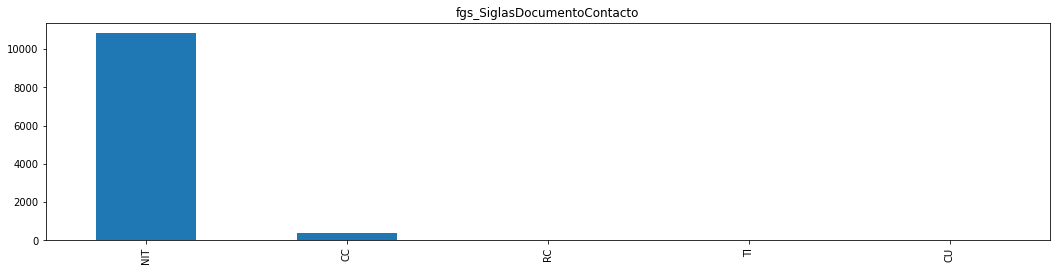

Contacto    10381
Atención      842
Name: fgs_Tipificación, dtype: int64

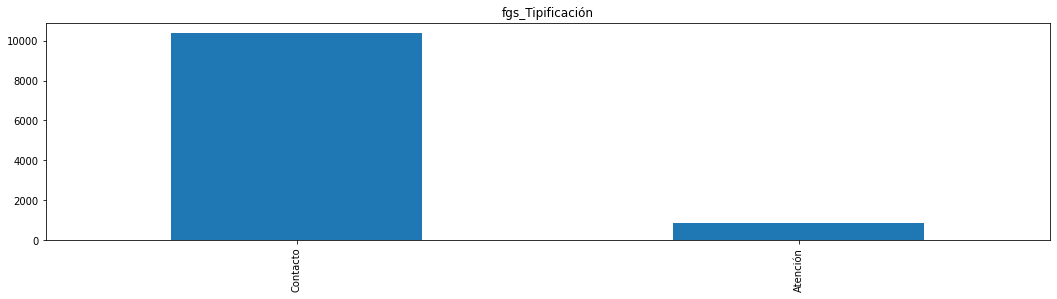

Cuentas por pagar    11223
Name: fgs_Nivel1, dtype: int64

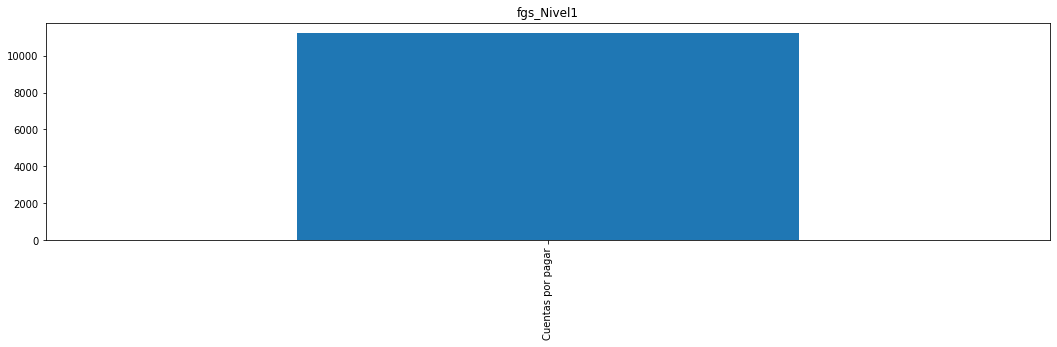

Recepción y contabilización facturas de proveedores    11223
Name: fgs_Nivel2, dtype: int64

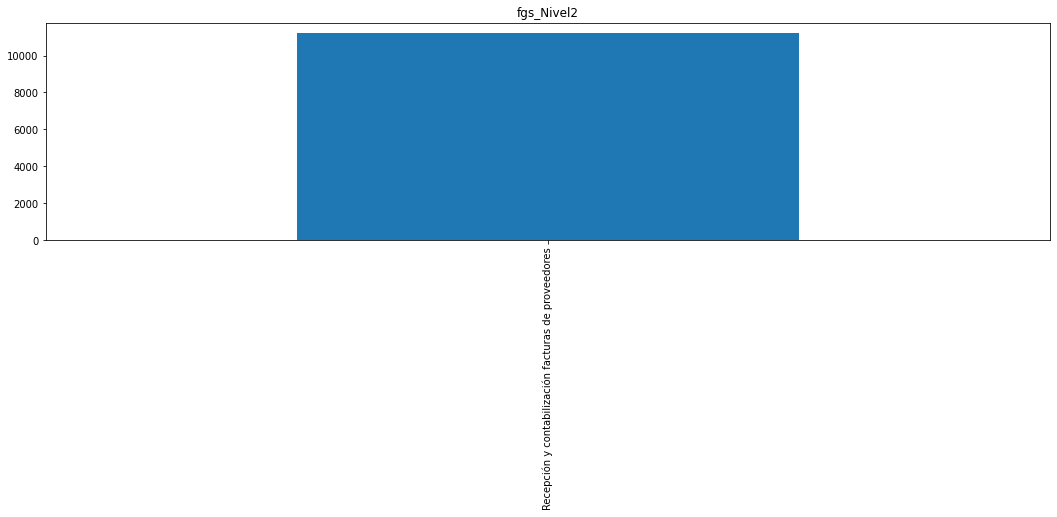

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: fgs_Nivel3, dtype: int64

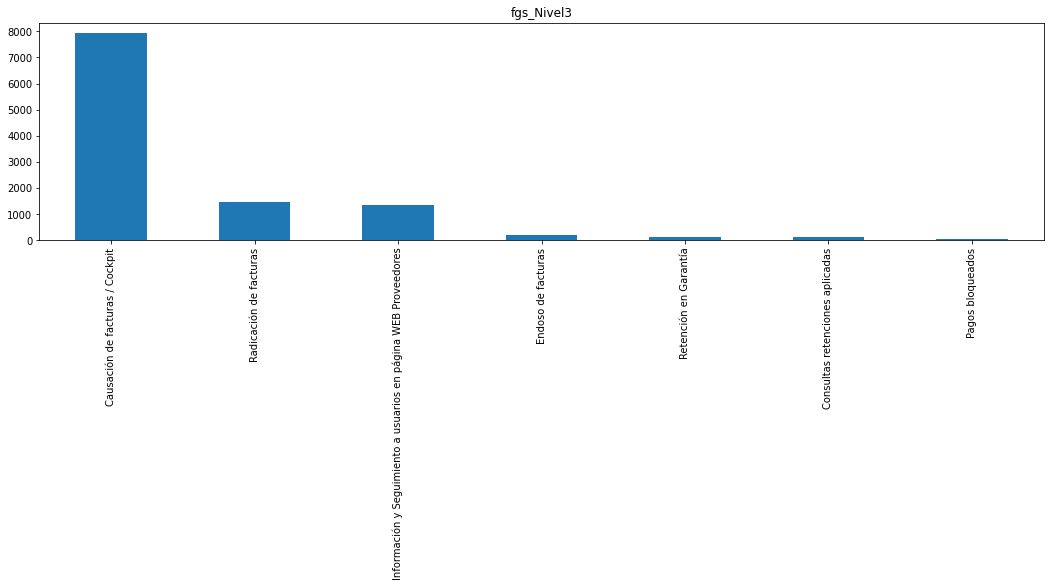

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: fgs_Nivel4, dtype: int64

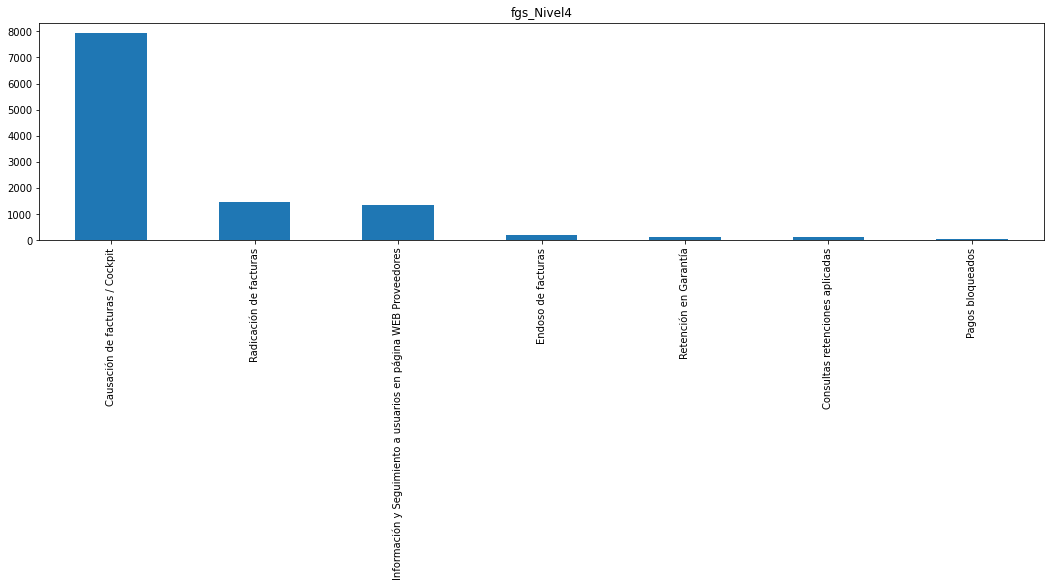

BOGOTA             6765
SANTANDER          1086
ANTIOQUIA           420
META                399
CUNDINAMARCA        372
BOLIVAR             344
HUILA               291
PUTUMAYO            284
VALLE DEL CAUCA     252
ATLANTICO           226
CASANARE            182
N. DE SANTANDER     182
SUCRE                37
BOYACA               34
TOLIMA               31
MAGDALENA            24
NARIÑO               23
CESAR                20
CORDOBA              16
CALDAS               14
RISARALDA            13
QUINDIO              10
ARAUCA                9
CAUCA                 1
CHOCO                 1
GUAVIARE              1
Name: fgs_DepartamentoDireccion_01, dtype: int64

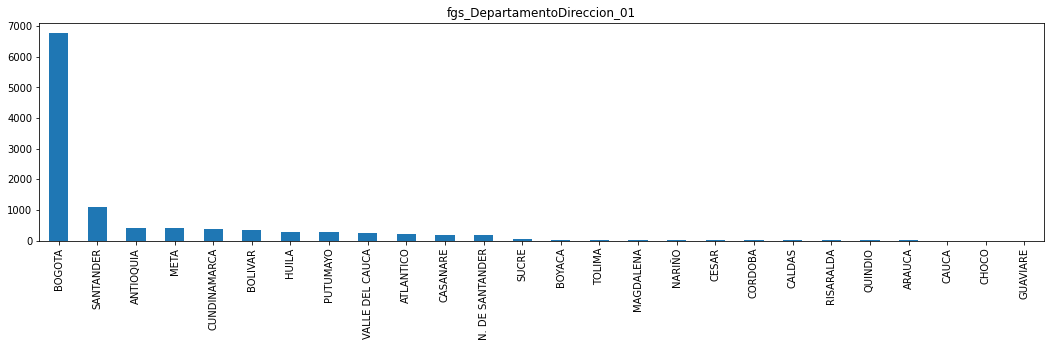

Colombia                     11037
Estados Unidos de América      127
Italia                          16
Brasil                           9
Países Bajos                     8
Francia                          4
México                           4
Noruega                          3
Georgia                          3
Reino Unido                      3
Australia                        2
Canadá                           2
Perú                             1
Name: fgs_PaisDireccion_01, dtype: int64

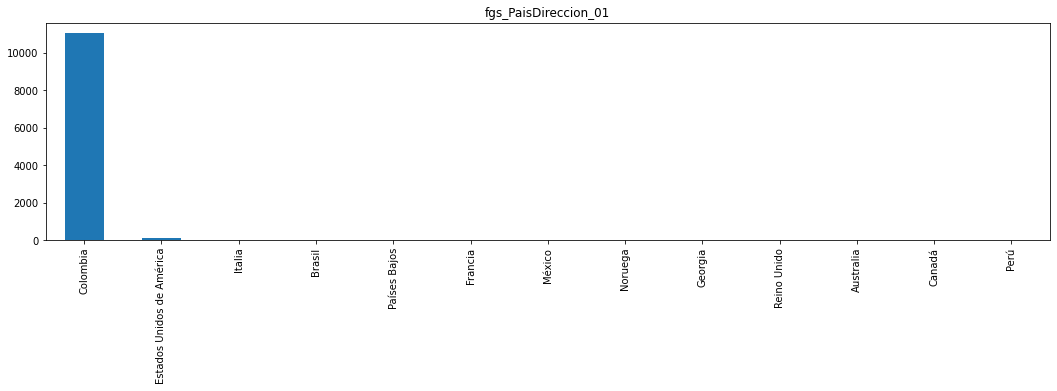

Email BackOffice     6737
Telefónico           4458
Gestión Operativa      28
Name: fmf_Canal, dtype: int64

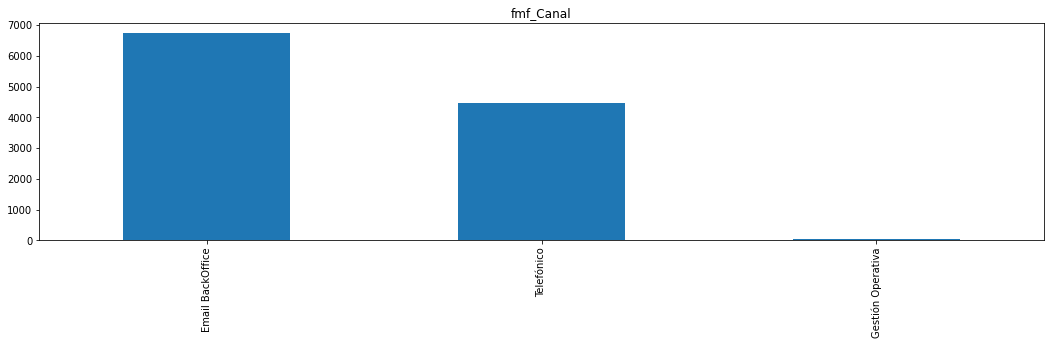

CENTRO ORIENTE       6390
LLANOS ORIENTALES     687
MAGDALENA MEDIO       670
SUR                   621
OCCIDENTE             620
NORTE                 431
Name: ude_Regional, dtype: int64

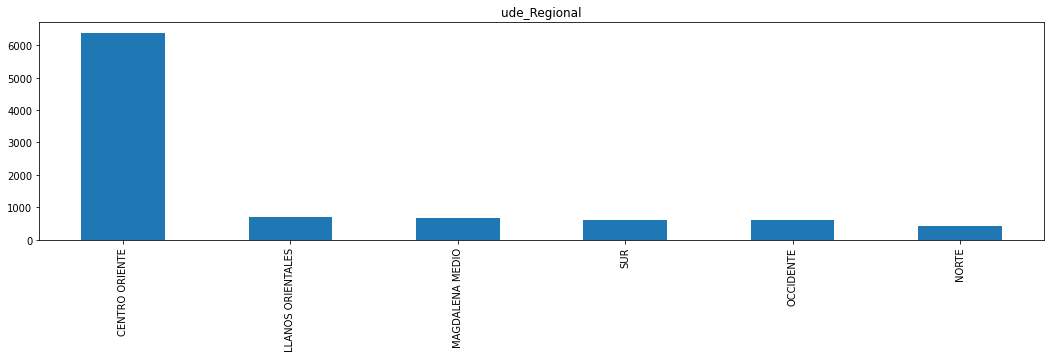

BOGOTA, D.C.       5269
BARRANCABERMEJA     543
BUCARAMANGA         431
CARTAGENA           382
MEDELLIN            285
                   ... 
VILLANUEVA            1
SAN MIGUEL            1
HONDA                 1
MARIQUITA             1
POPAYAN               1
Name: ude_CiudadCliente, Length: 91, dtype: int64

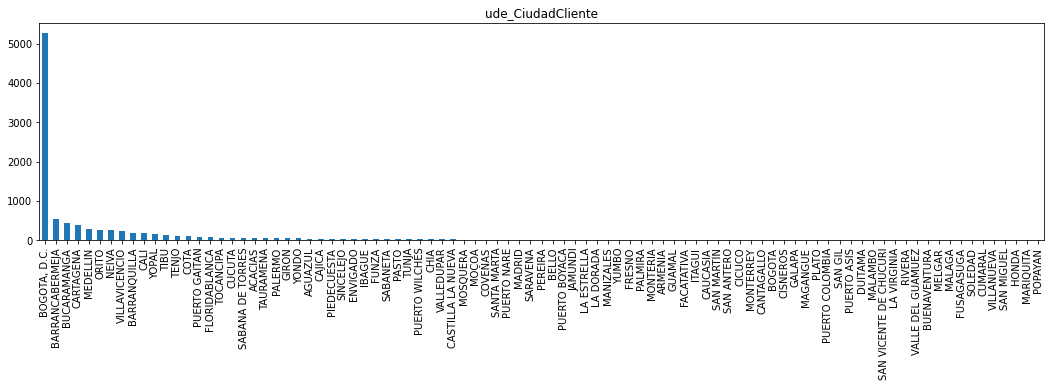

BOGOTA             5273
SANTANDER          1231
ANTIOQUIA           429
META                428
CUNDINAMARCA        401
BOLIVAR             394
HUILA               313
PUTUMAYO            282
CASANARE            257
VALLE DEL CAUCA     220
ATLANTICO           206
N. DE SANTANDER     186
SUCRE                49
TOLIMA               38
BOYACA               31
NARIÑO               22
CESAR                21
MAGDALENA            16
CALDAS               15
RISARALDA            13
ARAUCA               11
CORDOBA              11
QUINDIO               6
LA GUAJIRA            1
CAUCA                 1
Name: ude_DepartamentoCliente, dtype: int64

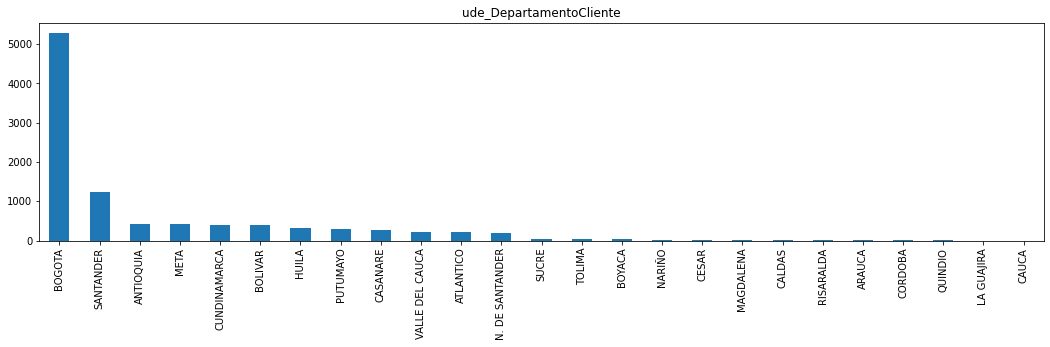

COLOMBIA                     9855
Colombia                     1186
Estados Unidos de América     127
Italia                         16
Brasil                          9
Países Bajos                    8
Francia                         4
México                          4
Noruega                         3
Georgia                         3
Reino Unido                     3
Australia                       2
Canadá                          2
Perú                            1
Name: ude_PaisCliente, dtype: int64

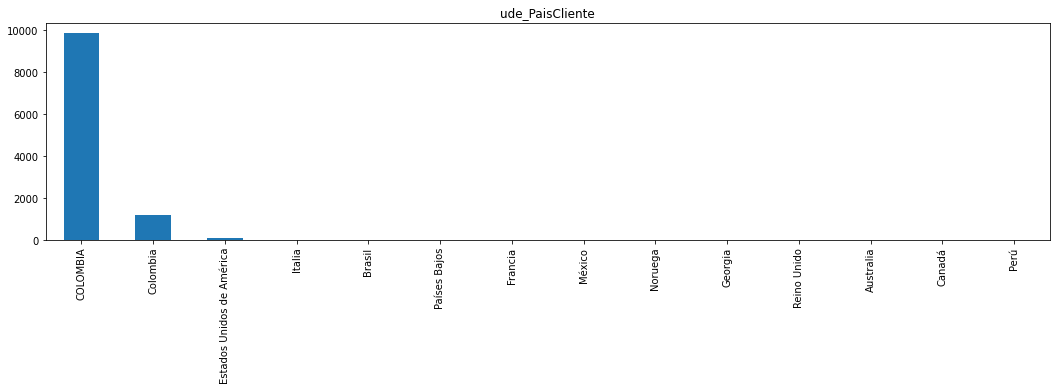

Gerencia Administrativa                     18
Coordinación de Gestión de Cuentas Pagar    12
Coordinación de Gestión de Contratación     12
Coord de Gest de Contrat Reg Andina Orie    10
Gerencia Administrativa VDS                 10
Coord Gestión de Contrat Reg Orinoquía       6
Departamento Regional de HSE Sur             5
Coord de Gestión de Contratación             4
Dep de Gestión Integral y Abastecimiento     4
Gerencia Administrativa VAB                  4
Gerencia de Soporte Tecnológico              4
Gerencia de Seguridad Física                 3
Coord de Gestión de Contrat Reg Central      3
Depto de Logística, Compras                  3
Coordinación de Logística de Bienes          2
Coordinación de Gestión de Inventarios       2
Coordinación Salud Bogotá                    2
Depto Regional de Abastecimiento Caribe      2
Coordinación Conectividad                    2
Coordinación de Operación Tributaria         2
Gerencia de Desarrollo Asociadas             2
Gerencia de P

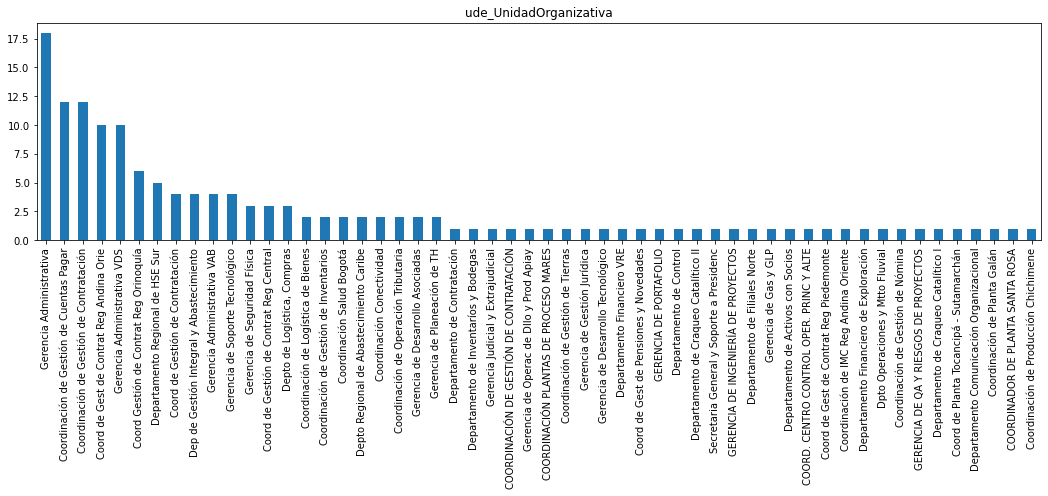

AB1001    40
AB0001    39
PY0012    22
SO0068    15
SC5107    12
          ..
CM0040     1
SC2107     1
CM0044     1
PR9095     1
RF0272     1
Name: ude_CECO, Length: 75, dtype: int64

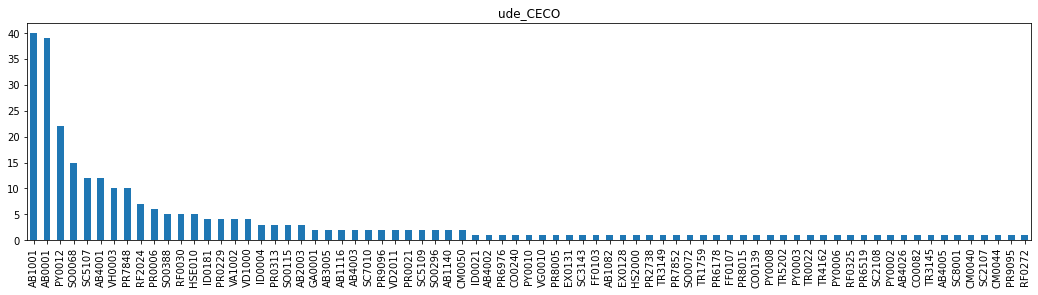

GERENCIA ADMINISTRAT                      13
GERENCIA ADMINISTRATIVA                    9
CORD PLANEAC GEST                          9
COORD CC VAO                               9
COORDINACIÓN GESTIÓN DE CTAS POR PAGAR     7
                                          ..
VICEP. JURIDICA                            1
ETILENO II                                 1
COORD GESTION CONTRATACION VAO             1
REGIONAL USR MAGDA.                        1
COORD GEST CONTRAT                         1
Name: ude_CentroDeCostos, Length: 69, dtype: int64

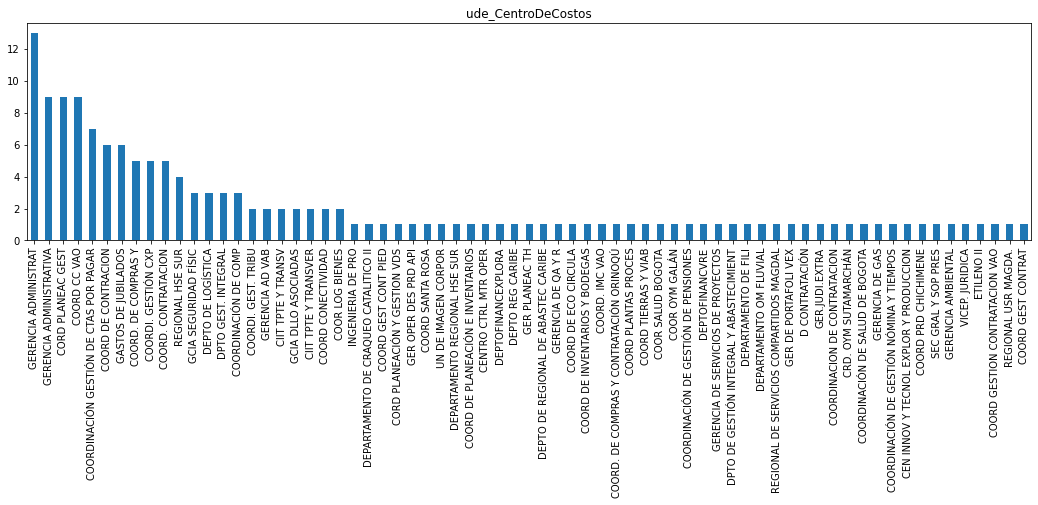

Puesto de Trabajo    9881
Transacciones        1342
Name: SistemaPago, dtype: int64

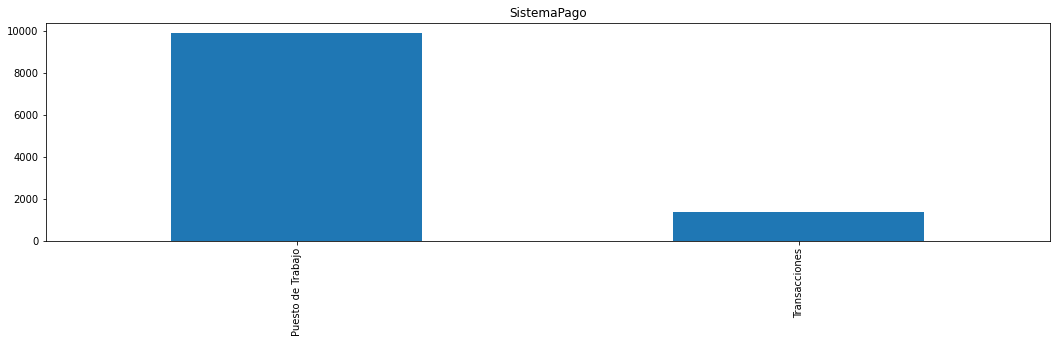

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: ServicioPortafolio, dtype: int64

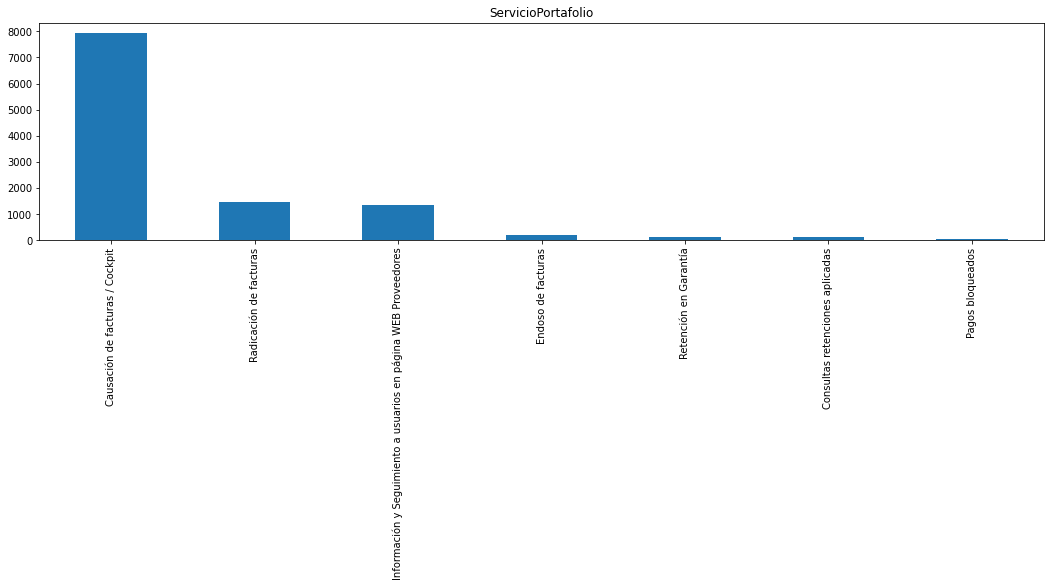

Cerrado     10716
Escalado      507
Name: fdp_NombreEstado, dtype: int64

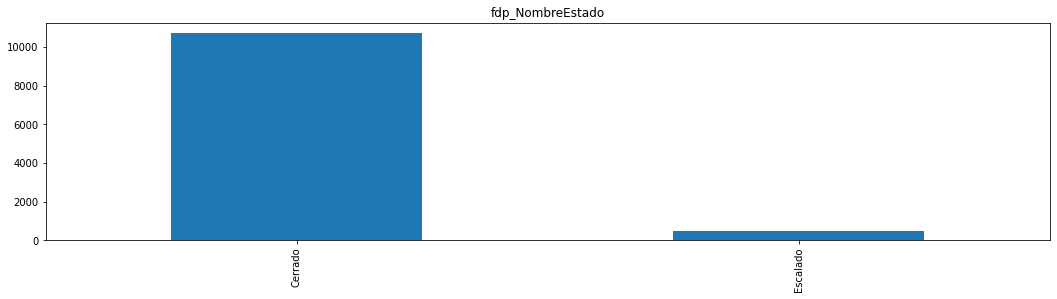

Nivel1    10381
Nivel2      842
Name: fdp_NivelEstado, dtype: int64

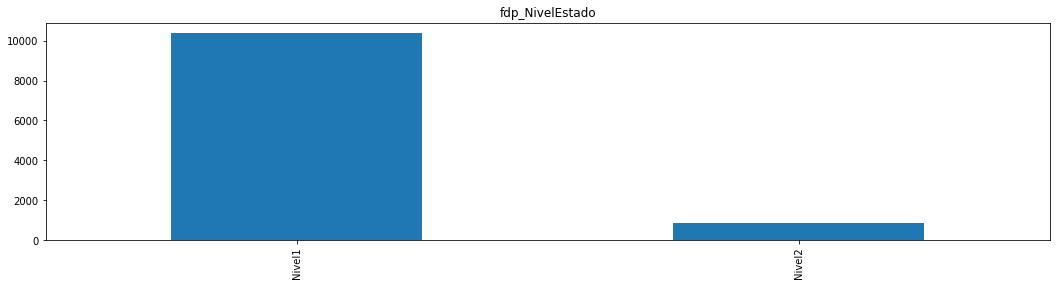

ANGIE CATHERINE BLANDON CACERES            1360
CLAUDIA MARCELA PINEDA                     1223
PAOLA ANDREA DAZA                          1180
EDGAR ANDRES GUZMAN HERNANDEZ              1146
LAURA MAYERLY BOHORQUEZ GAMBA              1077
JEIMY YOLIMA ARDILA PINZON                 1073
JEIMY NATHALY GOMEZ GOMEZ                  1038
NATHALIA ROJAS CLAVIJO                     1006
LINDA ALEJANDRA CAMACHO MURILLO             990
ESTEFANIA GUZMAN AGUDELO                    865
ALEX LILIAN TOVAR ORTIZ                     264
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO        1
Name: fdp_NombreUsuarioCreacion, dtype: int64

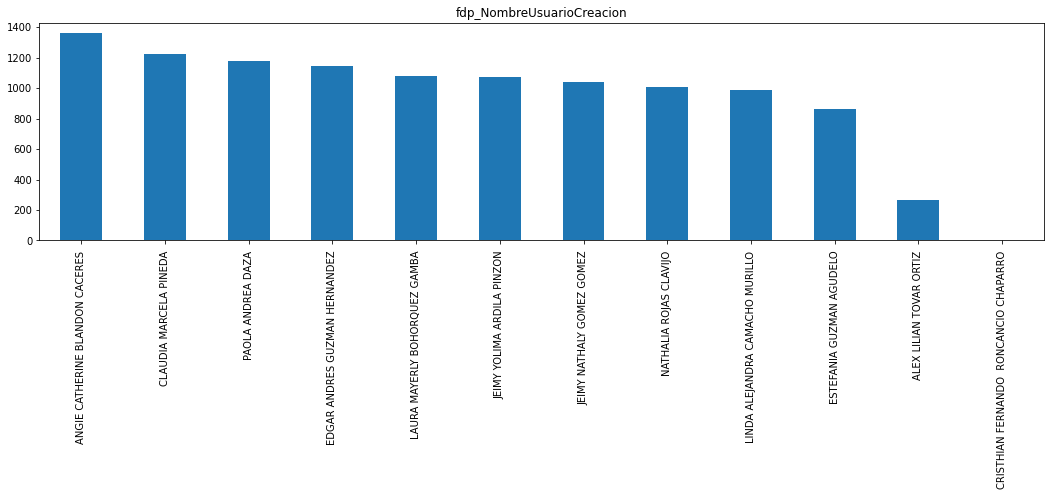

Asesor de Servicio BackOffice Contact Center    9881
Asesor de Servicio Contact Center               1342
Name: GrupoRolCreacion, dtype: int64

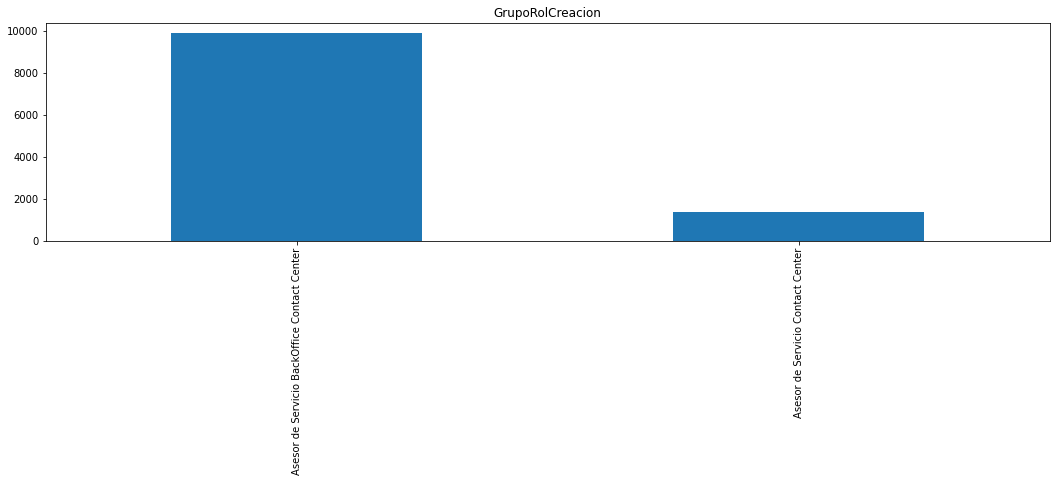

No Aplica    4486
Cumple       3446
No Cumple    3291
Name: Cumple_Objetivo_SolicitadoRegistrado, dtype: int64

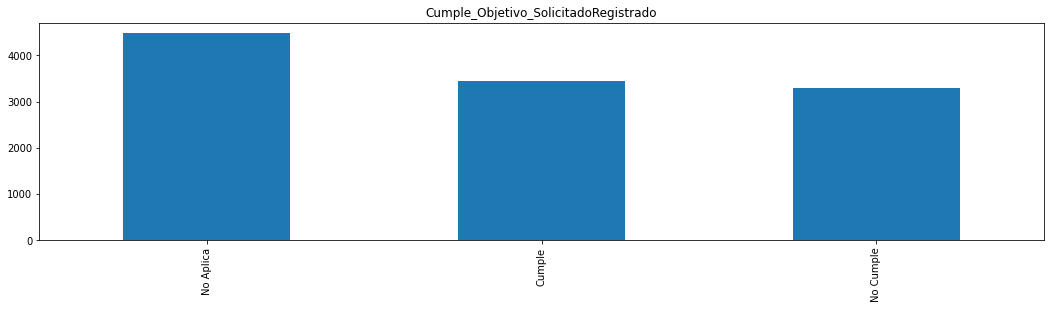

Cumple       11190
No Cumple       33
Name: Cumple_Objetivo_RegistradoEscalado, dtype: int64

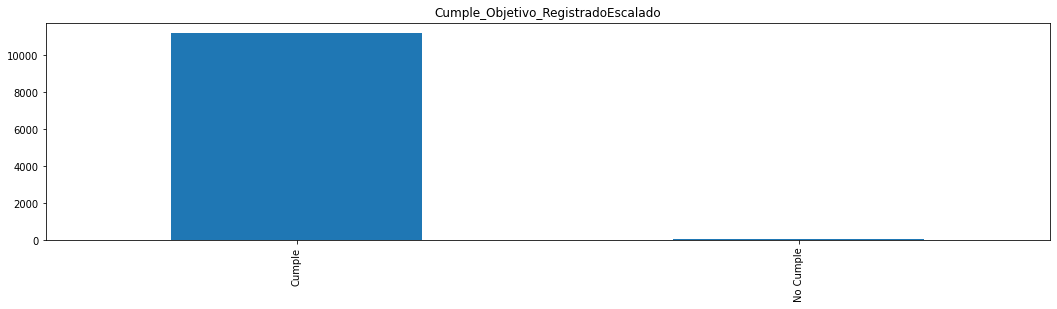

Equipo de Causación     838
Equipo de Radicación      4
Name: fdp_NombreGrupoEscalamientoN2, dtype: int64

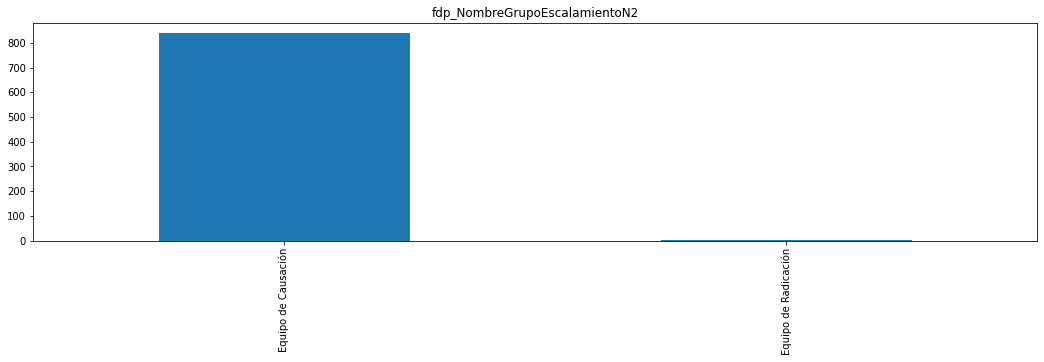

HAROL ESTIVEN SUAREZ BERNAL            181
ADRIANA PATRICIA COMBITA ALFONSO       145
CLAUDIA  NOVA CHAVEZ                   136
NANCY GAMBA LÓPEZ                      109
HARBEY WILFREDO CHAVARRIO ALVARADO     107
MARTHA ELENA BELLO FORERO               60
AMPARO DEL PILAR TORRES                 45
SANDRA PATRICIA ESTUPIÑAN SANDOVAL      30
EDISON MAURICIO CORTES LEON              6
LISETT CAROLINA VINUEZA MALES            5
DEXY OSPINA RIOS                         5
LEONARDO PINEDA ROJAS                    2
LIZBETH   PEREZ TORRES                   1
JULIAN ENRIQUE CAMACHO BECERRA           1
Name: fdp_NombreUsuarioEscalamientoN2, dtype: int64

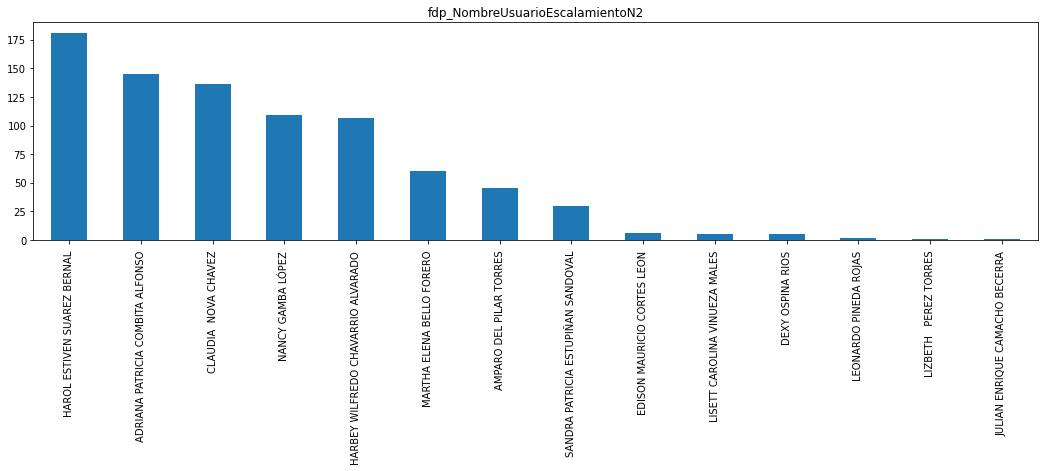

Asesor solucionador Ecopetrol              694
Asesor Solucionador Tercero                138
Asesor de Servicio Front Contact Center      1
Name: GrupoRolEscalamientoN2, dtype: int64

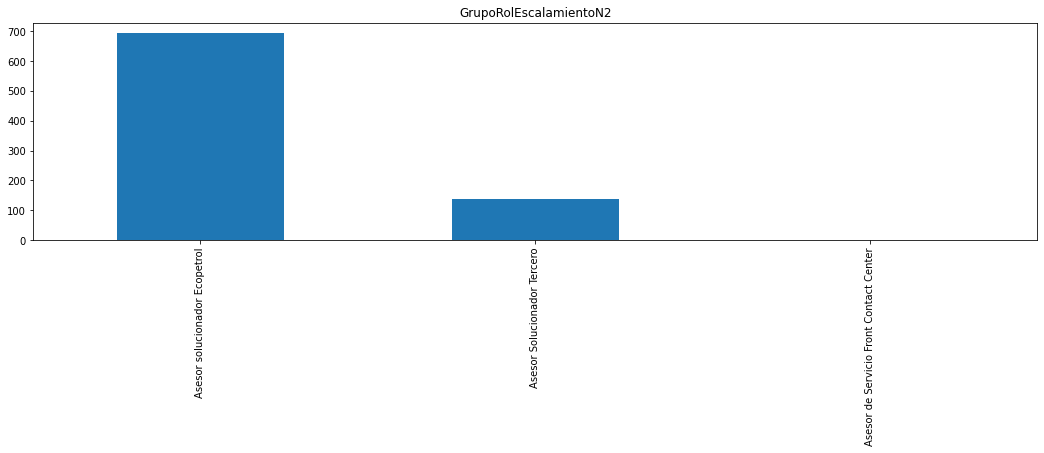

No Aplica    10888
Cumple         292
No Cumple       43
Name: Cumple_Objetivo_EnNivel2, dtype: int64

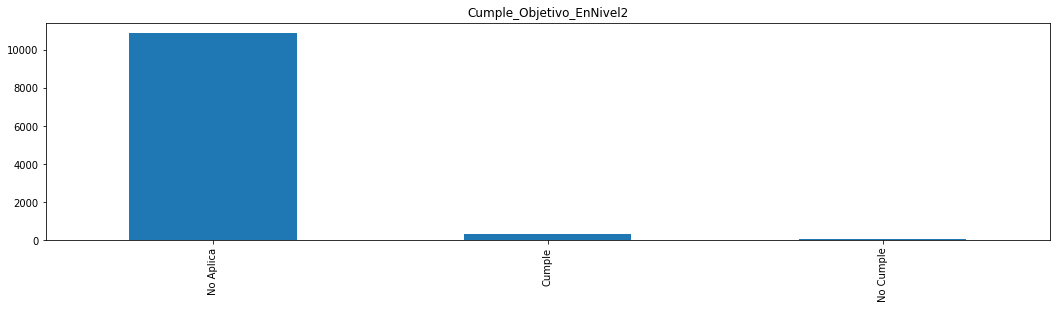

ANGIE CATHERINE BLANDON CACERES     9
CLAUDIA MARCELA PINEDA              8
LAURA MAYERLY BOHORQUEZ GAMBA       6
NATHALIA ROJAS CLAVIJO              2
LINDA ALEJANDRA CAMACHO MURILLO     2
Name: fdp_NombreUsuarioDevolucion, dtype: int64

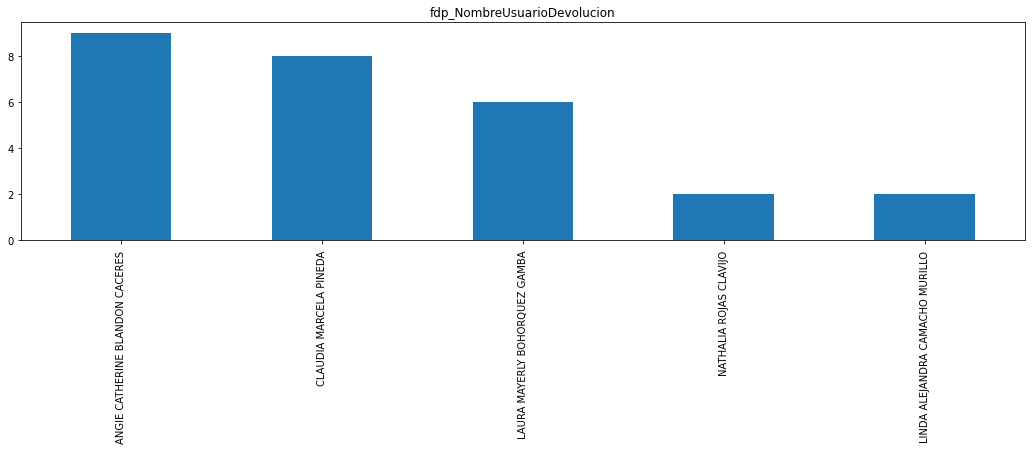

No tengo asignada la factura.                                                                                                                          4
Por favor direccionar a la funcionaria Amparo Torres quien rechazo la factura y al funcionario harbey chavarrio quien causo la factura 13855.          1
Buenos días<br>De acuerdo con el caso se habla de unos soportes, pero el caso no tiene ningún adjunto.  Gracias                                        1
Favor redireccionar este tema a NAncy Gamba                                                                                                            1
La factura esta a cargo de Harbey Chavarrio                                                                                                            1
Se debe escalar al funcionario que realizo la causación de la factura.                                                                                 1
Las facturas de este proveedor están a cargo de Edison Mauricio Cortes            

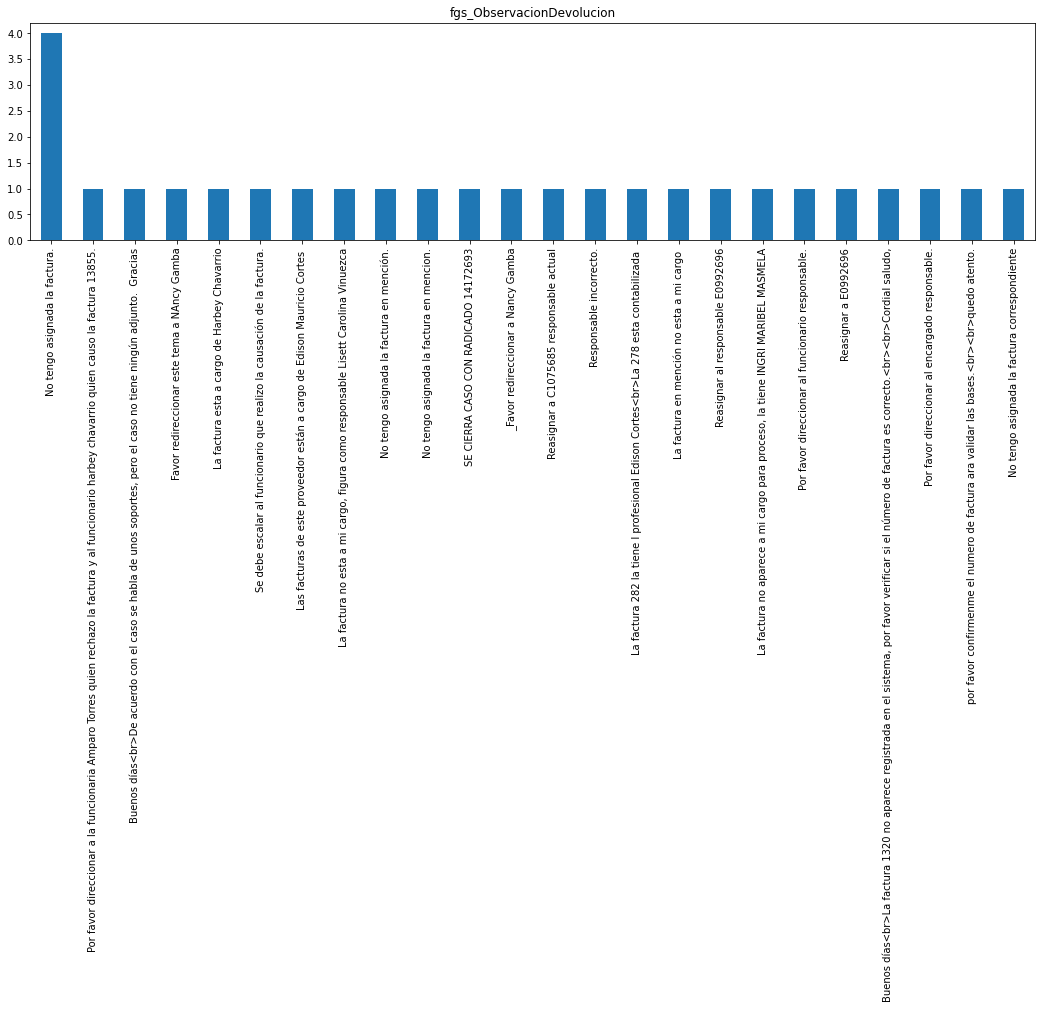

2021-04-11 10:14:19.227000    1
2021-03-15 21:07:37.637000    1
2021-05-04 16:34:06.210000    1
2021-04-19 14:30:08.297000    1
2021-05-18 16:25:00.273000    1
2021-03-12 19:15:54.417000    1
2021-05-18 16:27:04.350000    1
2021-05-31 08:46:04.693000    1
2021-03-13 07:55:41.017000    1
2021-03-15 16:43:51.233000    1
2021-03-15 21:08:36.827000    1
2021-05-09 08:30:37.367000    1
2021-05-25 12:39:34.237000    1
2021-03-13 07:52:16.150000    1
2021-04-11 19:34:49.583000    1
2021-03-23 13:30:03.140000    1
2021-03-15 16:46:07.737000    1
2021-03-12 19:17:02.827000    1
2021-03-15 16:37:46.097000    1
2021-04-11 09:54:46.040000    1
2021-03-18 19:26:17.137000    1
2021-03-15 16:40:05.543000    1
2021-03-21 22:16:21.900000    1
2021-03-13 07:41:32.923000    1
2021-03-12 19:15:24.797000    1
2021-03-13 08:14:08.413000    1
2021-02-27 08:39:34.367000    1
Name: fdp_FechaDevolucion, dtype: int64

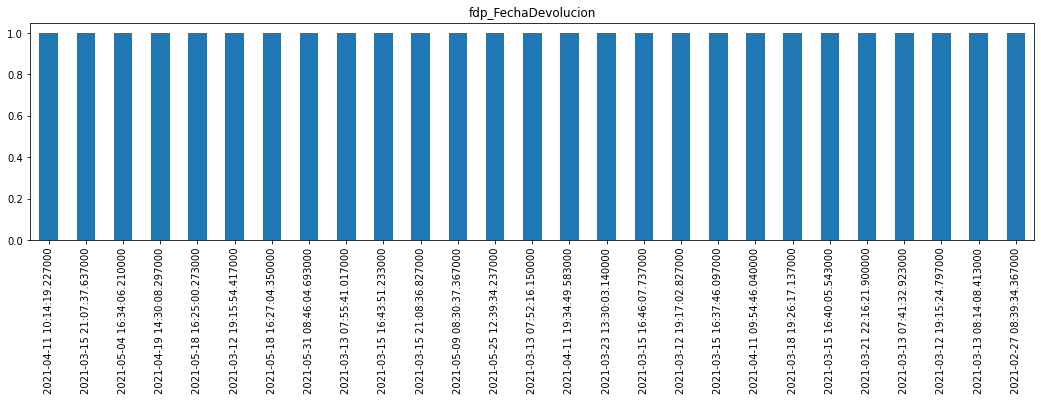

2021-03-15 07:30:00    2
2021-04-15 08:03:00    1
2021-03-15 14:08:00    1
2021-05-25 07:37:00    1
2021-03-16 09:12:00    1
2021-03-23 11:08:00    1
2021-03-29 07:30:00    1
2021-03-23 12:07:00    1
2021-03-26 10:27:00    1
2021-03-15 14:25:00    1
2021-04-23 10:00:00    1
2021-03-15 12:40:00    1
2021-05-11 09:11:00    1
2021-05-28 08:54:00    1
2021-03-15 14:06:00    1
2021-05-25 11:29:00    1
2021-06-01 12:48:00    1
2021-03-15 09:17:00    1
2021-04-13 15:33:00    1
2021-03-16 10:46:00    1
2021-03-16 16:27:00    1
2021-03-26 09:29:00    1
2021-03-18 07:30:00    1
2021-03-04 15:58:00    1
2021-04-13 12:03:00    1
2021-05-10 15:31:00    1
Name: fdp_FechaVencimientoDevolucion, dtype: int64

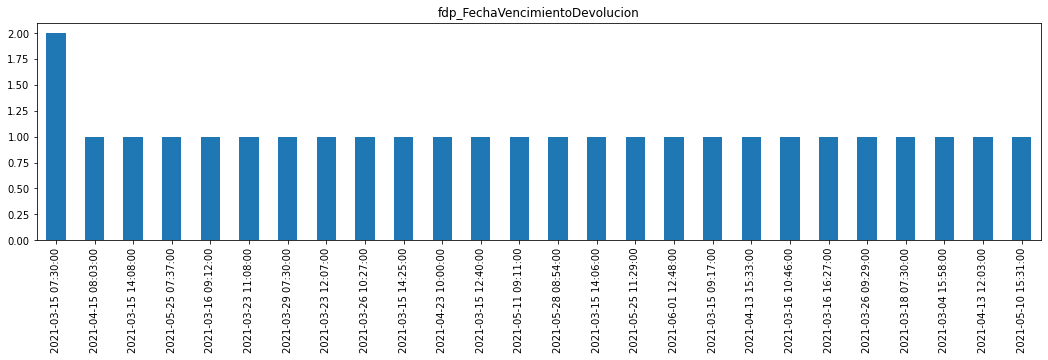

Asesor de Servicio BackOffice Contact Center    21
Asesor de Servicio Contact Center                6
Name: GrupoRolDevolucion, dtype: int64

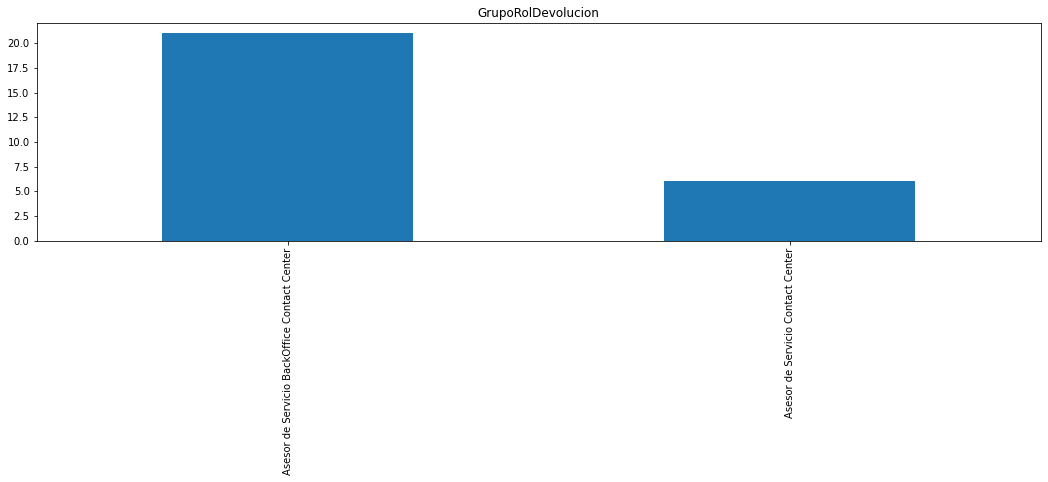

Escalado al responsable de solución equivocado                                     23
No se encuentra formato de soporte o no es legible                                  2
Recepción de solicitud incompleta  no se validaron correctamente los requisitos     1
Name: fdp_MotivoDevolucion, dtype: int64

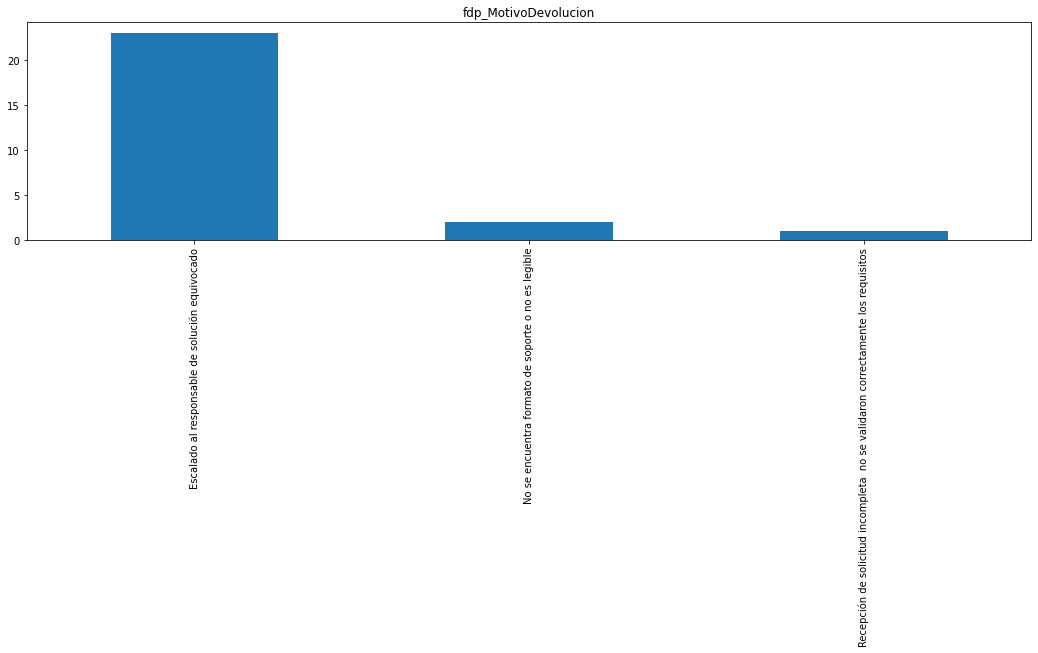

Grupo Primer Nivel Operaciones Financieras    10381
Equipo de Causación                             335
Name: fdp_NombreGrupoSolucion, dtype: int64

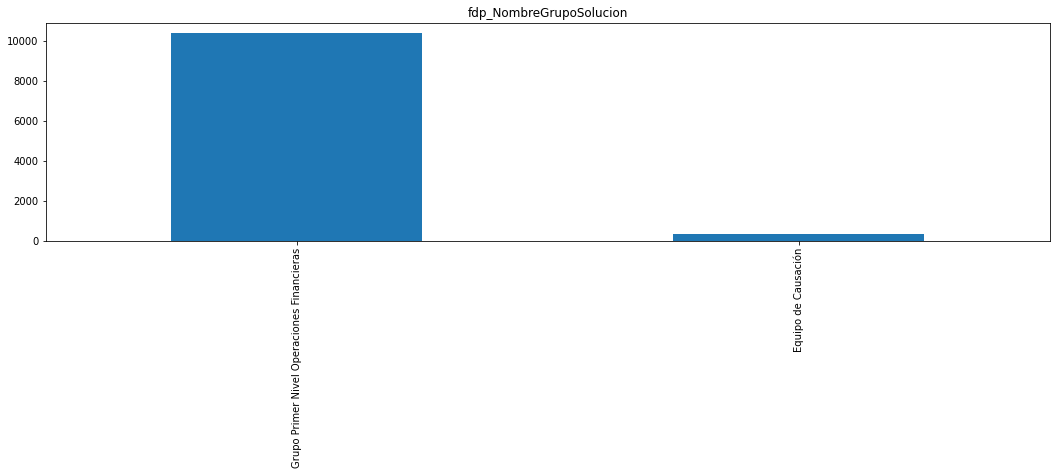

ANGIE CATHERINE BLANDON CACERES            1245
EDGAR ANDRES GUZMAN HERNANDEZ              1146
PAOLA ANDREA DAZA                          1071
CLAUDIA MARCELA PINEDA                     1070
JEIMY YOLIMA ARDILA PINZON                 1051
LINDA ALEJANDRA CAMACHO MURILLO             963
LAURA MAYERLY BOHORQUEZ GAMBA               949
JEIMY NATHALY GOMEZ GOMEZ                   945
NATHALIA ROJAS CLAVIJO                      929
ESTEFANIA GUZMAN AGUDELO                    763
ALEX LILIAN TOVAR ORTIZ                     248
ADRIANA PATRICIA COMBITA ALFONSO            147
NANCY GAMBA LÓPEZ                           109
AMPARO DEL PILAR TORRES                      43
HARBEY WILFREDO CHAVARRIO ALVARADO           36
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO        1
Name: fdp_NombreUsuarioSolucion, dtype: int64

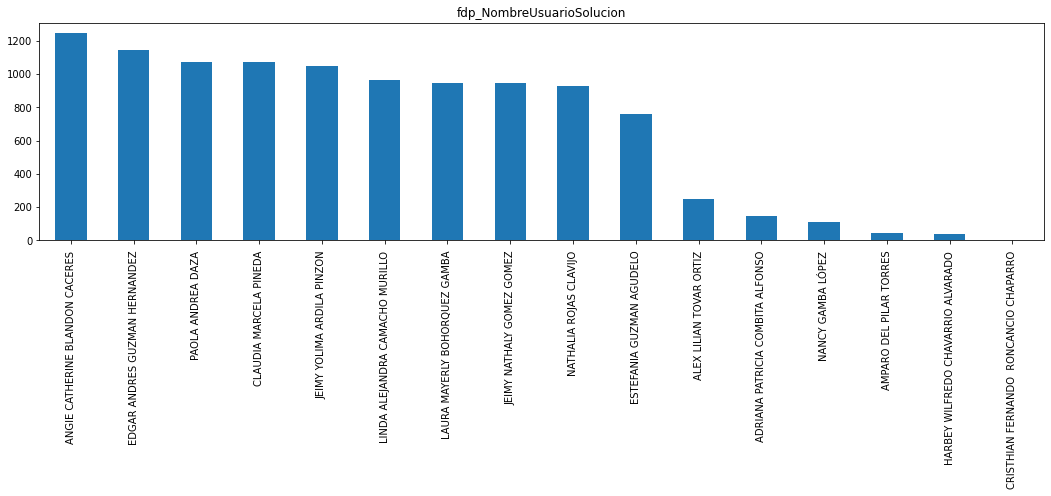

Asesor de Servicio BackOffice Contact Center    9183
Asesor de Servicio Contact Center               1198
Asesor solucionador Ecopetrol                    335
Name: GrupoRolSolucion, dtype: int64

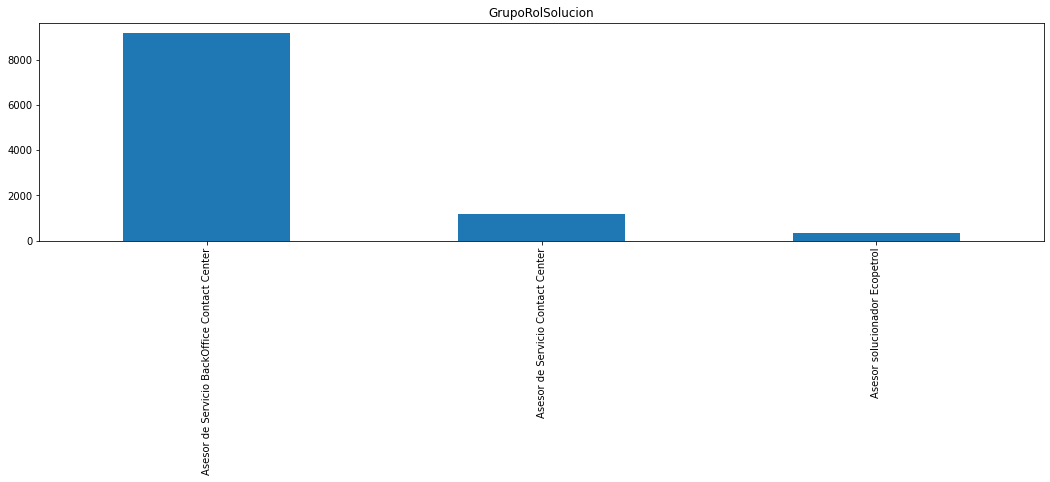

Nivel1    10381
Nivel2      335
Name: fdp_NivelSolucion, dtype: int64

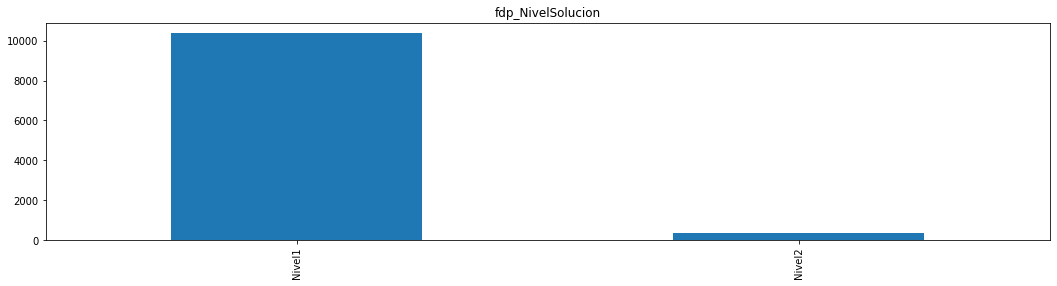

Cumple       10716
No Aplica      507
Name: Cumple_Objetivo_SolucionadoCerrado, dtype: int64

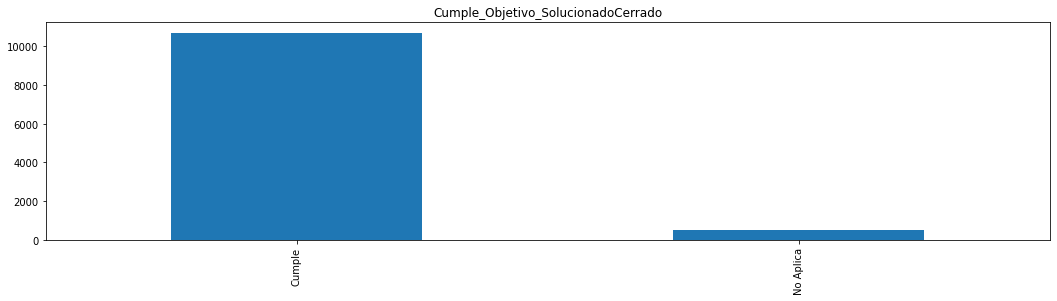

Grupo Primer Nivel Operaciones Financieras    10381
Equipo de Causación                             335
Name: fdp_NombreGrupoCierre, dtype: int64

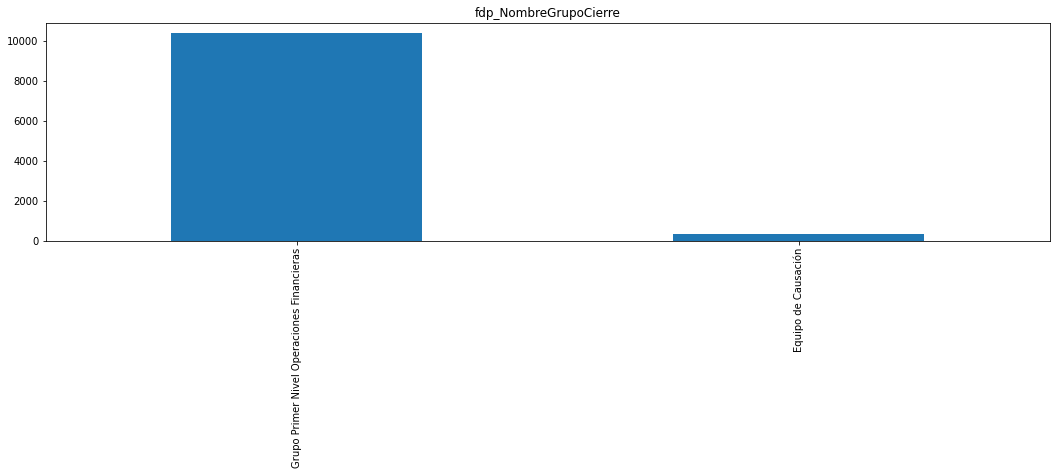

ANGIE CATHERINE BLANDON CACERES            1245
EDGAR ANDRES GUZMAN HERNANDEZ              1146
PAOLA ANDREA DAZA                          1071
CLAUDIA MARCELA PINEDA                     1070
JEIMY YOLIMA ARDILA PINZON                 1051
LINDA ALEJANDRA CAMACHO MURILLO             963
LAURA MAYERLY BOHORQUEZ GAMBA               949
JEIMY NATHALY GOMEZ GOMEZ                   945
NATHALIA ROJAS CLAVIJO                      929
ESTEFANIA GUZMAN AGUDELO                    763
ALEX LILIAN TOVAR ORTIZ                     248
ADRIANA PATRICIA COMBITA ALFONSO            147
NANCY GAMBA LÓPEZ                           109
AMPARO DEL PILAR TORRES                      43
HARBEY WILFREDO CHAVARRIO ALVARADO           36
CRISTHIAN FERNANDO  RONCANCIO CHAPARRO        1
Name: fdp_NombreUsuarioCierre, dtype: int64

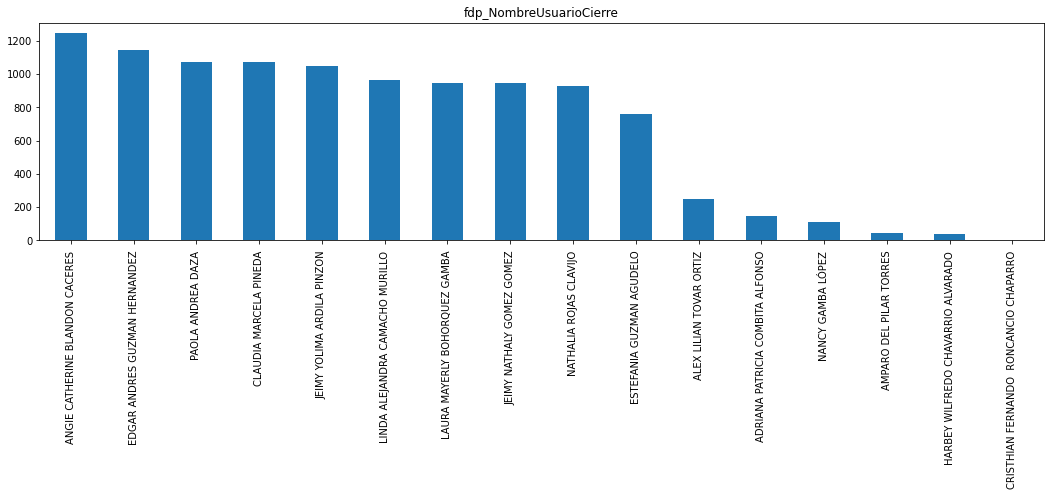

Asesor de Servicio BackOffice Contact Center    9183
Asesor de Servicio Contact Center               1198
Asesor solucionador Ecopetrol                    335
Name: GrupoRolCierre, dtype: int64

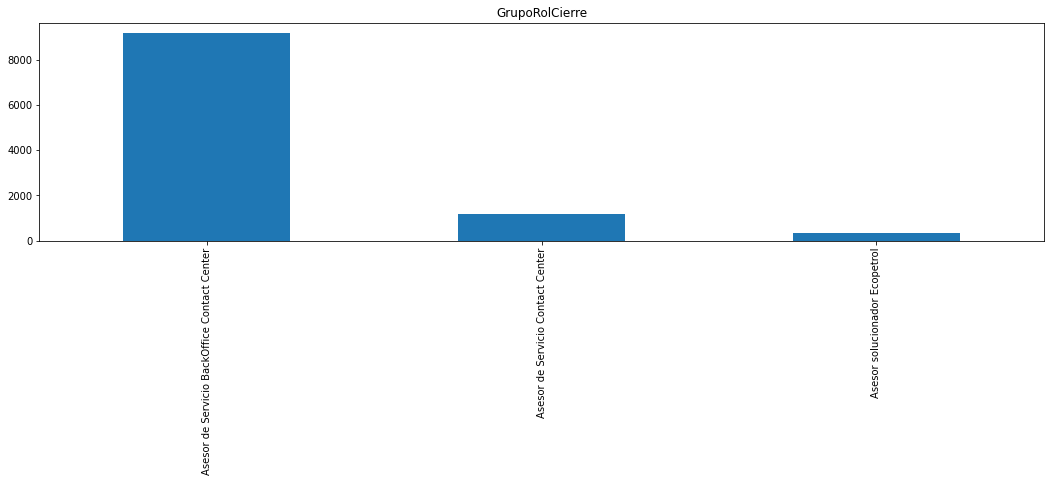

Nivel1    10381
Nivel2      335
Name: fdp_NivelCierre, dtype: int64

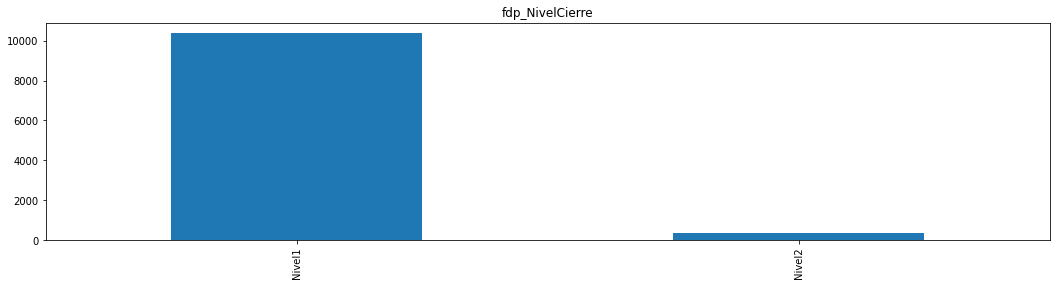

Grupo Primer Nivel Operaciones Financieras    10381
Equipo de Causación                             838
Equipo de Radicación                              4
Name: fdp_NombreGrupoGestionActual, dtype: int64

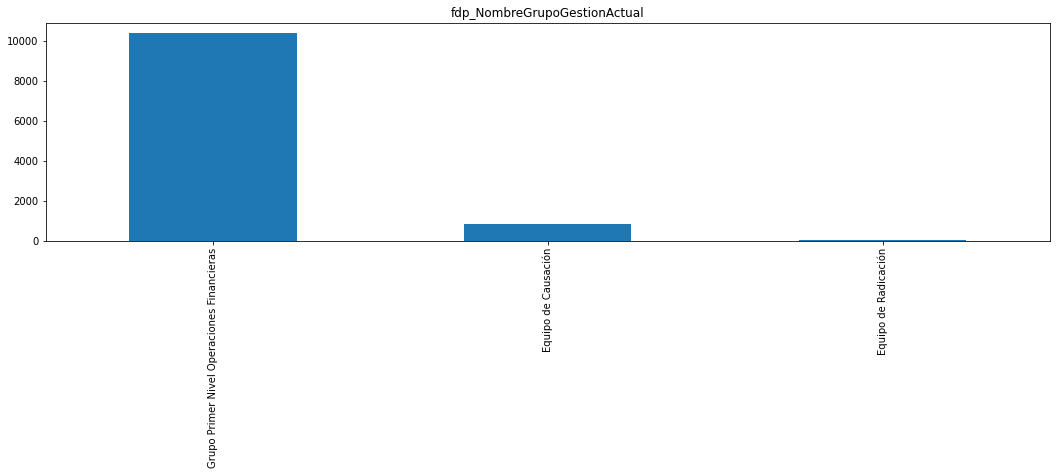

ANGIE CATHERINE BLANDON CACERES            1245
EDGAR ANDRES GUZMAN HERNANDEZ              1146
PAOLA ANDREA DAZA                          1071
CLAUDIA MARCELA PINEDA                     1070
JEIMY YOLIMA ARDILA PINZON                 1051
LINDA ALEJANDRA CAMACHO MURILLO             963
LAURA MAYERLY BOHORQUEZ GAMBA               949
JEIMY NATHALY GOMEZ GOMEZ                   945
NATHALIA ROJAS CLAVIJO                      929
ESTEFANIA GUZMAN AGUDELO                    763
ALEX LILIAN TOVAR ORTIZ                     248
HAROL ESTIVEN SUAREZ BERNAL                 183
ADRIANA PATRICIA COMBITA ALFONSO            147
CLAUDIA  NOVA CHAVEZ                        137
NANCY GAMBA LÓPEZ                           110
HARBEY WILFREDO CHAVARRIO ALVARADO          108
MARTHA ELENA BELLO FORERO                    61
AMPARO DEL PILAR TORRES                      45
SANDRA PATRICIA ESTUPIÑAN SANDOVAL           30
EDISON MAURICIO CORTES LEON                   6
LISETT CAROLINA VINUEZA MALES           

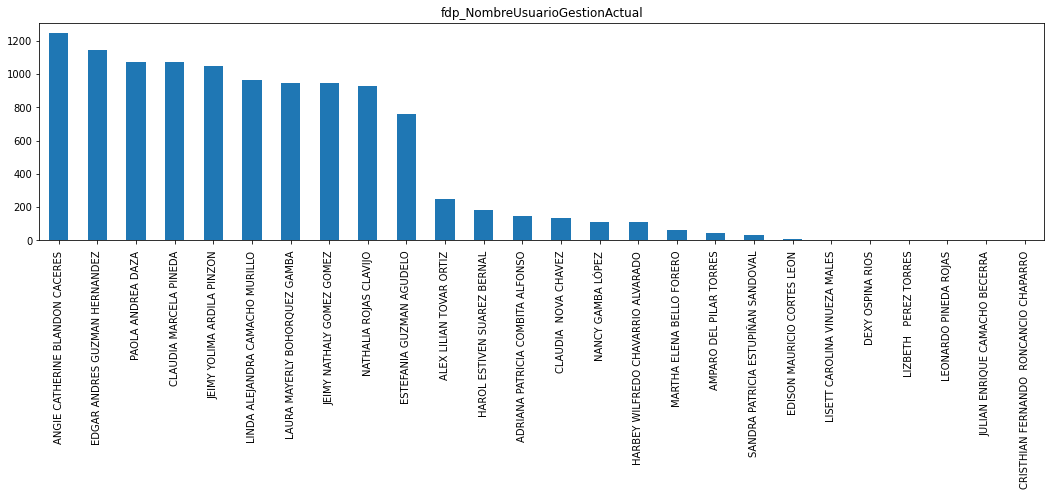

Asesor de Servicio BackOffice Contact Center    9183
Asesor de Servicio Contact Center               1198
Asesor solucionador Ecopetrol                    701
Asesor Solucionador Tercero                      138
Asesor de Servicio Front Contact Center            1
Name: GrupoRolGestionActual, dtype: int64

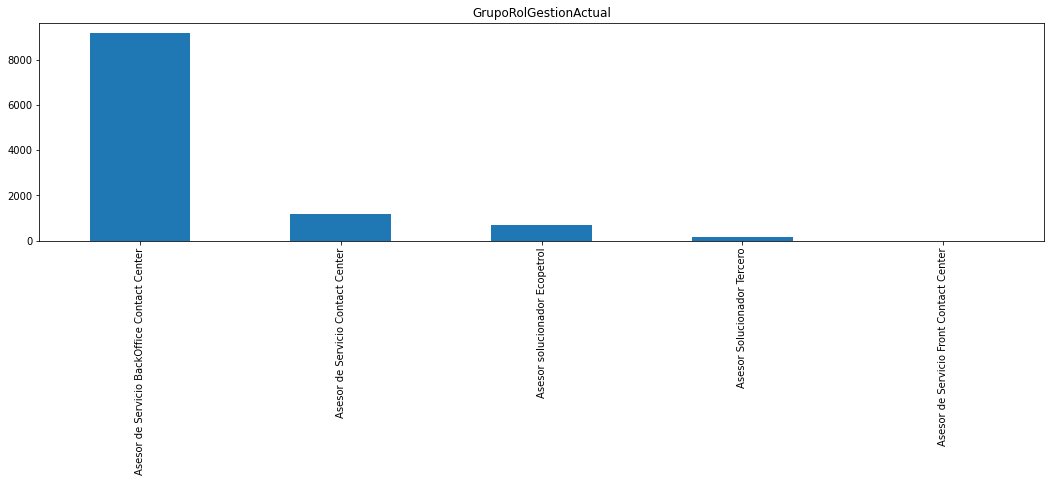

Nivel1    10381
Nivel2      842
Name: fdp_NivelGestionActual, dtype: int64

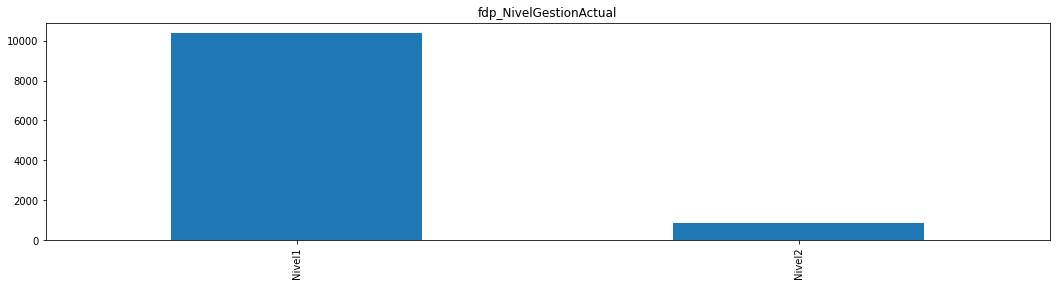

Fecha Superior a la fecha de creación o Fecha Nula      6191
Fecha de Modificación Menor a la del estado anterior     867
No Registra Canal                                          1
Name: TipoAjuste, dtype: int64

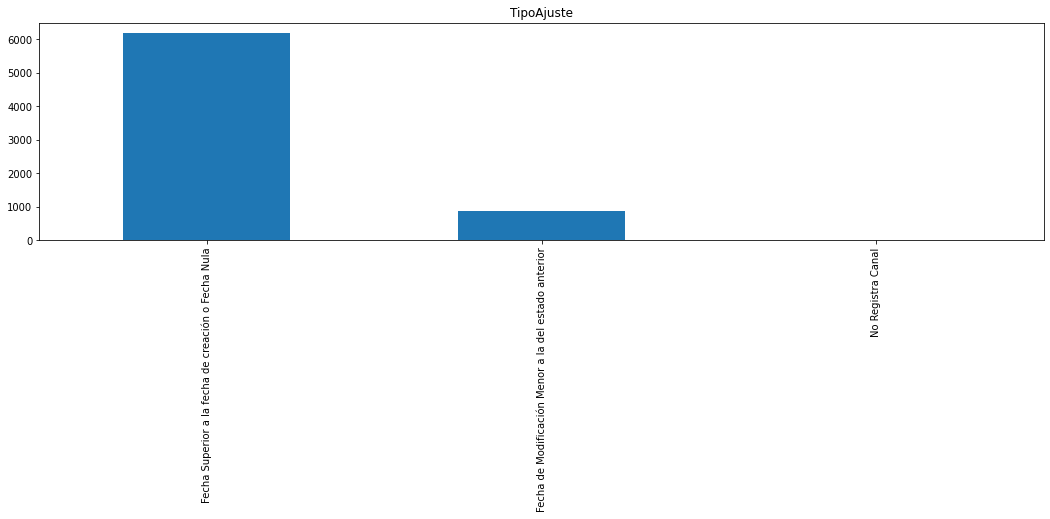

In [ ]:
lista_menores = []
lista_mayores = []
for i in objetos.columns:
  
  if objetos[i].nunique()<=100:
    display(objetos[i].value_counts())
    objetos[i].value_counts().plot.bar(title=i,figsize=(18,4))
    plt.show()
    lista_menores.append(i)
  else:
    lista_mayores.append(i)
# nota aparece un valor con un valor pero se deve a que despues de la limpieza se elimino 'Prestador de Servicios de Salud'

count    1.122300e+04
mean     1.609180e+10
std      2.614531e+11
min      1.000000e+02
5%       7.972226e+07
25%      8.002378e+09
50%      8.600058e+09
75%      9.003005e+09
95%      9.011237e+09
99%      9.014032e+09
max      8.226125e+12
Name: fgs_NumeroDocumContacto, dtype: float64

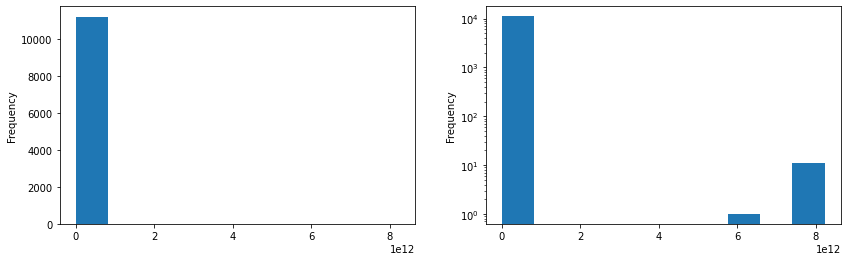

count    11223.000000
mean      7590.224450
std        597.304313
min       7367.000000
5%        7367.000000
25%       7367.000000
50%       7367.000000
75%       7373.000000
95%       9198.000000
99%       9198.000000
max       9198.000000
Name: fgs_IdTipificacionGestionDetalle, dtype: float64

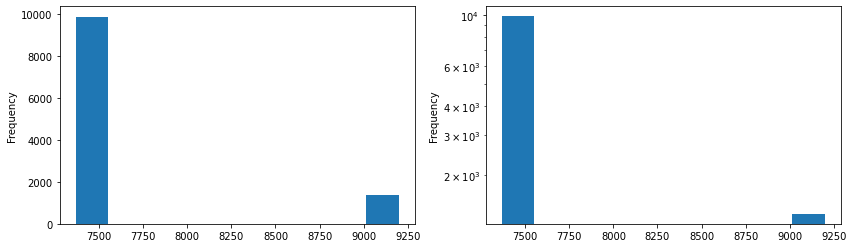

count    1.510000e+02
mean     1.360638e+07
std      1.763559e+07
min      1.000004e+07
5%       1.000028e+07
25%      1.000317e+07
50%      1.000440e+07
75%      1.000528e+07
95%      1.000611e+07
99%      1.000000e+08
max      1.000000e+08
Name: ude_CodUni, dtype: float64

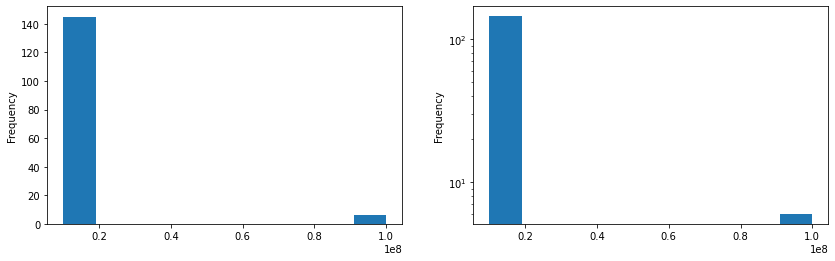

count     11223.000000
mean      18626.509935
std       64586.094259
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
95%      231673.400000
99%      266812.620000
max      282462.000000
Name: fdp_IdPqr, dtype: float64

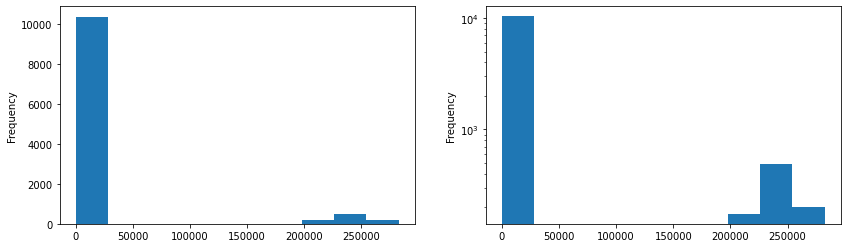

count    11223.000000
mean         1.045175
std          0.207697
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          1.000000
95%          1.000000
99%          2.000000
max          2.000000
Name: fdp_IdEstado, dtype: float64

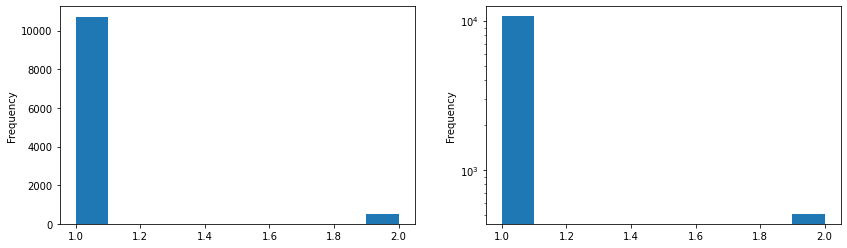

count    867.000000
mean     654.004614
std        0.067806
min      654.000000
5%       654.000000
25%      654.000000
50%      654.000000
75%      654.000000
95%      654.000000
99%      654.000000
max      655.000000
Name: fdp_IdFlujo, dtype: float64

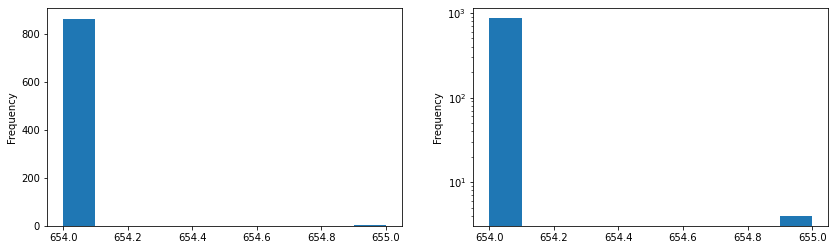

count    11223.000000
mean         2.766640
std          0.803543
min          0.000000
5%           0.000000
25%          3.000000
50%          3.000000
75%          3.000000
95%          3.000000
99%          3.000000
max          3.000000
Name: fdp_IdHistoricoPqrCreacion, dtype: float64

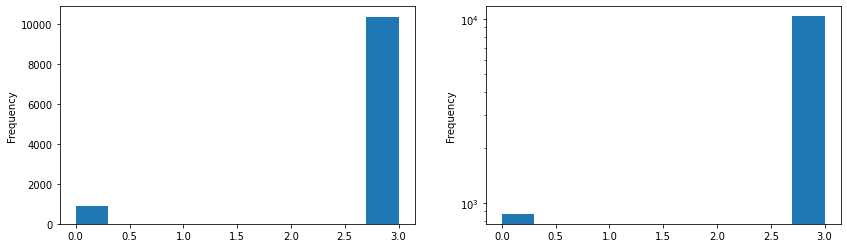

count    11223.000000
mean       122.679408
std         45.815392
min         57.000000
5%          57.000000
25%        103.000000
50%        135.000000
75%        147.000000
95%        187.000000
99%        187.000000
max       2666.000000
Name: fdp_IdUsuarioCreacion, dtype: float64

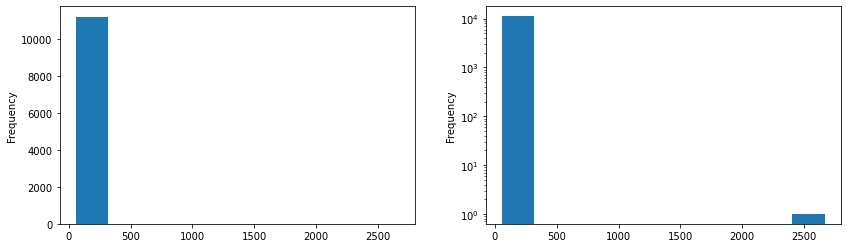

count    1.122300e+04
mean     8.013963e+08
std      4.165276e+08
min      5.276967e+07
5%       5.276967e+07
25%      1.012361e+09
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioCreacion, dtype: float64

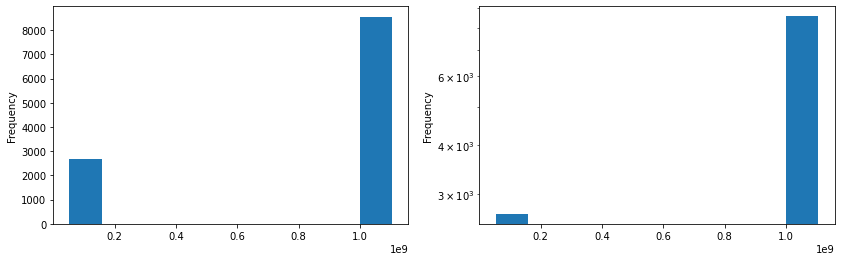

count    11223.000000
mean         7.162969
std          2.271356
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolCreacion, dtype: float64

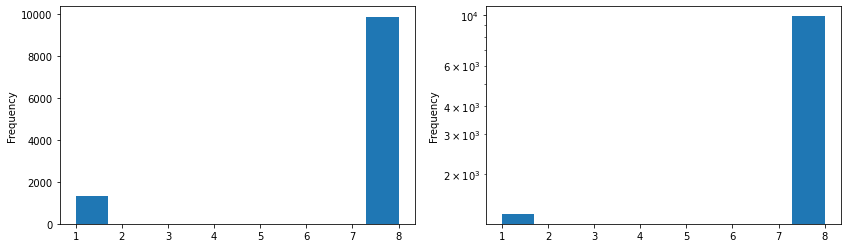

count     6737.000000
mean       328.788185
std        997.219590
min          0.000000
5%           0.000000
25%         43.000000
50%        116.000000
75%        274.000000
95%        938.000000
99%       6288.280000
max      20085.000000
Name: T_Real_SolicitadoRegistrado, dtype: float64

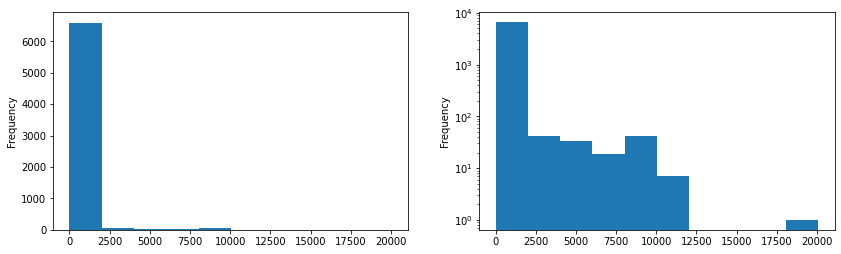

count    11223.000000
mean         5.951617
std        136.565443
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%          0.000000
max       7286.000000
Name: T_Real_RegistradoEscalado, dtype: float64

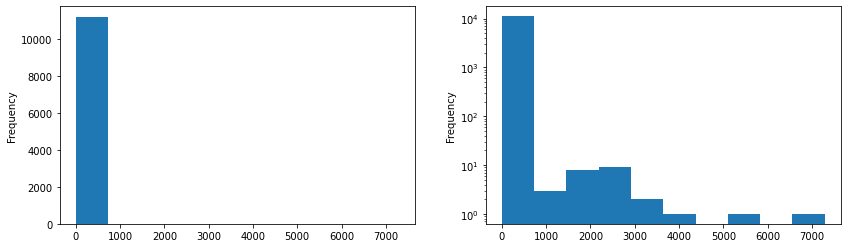

count       842.000000
mean     719117.971496
std       61793.713903
min      583910.000000
5%       635729.400000
25%      676056.000000
50%      706288.500000
75%      760445.000000
95%      839252.400000
99%      852704.740000
max      855136.000000
Name: fdp_IdHistoricoPqrEscalamientoN2, dtype: float64

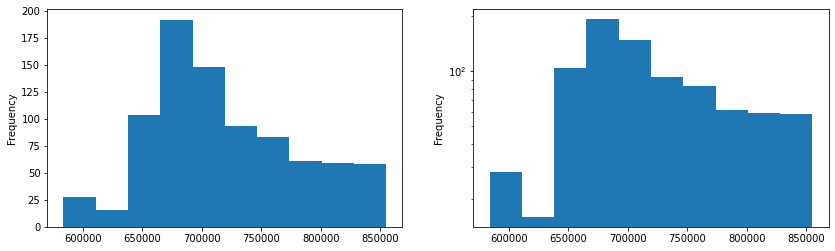

count    842.000000
mean     534.004751
std        0.068802
min      534.000000
5%       534.000000
25%      534.000000
50%      534.000000
75%      534.000000
95%      534.000000
99%      534.000000
max      535.000000
Name: fdp_IdGrupoEscalamientoN2, dtype: float64

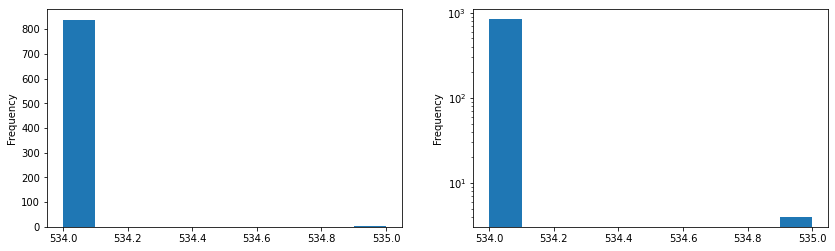

count     842.000000
mean     1408.011876
std         0.145815
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1408.000000
99%      1408.000000
max      1410.000000
Name: fdp_IdDetalleFlujoEscalamientoN2, dtype: float64

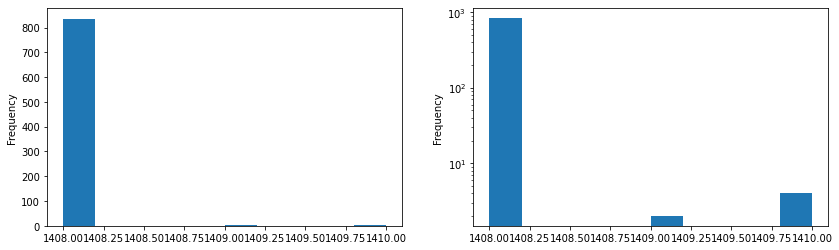

count     833.000000
mean      910.601441
std       858.602529
min       125.000000
5%        370.000000
25%       455.000000
50%       553.000000
75%       682.000000
95%      2761.000000
99%      2761.000000
max      2761.000000
Name: fdp_IdUsuarioEscalamientoN2, dtype: float64

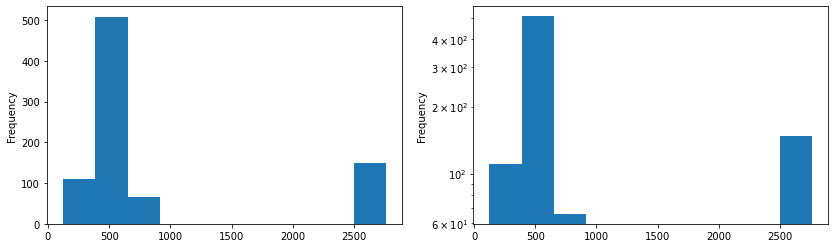

count    8.330000e+02
mean     2.045782e+08
std      3.436955e+08
min      1.386082e+07
5%       3.542411e+07
25%      5.200607e+07
50%      6.033386e+07
75%      8.003256e+07
95%      1.032384e+09
99%      1.032384e+09
max      1.075685e+09
Name: fdp_UsuarioEscalamientoN2, dtype: float64

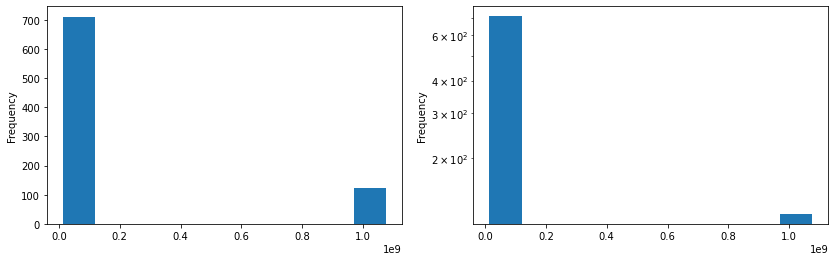

count    833.000000
mean       6.162065
std        0.387796
min        3.000000
5%         6.000000
25%        6.000000
50%        6.000000
75%        6.000000
95%        7.000000
99%        7.000000
max        7.000000
Name: CodigoGrupoRolEscalamientoN2, dtype: float64

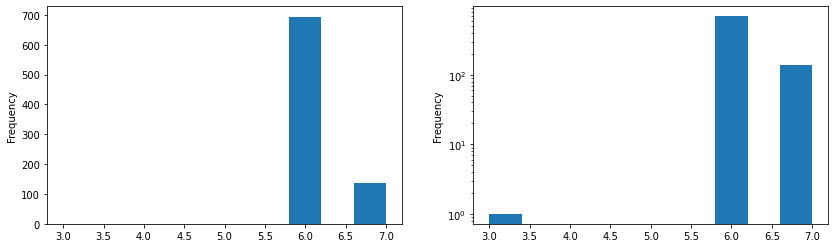

count     842.0
mean     2700.0
std         0.0
min      2700.0
5%       2700.0
25%      2700.0
50%      2700.0
75%      2700.0
95%      2700.0
99%      2700.0
max      2700.0
Name: T_Objetivo_EnNivel2, dtype: float64

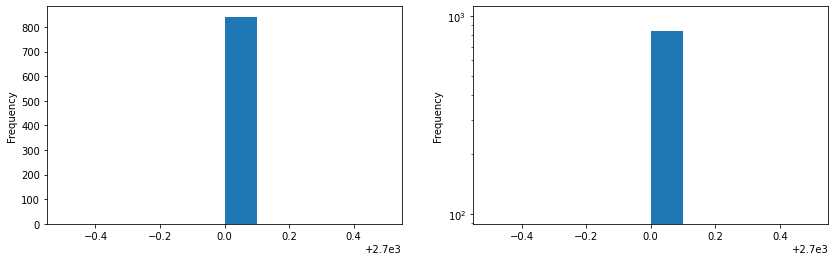

count    10691.000000
mean        55.452904
std        421.544615
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%       2133.900000
max       9720.000000
Name: T_Real_EnNivel2, dtype: float64

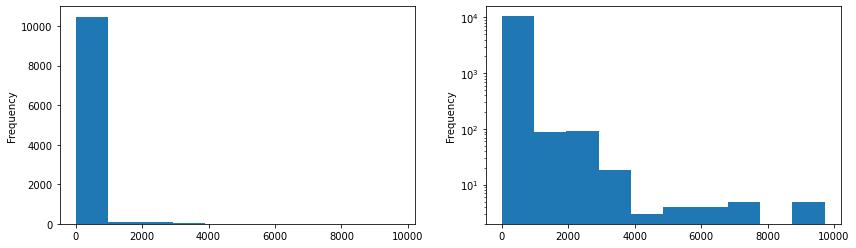

count        27.000000
mean     716898.851852
std       63884.639750
min      637444.000000
5%       671037.300000
25%      671507.500000
50%      675653.000000
75%      746265.500000
95%      835533.900000
99%      849657.120000
max      852813.000000
Name: fdp_IdHistoricoPqrDevolucion, dtype: float64

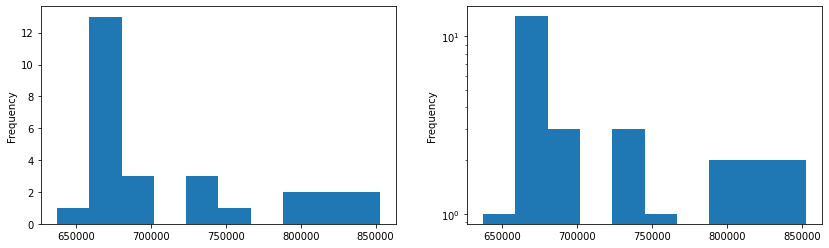

count     27.000000
mean     120.481481
std       38.143827
min       65.000000
5%        65.000000
25%       65.000000
50%      147.000000
75%      151.000000
95%      151.000000
99%      151.000000
max      151.000000
Name: fdp_IdUsuarioDevolucion, dtype: float64

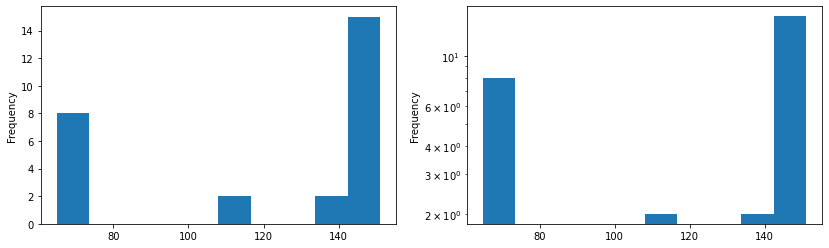

count    2.700000e+01
mean     7.381329e+08
std      4.531209e+08
min      5.291254e+07
5%       5.291254e+07
25%      5.291254e+07
50%      1.026290e+09
75%      1.030580e+09
95%      1.030580e+09
99%      1.030580e+09
max      1.030580e+09
Name: fdp_UsuarioDevolucion, dtype: float64

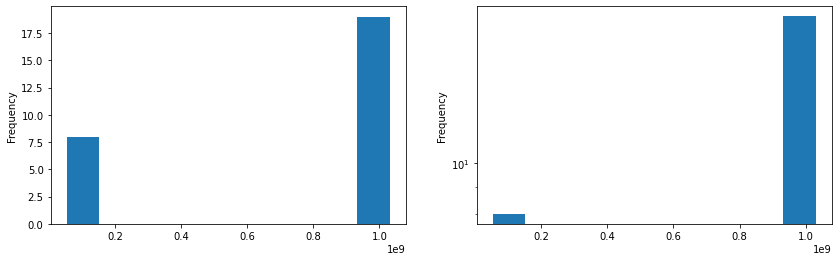

count    27.000000
mean      6.444444
std       2.965615
min       1.000000
5%        1.000000
25%       8.000000
50%       8.000000
75%       8.000000
95%       8.000000
99%       8.000000
max       8.000000
Name: CodigoGrupoRolDevolucion, dtype: float64

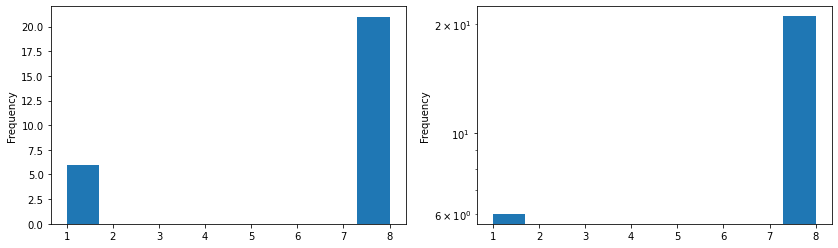

count     10716.000000
mean      24456.637925
std      131624.095225
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%           4.000000
99%      770110.700000
max      852933.000000
Name: fdp_IdHistoricoPqrSolucion, dtype: float64

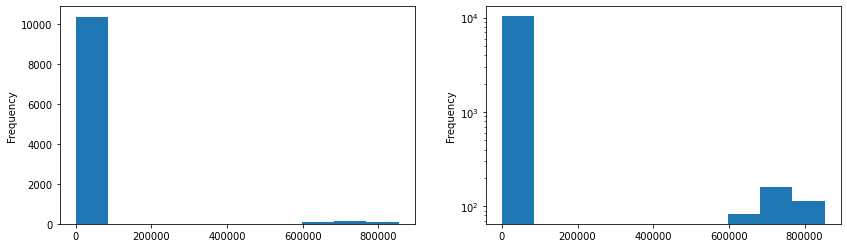

count    10716.000000
mean        17.813550
std         95.579785
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%        534.000000
max        534.000000
Name: fdp_IdGrupoSolucion, dtype: float64

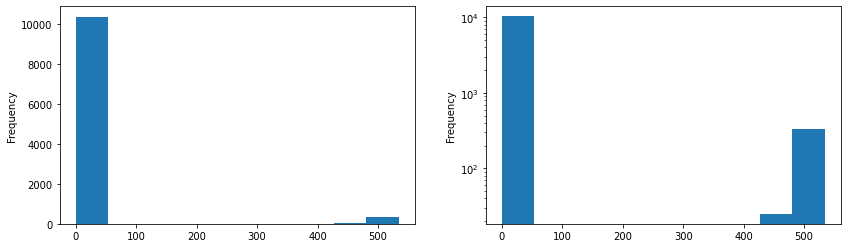

count     360.000000
mean     1408.075000
std         0.263758
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1409.000000
99%      1409.000000
max      1409.000000
Name: fdp_IdDetalleFlujoSolucion, dtype: float64

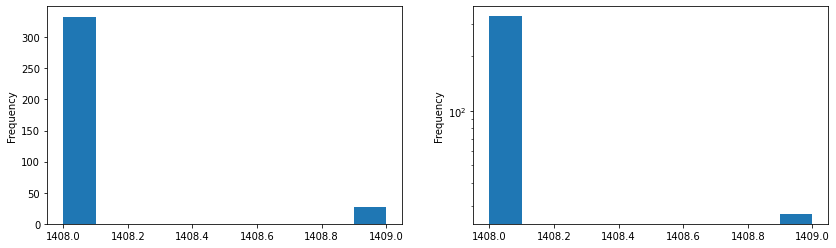

count    10716.000000
mean       135.684677
std         84.546224
min         57.000000
5%          57.000000
25%        103.000000
50%        140.000000
75%        151.000000
95%        187.000000
99%        625.000000
max       2666.000000
Name: fdp_IdUsuarioSolucion, dtype: float64

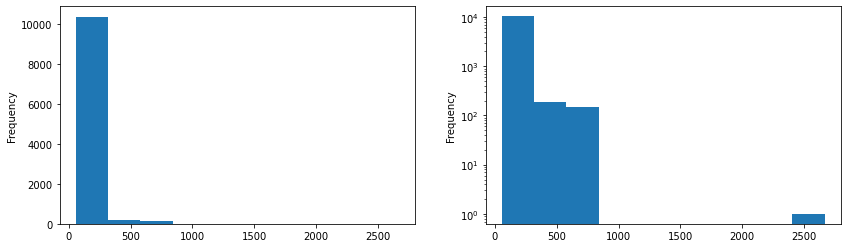

count    1.071600e+04
mean     7.957149e+08
std      4.204933e+08
min      5.200607e+07
5%       5.276967e+07
25%      1.012361e+09
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioSolucion, dtype: float64

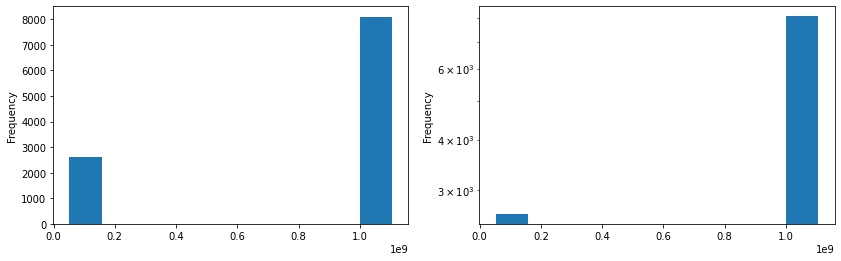

count    10716.000000
mean         7.154909
std          2.211176
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolSolucion, dtype: float64

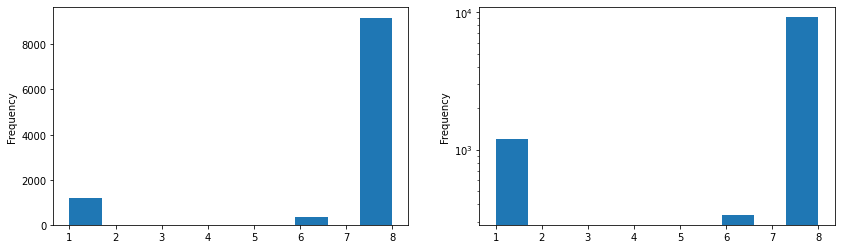

count     10716.000000
mean      24456.671706
std      131624.275869
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%           4.000000
99%      770111.700000
max      852934.000000
Name: fdp_IdHistoricoPqrCierre, dtype: float64

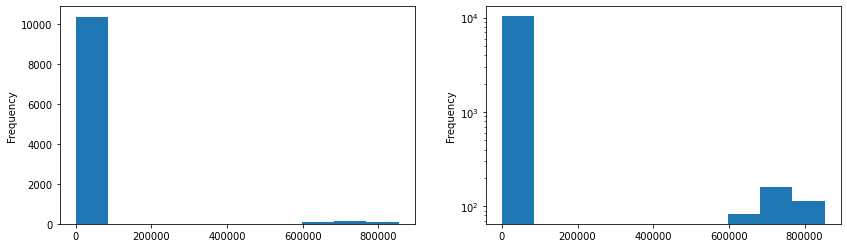

count    10716.000000
mean        17.813550
std         95.579785
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%        534.000000
max        534.000000
Name: fdp_IdGrupoCierre, dtype: float64

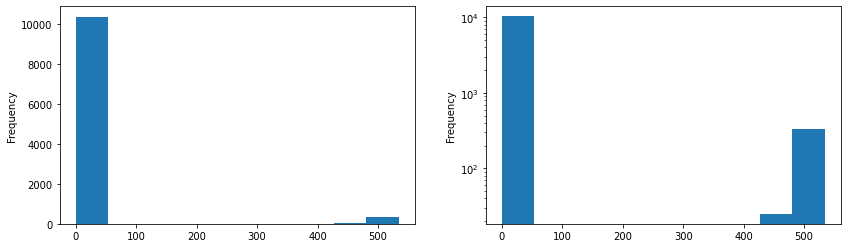

count     360.000000
mean     1408.075000
std         0.263758
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1409.000000
99%      1409.000000
max      1409.000000
Name: fdp_IdDetalleFlujoCierre, dtype: float64

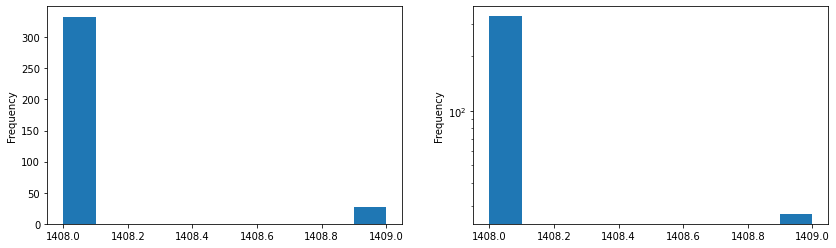

count    10716.000000
mean       135.684677
std         84.546224
min         57.000000
5%          57.000000
25%        103.000000
50%        140.000000
75%        151.000000
95%        187.000000
99%        625.000000
max       2666.000000
Name: fdp_IdUsuarioCierre, dtype: float64

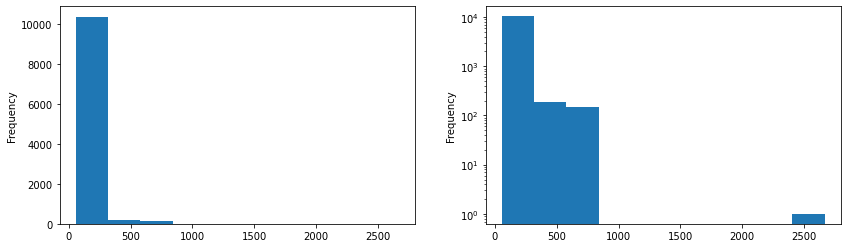

count    1.071600e+04
mean     7.957149e+08
std      4.204933e+08
min      5.200607e+07
5%       5.276967e+07
25%      1.012361e+09
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioCierre, dtype: float64

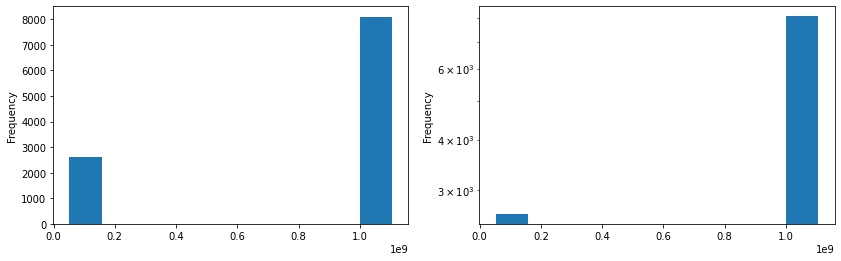

count    10716.000000
mean         7.154909
std          2.211176
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolCierre, dtype: float64

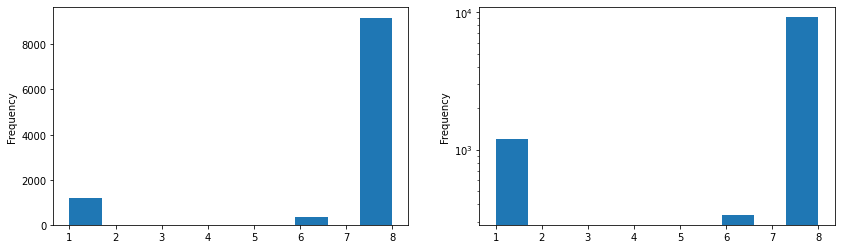

count     842.0
mean     2700.0
std         0.0
min      2700.0
5%       2700.0
25%      2700.0
50%      2700.0
75%      2700.0
95%      2700.0
99%      2700.0
max      2700.0
Name: T_Objetivo_Total, dtype: float64

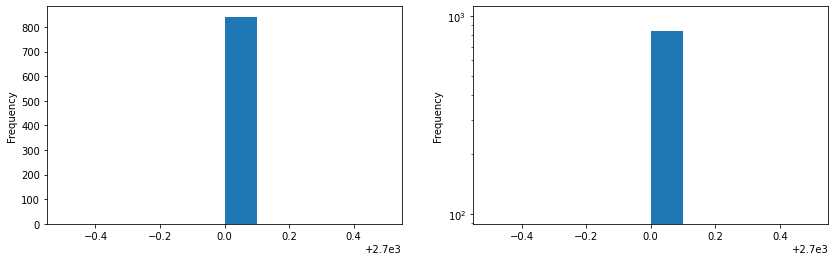

count     11223.000000
mean      55904.296267
std      193974.630976
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%      689395.800000
99%      806621.320000
max      855136.000000
Name: fdp_IdHistoricoPqrGestionActual, dtype: float64

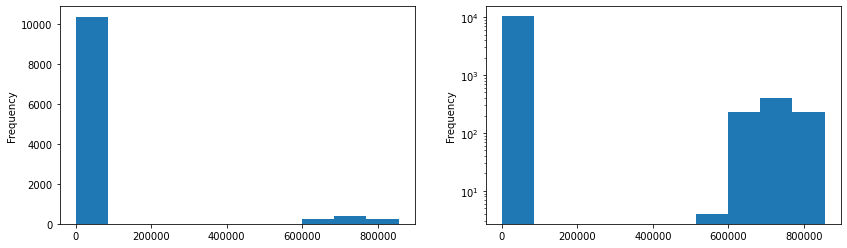

count    11223.000000
mean        41.132674
std        142.187217
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%        534.000000
99%        534.000000
max        535.000000
Name: fdp_IdGrupoGestionActual, dtype: float64

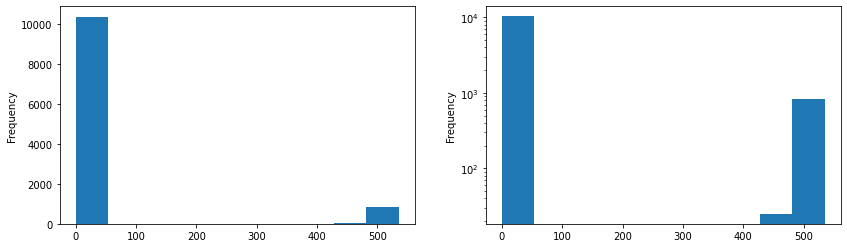

count     867.000000
mean     1408.040369
std         0.219139
min      1408.000000
5%       1408.000000
25%      1408.000000
50%      1408.000000
75%      1408.000000
95%      1408.000000
99%      1409.000000
max      1410.000000
Name: fdp_IdDetalleFlujoGestionActual, dtype: float64

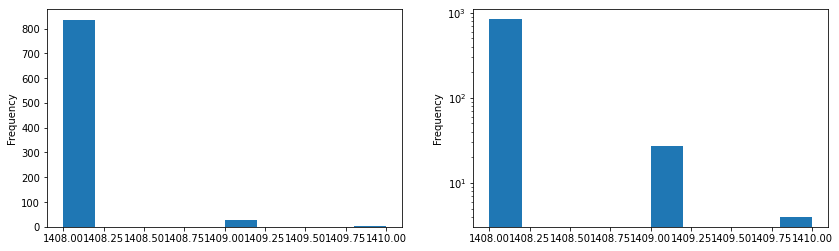

count    11221.000000
mean       182.328402
std        316.095934
min         57.000000
5%          57.000000
25%        103.000000
50%        140.000000
75%        151.000000
95%        455.000000
99%       2761.000000
max       2761.000000
Name: fdp_IdUsuarioGestionActual, dtype: float64

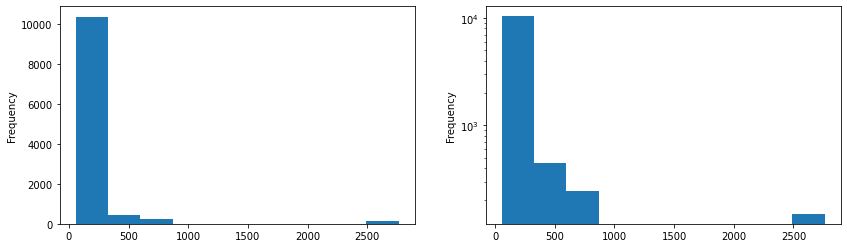

count    1.122100e+04
mean     7.639333e+08
std      4.374684e+08
min      1.386082e+07
5%       5.276967e+07
25%      8.003256e+07
50%      1.022977e+09
75%      1.026290e+09
95%      1.105787e+09
99%      1.105787e+09
max      1.105787e+09
Name: fdp_UsuarioGestionActual, dtype: float64

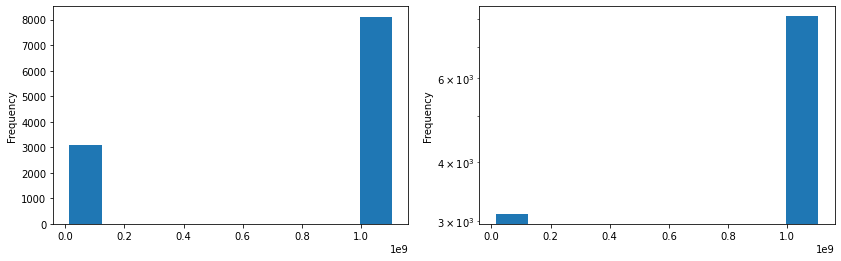

count    11221.000000
mean         7.114963
std          2.170941
min          1.000000
5%           1.000000
25%          8.000000
50%          8.000000
75%          8.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: CodigoGrupoRolGestionActual, dtype: float64

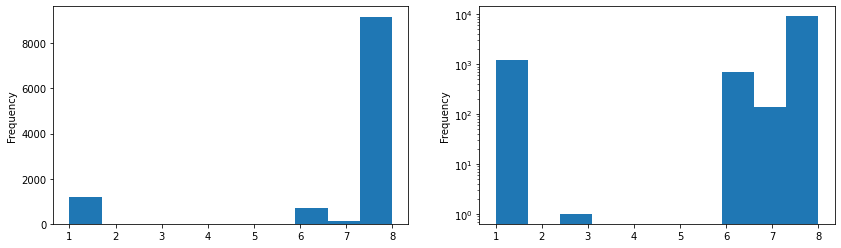

In [ ]:


for i in numeros.columns:
  plt.figure(figsize=(14,4))
  display(numeros[i].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99]))
  plt.subplot(1,2,1)
  numeros[i].plot.hist()
  plt.subplot(1,2,2)
  numeros[i].plot.hist()
  plt.yscale('log')
  
  
  plt.show()


# REVISION DE NIVELES Y INFORMACUION USUARIO

In [ ]:
niveles =df_Registros_OF[['fgs_Nivel2','fgs_Nivel3','fgs_Nivel4']].copy()
niveles.head(2)

,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4
0,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit
1,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit


In [ ]:
niveles['union']  =  niveles['fgs_Nivel2']+'_*_'+niveles['fgs_Nivel3']+'_*_'+niveles['fgs_Nivel4']
niveles['union'].value_counts()#Revisar extremo derecho, realmente se econtro que nivel1 y 2 no aportan.

Recepción y contabilización facturas de proveedores_*_Causación de facturas / Cockpit_*_Causación de facturas / Cockpit                                                                  7939
Recepción y contabilización facturas de proveedores_*_Radicación de facturas_*_Radicación de facturas                                                                                    1457
Recepción y contabilización facturas de proveedores_*_Información y Seguimiento a usuarios en página WEB Proveedores_*_Información y Seguimiento a usuarios en página WEB Proveedores    1361
Recepción y contabilización facturas de proveedores_*_Endoso de facturas_*_Endoso de facturas                                                                                             181
Recepción y contabilización facturas de proveedores_*_Retención en Garantía_*_Retención en Garantía                                                                                       133
Recepción y contabilización facturas de proveedore

In [ ]:
niveles['union']  =niveles['fgs_Nivel3']+'_*_'+niveles['fgs_Nivel4']
niveles['union'].value_counts()

Causación de facturas / Cockpit_*_Causación de facturas / Cockpit                                                                  7939
Radicación de facturas_*_Radicación de facturas                                                                                    1457
Información y Seguimiento a usuarios en página WEB Proveedores_*_Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas_*_Endoso de facturas                                                                                             181
Retención en Garantía_*_Retención en Garantía                                                                                       133
Consultas retenciones aplicadas_*_Consultas retenciones aplicadas                                                                   102
Pagos bloqueados_*_Pagos bloqueados                                                                                                  50
Name: union, dtype: int64

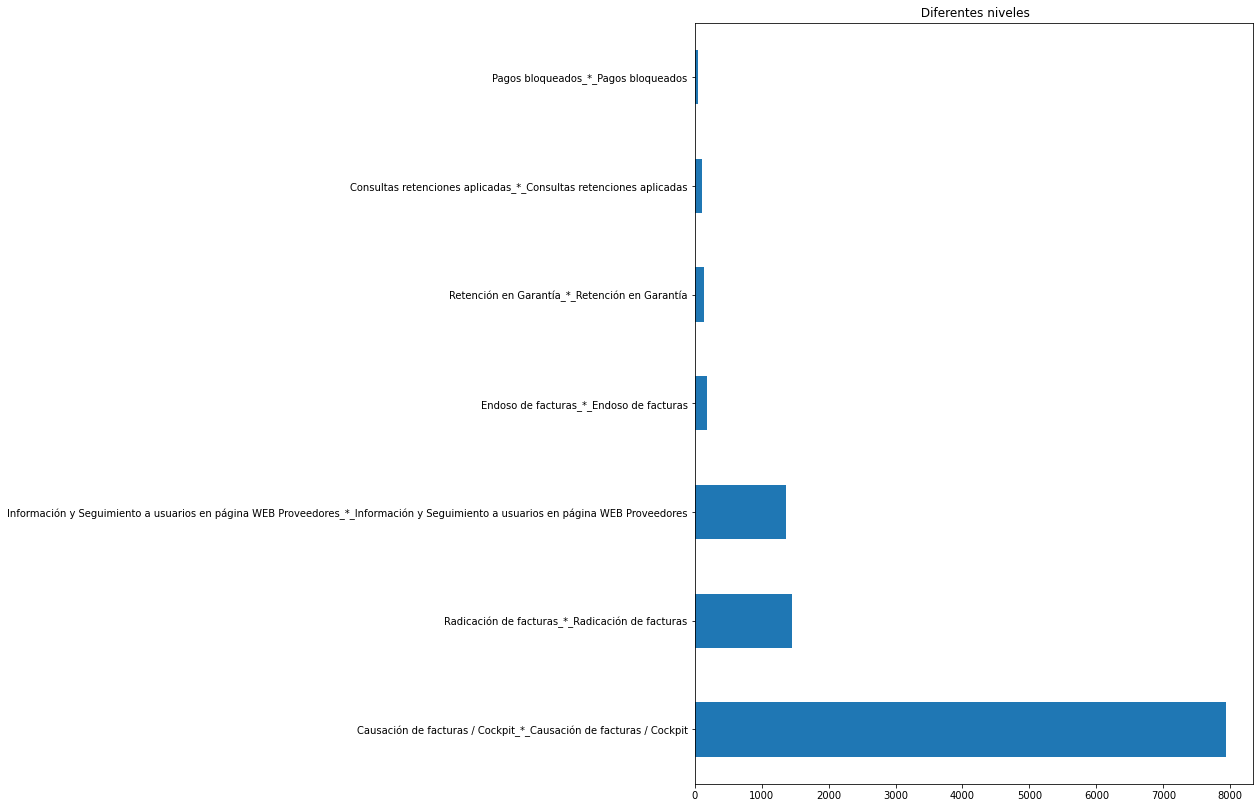

In [ ]:

niveles['union'].value_counts().plot.barh(title = ' Diferentes niveles',figsize = (10,14))

In [ ]:
niveles['fgs_Nivel3'].value_counts()

Causación de facturas / Cockpit                                   7939
Radicación de facturas                                            1457
Información y Seguimiento a usuarios en página WEB Proveedores    1361
Endoso de facturas                                                 181
Retención en Garantía                                              133
Consultas retenciones aplicadas                                    102
Pagos bloqueados                                                    50
Name: fgs_Nivel3, dtype: int64

In [ ]:
(niveles['fgs_Nivel3'].value_counts()/niveles.shape[0]*100)

Causación de facturas / Cockpit                                   70.738662
Radicación de facturas                                            12.982269
Información y Seguimiento a usuarios en página WEB Proveedores    12.126882
Endoso de facturas                                                 1.612760
Retención en Garantía                                              1.185066
Consultas retenciones aplicadas                                    0.908848
Pagos bloqueados                                                   0.445514
Name: fgs_Nivel3, dtype: float64

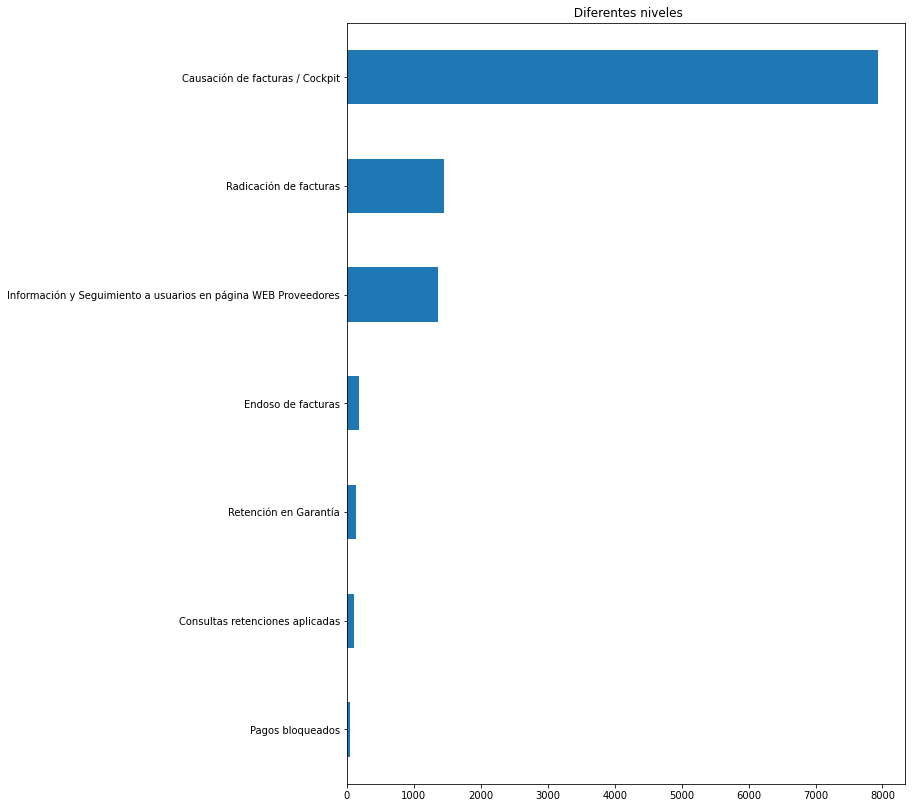

In [ ]:
niveles['fgs_Nivel3'].value_counts().sort_values(ascending=True).plot.barh(title = ' Diferentes niveles',figsize = (10,14))

In [ ]:
# correlacion


In [ ]:
objetos.head(2)

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,fgs_FechaFin,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,fgs_Email_01,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fmf_FechaSolicitud,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,fdp_FechaCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,fdp_FechaEscalamientoN2,fdp_FechaVencimientoEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,fdp_FechaDevolucion,fdp_FechaVencimientoDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,fdp_FechaCierre,fdp_FechaVencimientoCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,GrupoRolGestionActual,fdp_NivelGestionActual,TipoAjuste,fdp_FechaVencimientoTotal
0,NIT,METROOMAT NDT SAS,172.27.90.93,2021-03-01 06:08:30.000,2021-03-01 06:10:58.000,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,CR 52 44 A 35,"BOGOTA, D.C.",BOGOTA,Colombia,8023687,xiomara.rodriguez@metroomat.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,nestor.pantano@metroomat.com,Transacciones,Causación de facturas / Cockpit,2021-02-26 11:27:00.000,Cerrado,Nivel1,LAURA MAYERLY BOHORQUEZ GAMBA,Con la presente solicito su colaboración confi...,2021-03-01 06:10:58.000,Asesor de Servicio Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Se informa que para poder dar respuesta a su r...,2021-03-01 06:10:58.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Fecha Superior a la fecha de creación o Fecha ...,2021-03-01 09:45:00.000
1,NIT,CGG SERVICES SUCUSAL COLOMBIA,172.27.90.93,2021-03-01 06:15:54.000,2021-03-01 06:27:09.000,Contacto,Cuentas por pagar,Recepción y contabilización facturas de provee...,Causación de facturas / Cockpit,Causación de facturas / Cockpit,AV CR 45 108 A 50 P 6,"BOGOTA, D.C.",BOGOTA,Colombia,7430946,carlos.chaparro@cgg.com,Email BackOffice,CENTRO ORIENTE,"BOGOTA, D.C.",BOGOTA,COLOMBIA,NaN,NaN,NaN,carlos.chaparro@cgg.com,Puesto de Trabajo,Causación de facturas / Cockpit,2021-02-26 11:43:00.000,Cerrado,Nivel1,JEIMY YOLIMA ARDILA PINZON,"Buenos días, el pasado 21d e enero la empresa ...",2021-03-01 06:27:09.000,Asesor de Servicio BackOffice Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Se solicita filtro de seguridad,2021-03-01 06:27:09.000,2020-02-25 16:30:00.000,Asesor de Servicio BackOffice Contact Center,Nivel1,Cumple,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDIL

In [ ]:
mapas_nofechas = objetos.columns.str.findall('Fecha').map(lambda x : len(x)==0)# eliminar fecha dataset sin columnas de fechas
objetos_nofechas = objetos[objetos.columns[mapas_nofechas]]

In [ ]:
# objetos_nofechas.head()

In [ ]:
# objetos_nofechas.columns

## Revision para columnas con texto de interes.

In [ ]:
importa =objetos[['fgs_Nivel3','fgs_ObservacionCreacion','fgs_ObservacionSolucion']] # variables de interes

In [ ]:
%%time
importa['fgs_ObservacionCreacion'].str.split().str.len()

CPU times: user 55.8 ms, sys: 8.99 ms, total: 64.8 ms
Wall time: 71 ms


0        34
1        59
2        76
3         3
4         3
         ..
11219    35
11220     8
11221    28
11222     5
11223    13
Name: fgs_ObservacionCreacion, Length: 11223, dtype: int64

In [ ]:
importa['fgs_ObservacionSolucion'].map(lambda x : type(x)).value_counts()# HAY variables numericas: valores vacios(29) explicacion a continuacion.

<class 'str'>      10716
<class 'float'>      507
Name: fgs_ObservacionSolucion, dtype: int64

In [ ]:
mapa = importa['fgs_ObservacionSolucion'].map(lambda x : type(x))==float

In [ ]:
importa[mapa]## no hay solucion por que puede que se le diera solucion directa al cliente. :( )

,fgs_Nivel3,fgs_ObservacionCreacion,fgs_ObservacionSolucion
2,Causación de facturas / Cockpit,Gestion.<br>Atendiendo su solicitud le informa...,NaN
30,Causación de facturas / Cockpit,GESTIÓN: Su caso se escaló al área encargada p...,NaN
66,Causación de facturas / Cockpit,Gestion.<br>Atendiendo su solicitud le informa...,NaN
102,Causación de facturas / Cockpit,Su caso se escaló al área encargada para su tr...,NaN
147,Causación de facturas / Cockpit,"Buen día, se escala para su amable gestión. Se...",NaN
...,...,...,...
10620,Causación de facturas / Cockpit,GESTIÓN: Su caso se escaló al área encargada p...,NaN
10632,Causación de facturas / Cockpit,Atendiendo su solicitud le informamos que hemo...,NaN
10647,Causación de facturas / Cockpit,Su caso se escaló al área encargada para su tr...,NaN
10667,Radicación de facturas,Atendiendo su solicitud le informamos que hemo...,NaN


In [ ]:
importasina = importa.dropna().copy()

In [ ]:
importasina['fgs_ObservacionCreacion_cantidad_palabras'] = importasina['fgs_ObservacionCreacion'].map(lambda x : len(x.split())).copy()

In [ ]:
importasina['fgs_ObservacionSolucion_cantidad_palabras'] = importasina['fgs_ObservacionSolucion'].copy().map(lambda x : len(x.split()))

In [ ]:
importasina[['fgs_ObservacionCreacion_cantidad_palabras','fgs_ObservacionSolucion_cantidad_palabras']].corr()

,fgs_ObservacionCreacion_cantidad_palabras,fgs_ObservacionSolucion_cantidad_palabras
fgs_ObservacionCreacion_cantidad_palabras,1.00000,0.10671
fgs_ObservacionSolucion_cantidad_palabras,0.10671,1.00000


In [ ]:
importasina[['fgs_ObservacionCreacion_cantidad_palabras','fgs_ObservacionSolucion_cantidad_palabras']].corr(method='spearman')

,fgs_ObservacionCreacion_cantidad_palabras,fgs_ObservacionSolucion_cantidad_palabras
fgs_ObservacionCreacion_cantidad_palabras,1.000000,0.210708
fgs_ObservacionSolucion_cantidad_palabras,0.210708,1.000000


In [ ]:
# importasina['fgs_ObservacionCreacion_cantidad_palabras'].map(lambda x: x.replace('<br>',' '))

In [ ]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' '))

0        Con la presente solicito su colaboración confi...
1        Buenos días, el pasado 21d e enero la empresa ...
3                                    CONSULTA DE FACTURAS 
4                                    CONSULTA DE FACTURAS 
5               Solicita información de estado de factura 
                               ...                        
11219     Agradecemos su atención y nos permitimos envi...
11220    Srs Ecopetrol solicitó el desbloqueo del usuar...
11221    Amablemente informo que luego de ingresar el n...
11222                   DESBLOQUEO USUARIO PORTAL DE PAGOS
11223    Conforme a las indicaciones brindadas, informa...
Name: fgs_ObservacionCreacion, Length: 10716, dtype: object

In [ ]:
importasina['fgs_ObservacionCreacion'][importasina['fgs_ObservacionCreacion'].str.findall('<br>').map(lambda x: len(x)>0)]

76       Buen día, se escala para su amable gestión. Se...
79       Buen día, se escala para su amable gestión. Se...
126       Se envía notificación vía correo electrónico<br>
172      ACREEDOR\t3002388<br>NOMBRE\tIMPORTACIONES IND...
185      GESTIÓN: Su caso se escaló al área encargada p...
                               ...                        
10397    Atendiendo su solicitud le informamos que hemo...
10461    Atendiendo su solicitud le informamos que hemo...
10505    GESTIÓN:<br>Atendiendo su solicitud le informa...
10557    Atendiendo su solicitud le informamos que hemo...
10907    le informamos que para poder dar respuesta a s...
Name: fgs_ObservacionCreacion, Length: 393, dtype: object

In [ ]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' '))[importasina['fgs_ObservacionCreacion'].str.findall('<br>').map(lambda x: len(x)>0)]
#revsion de limpiezA

76       Buen día, se escala para su amable gestión. Se...
79       Buen día, se escala para su amable gestión. Se...
126          Se envía notificación vía correo electrónico 
172      ACREEDOR\t3002388 NOMBRE\tIMPORTACIONES INDUST...
185      GESTIÓN: Su caso se escaló al área encargada p...
                               ...                        
10397    Atendiendo su solicitud le informamos que hemo...
10461    Atendiendo su solicitud le informamos que hemo...
10505    GESTIÓN: Atendiendo su solicitud le informamos...
10557    Atendiendo su solicitud le informamos que hemo...
10907    le informamos que para poder dar respuesta a s...
Name: fgs_ObservacionCreacion, Length: 393, dtype: object

In [ ]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' ')).value_counts()

CONSULTA DE FACTURAS                                                                                                                                                                                                                                                                                           1036
Solicita información de estado de factura                                                                                                                                                                                                                                                                       486
Solicita acceso al portal proveedores                                                                                                                                                                                                                                                                            83
Solicita desbloqueo de usuario portal proveedores                           

In [ ]:
importasina['fgs_ObservacionSolucion'].map(lambda x: x.replace('<br>',' ')).value_counts()

Se envía notificación vía correo electrónico                                                                                                                                                                                                                                                                                              426
GESTIÓN: Atendiendo su solicitud le informamos que hemos enviado requerimiento al área encargada para que se verifique este caso y sea solucionado lo más pronto posible.                                                                                                                                                                 124
Atendiendo su solicitud le informamos que hemos enviado requerimiento al área encargada para que se verifique este caso y sea solucionado lo más pronto posible.                                                                                                                                                                          10

In [ ]:
### DE LO ANTERIOR SE ENTIENDE QUE HAY ALGUNOS ELEMENTOS REPETIDOS , PERO EN GENERAR HAY VARIANZA EN LO QUE SE ESCRIBE.PUEDE QUE EXISTA UN LIBRETO, PERO AL PARECE HAY ELEMENTOS ADICIONALES. 

In [ ]:
nombres_columnas = pd.Series(df_Registros_OF.columns)
columnas_con_nombre = nombres_columnas [nombres_columnas.map(lambda x :x.lower()).str.findall('nombre').map(lambda x : len(x)>0)]


In [ ]:
columnas_con_nombre.to_list()

['fgs_NombreCompletoContacto',
 'fdp_NombreEstado',
 'fdp_NombreUsuarioCreacion',
 'fdp_NombreGrupoEscalamientoN2',
 'fdp_NombreUsuarioEscalamientoN2',
 'fdp_NombreUsuarioDevolucion',
 'fdp_NombreGrupoSolucion',
 'fdp_NombreUsuarioSolucion',
 'fdp_NombreGrupoCierre',
 'fdp_NombreUsuarioCierre',
 'fdp_NombreGrupoGestionActual',
 'fdp_NombreUsuarioGestionActual']

In [ ]:
nombres_columnas = pd.Series(df_Registros_OF.columns)
columnas_con_nombre = nombres_columnas [nombres_columnas.map(lambda x :x.lower()).str.findall('fecha').map(lambda x : len(x)>0)]


In [ ]:
# columnas_con_nombre.to_list() # COLUMNAS QUE CONTIENE EL NOMBRE FECHA

In [ ]:
#FILTRO PO RINFORMACION QUE PUEDE SER RELEVANTE
info_usuarios = df_Registros_OF[['fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto','fgs_FechaInicio',
                'fgs_NombreCompletoContacto',
 'fdp_NombreEstado',
 'fdp_NombreUsuarioCreacion',
 'fdp_NombreGrupoEscalamientoN2',
 'fdp_NombreUsuarioEscalamientoN2',
 'fdp_NombreUsuarioDevolucion',
 'fdp_NombreGrupoSolucion',
 'fdp_NombreUsuarioSolucion',
 'fdp_NombreGrupoCierre',
 'fdp_NombreUsuarioCierre',
 'fdp_NombreGrupoGestionActual',
 'fdp_NombreUsuarioGestionActual',
 'fdp_FechaCreacion']].copy()

In [ ]:
info_usuarios.head(2)

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion
0,NIT,9003104584,2021-03-01 06:08:30.000,METROOMAT NDT SAS,Cerrado,LAURA MAYERLY BOHORQUEZ GAMBA,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,2021-03-01 06:10:58.000
1,NIT,9001358397,2021-03-01 06:15:54.000,CGG SERVICES SUCUSAL COLOMBIA,Cerrado,JEIMY YOLIMA ARDILA PINZON,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,2021-03-01 06:27:09.000


## CARGUE DE LA INFORMACION MARCO COMUN UNIVERSAL

In [ ]:
info_clientes = pd.read_csv('Info_clientes.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,24,27,29,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
info_clientes.head(2)

,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
0,1,1006775793,CC,1,QUEVEDO BETANCOURT BRAYAN ALEJANDRO,CL 6 14 09 BRR EL CENTRO,NaN,CASTILLA LA NUEVA,689.0,NaN,META,16.0,COLOMBIA,1.0,03/01/2000,MASCULINO,BRAYAN.QUEVEDO@ECOPETROL.COM.CO,3024614518,3024614518,NaN,NaN,SOLTERO,LLANOS ORIENTALES,50150,NaN,PR6592,ESTACION DE TRATAMIENTO CASTILLA 2,32020197,ACACIAS,20,OPERADORA DE PLANTA,COL,NaN,282708,50,10000196
1,2,1006776140,CC,1,BERMUDEZ SANTA DANIEL SANTIAGO,CL. 27#43A-78 MZ C CS 39 CONJUNTO RINCÓN DEL B...,NaN,"BOGOTA, D.C.",149.0,BOGOTA,BOGOTA,3.0,COLOMBIA,1.0,8-10-2000,MASCULINO,NaN,986688094,NaN,NaN,NaN,NaN,CENTRO ORIENTE,50001,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,104035,NaN,NaN


In [ ]:
info_clientes.columns

Index(['ID', 'N_DOCUMENTO', 'TIPO_DOCUMENTO', 'IdTipoDoc', 'NOMBRE_COMPLETO',
       'DIRECCION', 'DIRECCION_2', 'CIUDAD', 'IdCiudad', 'CIUDAD_SUCURSAL',
       'DEPARTAMENTO', 'IdDepto', 'PAIS', 'IdPais', 'FECHA_NACIMIENTO', 'SEXO',
       'CORREO_ELECT', 'TELEFONO_1', 'TELEFONO_2', 'TEL_CELULAR', 'TEL_FIJO',
       'ECIVIL', 'REGIONAL_GSC', 'CDFPR', 'CECOSTE', 'CECO', 'CE_COSTE',
       'CODIGO_POSICION', 'DESCRIPCIÓN_SUCURSAL', 'SUCURSAL', 'POSICION', 'PS',
       'RAZON_SOCIAL', 'REGISTRO', 'RG', 'UN_ORG'],
      dtype='object')

In [ ]:
# info_usuarios['fgs_NumeroDocumContacto'] = info_usuarios['fgs_NumeroDocumContacto'].astype('O')

In [ ]:
info_clientes.columns

Index(['ID', 'N_DOCUMENTO', 'TIPO_DOCUMENTO', 'IdTipoDoc', 'NOMBRE_COMPLETO',
       'DIRECCION', 'DIRECCION_2', 'CIUDAD', 'IdCiudad', 'CIUDAD_SUCURSAL',
       'DEPARTAMENTO', 'IdDepto', 'PAIS', 'IdPais', 'FECHA_NACIMIENTO', 'SEXO',
       'CORREO_ELECT', 'TELEFONO_1', 'TELEFONO_2', 'TEL_CELULAR', 'TEL_FIJO',
       'ECIVIL', 'REGIONAL_GSC', 'CDFPR', 'CECOSTE', 'CECO', 'CE_COSTE',
       'CODIGO_POSICION', 'DESCRIPCIÓN_SUCURSAL', 'SUCURSAL', 'POSICION', 'PS',
       'RAZON_SOCIAL', 'REGISTRO', 'RG', 'UN_ORG'],
      dtype='object')

In [ ]:
print(info_usuarios.shape)
x = info_usuarios.merge(right=info_clientes,how='left', left_on='fgs_NumeroDocumContacto',right_on='N_DOCUMENTO')
print(info_usuarios.shape, x.shape)

(11223, 16)
(11223, 16) (11223, 52)


In [ ]:
x[x['fgs_NumeroDocumContacto'].duplicated(keep=False)].sort_values(by = 'fgs_NumeroDocumContacto')

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
5159,NIT,100,2021-03-19 09:54:47.000,Anonimo,Cerrado,JEIMY NATHALY GOMEZ GOMEZ,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,2021-03-19 10:04:25.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10664,CC,100,2021-05-03 15:23:27.000,Anonimo,Cerrado,CLAUDIA MARCELA PINEDA,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINEDA,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINEDA,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINEDA,2021-05-03 15:26:59.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5078,CC,100,2021-03-17 09:07:56.000,Anonimo,Cerrado,CLAUDIA MARCELA PINEDA,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINEDA,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINEDA,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINEDA,2021-03-17 09:10:34.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5235,NIT,100,2021-03-24 09:05:47.000,Anonimo,Cerrado,JEIMY NATHALY GOMEZ GOMEZ,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,2021-03-24 09:13:28.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3325,NIT,100,2021-03-29 14:14:04.000,Anonimo,Cerrado,JEIMY NATHALY GOMEZ GOMEZ,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,2021-03-29 14:16:31.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,NIT,8226125000146,2021-04-19 14:14:56.000,ICTS GLOBAL SERVICOS DE CONSULTORIA EM GESTAO ...,Cerrado,JEIMY NATHALY GOMEZ GOMEZ,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,Grupo Primer Nivel Operaciones Financieras,JEIMY NATHALY GOMEZ GOMEZ,2021-04-19 14:30:04.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9671,NIT,8226125000146,2021-05-18 10:30:13.000,ICTS GLOBAL SERVICOS DE CONSULTORIA EM GESTAO ...,Cerrado,CLAUDIA MARCELA PINEDA,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,CLAUDIA MARCELA PINE

In [ ]:
# info_usuarios['fgs_NumeroDocumContacto'].astype('O')

In [ ]:
info_clientes['N_DOCUMENTO'].map(lambda x : type(x))#=='str')

0         <class 'str'>
1         <class 'str'>
2         <class 'str'>
3         <class 'str'>
4         <class 'str'>
              ...      
380251    <class 'int'>
380252    <class 'int'>
380253    <class 'int'>
380254    <class 'int'>
380255    <class 'int'>
Name: N_DOCUMENTO, Length: 380256, dtype: object

In [ ]:
# info_clientes['N_DOCUMENTO'].astype('int')

In [ ]:
info_clientes[info_clientes['N_DOCUMENTO']== 'EUSA760823R64' ]

,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
1716,1717,EUSA760823R64,CC,1,ESQUIVEL SERRATO MARIA DE LOS ÁNGELES,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,MARIA.ESQUIVEL@ECOPETROL.COM.CO,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD4020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# info_clientes[mapa]# numero de identidad irreconocible con letras

In [ ]:
mapa = info_clientes['N_DOCUMENTO'].map(lambda x: nonum(x))
print(info_clientes.shape,info_clientes[mapa].shape,info_clientes[mapa].shape[0]/info_clientes.shape[0]*100 )# porcentaj no numericos

(380256, 36) (708, 36) 0.18619035597071446


In [ ]:
mapa = info_clientes['N_DOCUMENTO'].map(lambda x: isnum(x))
info_clientes = info_clientes[mapa]
info_clientes.shape# Aqui

(379548, 36)

In [ ]:
info_clientes['N_DOCUMENTO'] = info_clientes['N_DOCUMENTO'].astype('int')

In [ ]:
info_usuarios.head(2)

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion
0,NIT,9003104584,2021-03-01 06:08:30.000,METROOMAT NDT SAS,Cerrado,LAURA MAYERLY BOHORQUEZ GAMBA,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,Grupo Primer Nivel Operaciones Financieras,LAURA MAYERLY BOHORQUEZ GAMBA,2021-03-01 06:10:58.000
1,NIT,9001358397,2021-03-01 06:15:54.000,CGG SERVICES SUCUSAL COLOMBIA,Cerrado,JEIMY YOLIMA ARDILA PINZON,NaN,NaN,NaN,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,Grupo Primer Nivel Operaciones Financieras,JEIMY YOLIMA ARDILA PINZON,2021-03-01 06:27:09.000


In [ ]:
print(info_usuarios.shape)
info_copilada = info_usuarios.merge(right=info_clientes,how='left', left_on='fgs_NumeroDocumContacto',right_on='N_DOCUMENTO')
print(info_usuarios.shape, info_copilada.shape)

(11223, 16)
(11223, 16) (11223, 52)


In [ ]:
# info_copilada.head()

In [ ]:
mytable(info_copilada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.0,int64,2105,18.756126
fgs_FechaInicio,0.000000,0.0,object,11208,99.866346
fgs_NombreCompletoContacto,0.000000,0.0,object,2047,18.239330
fdp_NombreEstado,0.000000,0.0,object,2,0.017821
fdp_NombreUsuarioCreacion,0.000000,0.0,object,12,0.106923
fdp_NombreGrupoEscalamientoN2,92.497550,0.0,object,2,0.017821
fdp_NombreUsuarioEscalamientoN2,92.577742,0.0,object,14,0.124744
fdp_NombreUsuarioDevolucion,99.759423,0.0,object,5,0.044551
fdp_NombreGrupoSolucion,4.517509,0.0,object,2,0.017821


In [ ]:
info_copilada_filtrada = info_copilada[['fgs_SiglasDocumentoContacto','fgs_NumeroDocumContacto','N_DOCUMENTO','fgs_NombreCompletoContacto',
                                        'NOMBRE_COMPLETO','CIUDAD','POSICION'	,'PS','RG','FECHA_NACIMIENTO','fdp_FechaCreacion','SEXO']]

In [ ]:

tabla = mytable(info_copilada_filtrada)
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.0,int64,2105,18.756126
N_DOCUMENTO,12.964448,0.0,float64,1715,15.281119
fgs_NombreCompletoContacto,0.000000,0.0,object,2047,18.239330
NOMBRE_COMPLETO,12.964448,0.0,object,1709,15.227657
CIUDAD,12.964448,0.0,object,90,0.801925
POSICION,98.627818,0.0,object,44,0.392052
PS,98.627818,0.0,object,2,0.017821
RG,98.627818,0.0,object,16,0.142564
FECHA_NACIMIENTO,98.592177,0.0,object,90,0.801925


In [ ]:
info_copilada_filtrada['N_DOCUMENTO'].value_counts(dropna= False)

NaN             1455
8.001842e+09     158
9.003005e+09     119
8.901102e+09      93
8.000359e+09      68
                ... 
9.007171e+09       1
8.085421e+07       1
9.007144e+09       1
9.006937e+09       1
9.006728e+09       1
Name: N_DOCUMENTO, Length: 1716, dtype: int64

In [ ]:
print(info_copilada_filtrada.shape)
# info_copilada_filtrada = info_copilada_filtrada.dropna()
# info_copilada_filtrada['N_DOCUMENTO'] = info_copilada_filtrada['N_DOCUMENTO'].astype(int)
(info_copilada_filtrada.shape)
# filas con valores nulos eliminadas, elimin amucho del dataset


(11223, 12)


(11223, 12)

In [ ]:
df_entrada = info_copilada_filtrada.select_dtypes('O').copy()

In [ ]:
# nombres con diferente reosentacion, femenino f, y Femenino
# lista_menores = []
# lista_mayores = []
# for i in df_entrada.columns:
  
#   if df_entrada[i].nunique()<=100:
#     display(df_entrada[i].value_counts())
#     df_entrada[i].value_counts().plot.bar(title=i,figsize=(18,4))
#     plt.show()
#     lista_menores.append(i)
#   else:
#     lista_mayores.append(i)

### SEXO

In [ ]:


# Todo en minuscula, y mismo representacion para las palabras que define el genero.
for i in df_entrada.columns:
  print(i)
  try:
   df_entrada[i]=df_entrada[i].map(lambda x: x.lower())
  except:
    print('{} no se puedo poner en minuscula'.format(i))

lista ={'f':'femenino','m':'masculino'}
df_entrada['SEXO'] = df_entrada['SEXO'].replace(lista)#.map(lambda x : x.replace())

df_entrada['RG'] = df_entrada['RG'].map(lambda x : solo_num(x))

fgs_SiglasDocumentoContacto
fgs_NombreCompletoContacto
NOMBRE_COMPLETO
NOMBRE_COMPLETO no se puedo poner en minuscula
CIUDAD
CIUDAD no se puedo poner en minuscula
POSICION
POSICION no se puedo poner en minuscula
PS
PS no se puedo poner en minuscula
RG
RG no se puedo poner en minuscula
FECHA_NACIMIENTO
FECHA_NACIMIENTO no se puedo poner en minuscula
fdp_FechaCreacion
SEXO
SEXO no se puedo poner en minuscula


nit    10828
cc       392
rc         1
ti         1
cu         1
Name: fgs_SiglasDocumentoContacto, dtype: int64

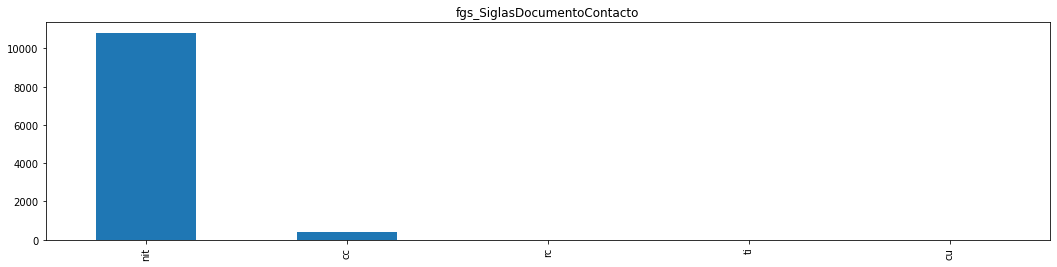

BOGOTA, D.C.       5245
NaN                1455
BARRANCABERMEJA     528
BUCARAMANGA         431
CARTAGENA           381
                   ... 
VILLANUEVA            1
HONDA                 1
MARIQUITA             1
POPAYAN               1
FUSAGASUGA            1
Name: CIUDAD, Length: 91, dtype: int64

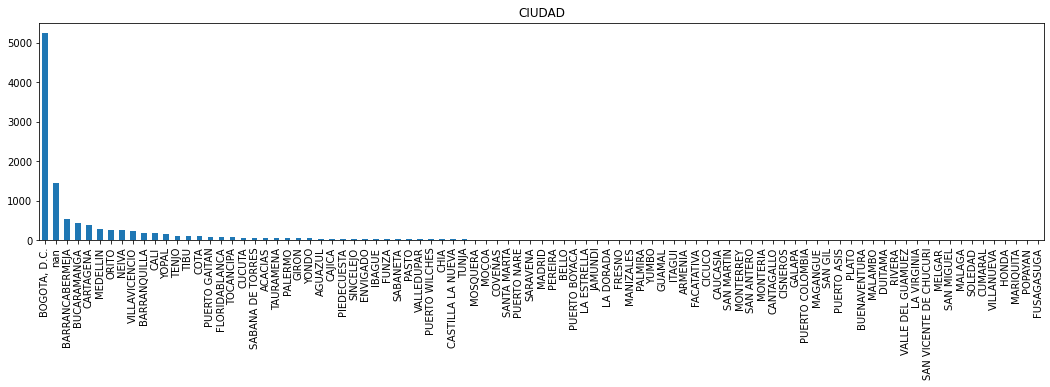

NaN                                         11069
ADMINISTRADORA DE CONTRATOS A                  36
ADMINISTRADORA DE CONTRATOS B                  29
PROFESIONAL DE OPERACIONES FINANCIERAS A       14
ADMINISTRADORA SENIOR DE CONTRATOS              7
PENSIONADOS                                     6
PROFESIONAL INTEGRAL HSE                        5
PROFESIONAL DE ABASTECIMIENTO B                 5
PROFESIONAL INTEGRAL DE GESTIÓN                 5
PROFESIONAL DE LOGÍSTICA E INVENTARIOS A        4
ADMINISTRADORA DE CONVENIOS B                   3
PROFESIONAL DE GESTIÓN                          2
PROF INTEGRAL DE OPERACIÓN DIGITAL B            2
ADMINISTRADOR DE CONTRATOS B                    2
TRAINEE                                         2
GEÓLOGOA JUNIOR B                               2
SUPERVISOR A                                    2
ASISTENTE ADMINISTRATIVOA                       1
PROFESIONAL FINAN Y DESEM EMP A                 1
OPERADOR DE PLANTA SUSP CONTRATO CENIT          1


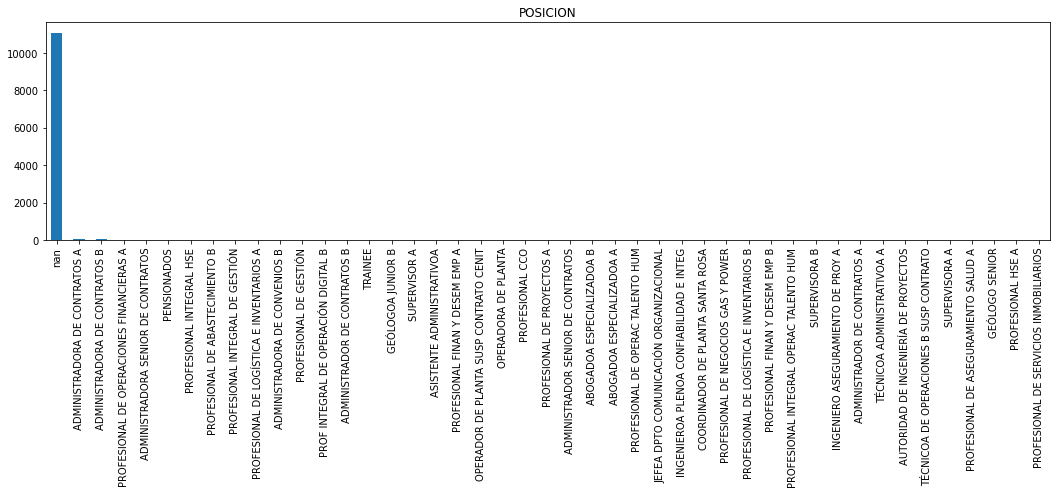

NaN    11069
COL      145
CO         9
Name: PS, dtype: int64

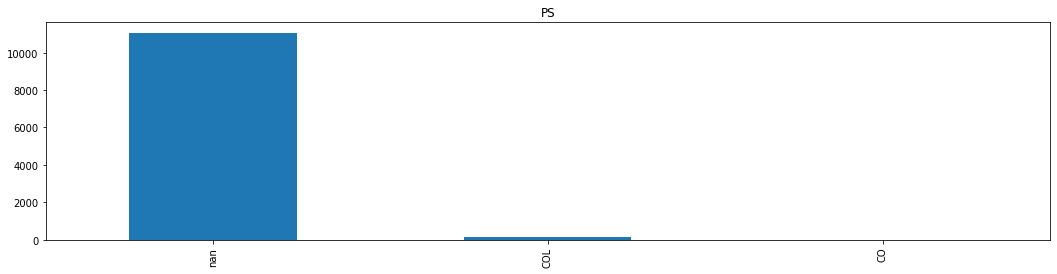

NaN     11069
11.0       71
68.0       24
50.0       21
13.0       19
41.0        7
25.0        3
85.0        3
54.0        2
15.0        2
47.0        1
17.0        1
Name: RG, dtype: int64

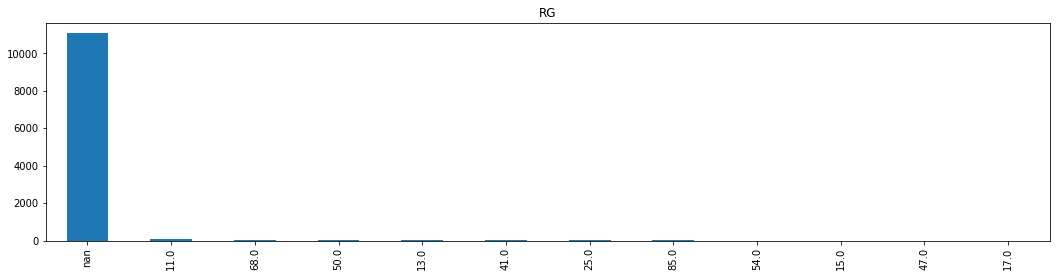

NaN           11065
30/10/1960       11
29/10/1978        8
10/01/1975        5
02/04/1982        5
              ...  
10/09/1980        1
25/09/1979        1
13/01/1985        1
21/12/1972        1
10/02/1976        1
Name: FECHA_NACIMIENTO, Length: 91, dtype: int64

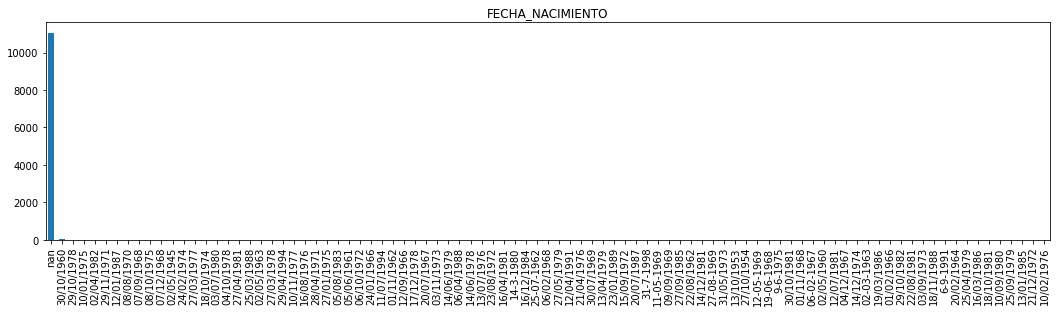

NaN          11067
MASCULINO       97
FEMENINO        58
M                1
Name: SEXO, dtype: int64

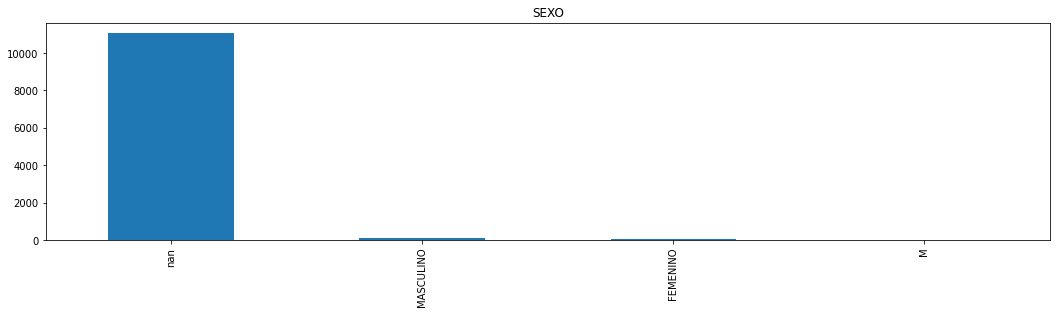

In [ ]:

lista_menores = []
lista_mayores = []
for i in df_entrada.columns:
  
  if df_entrada[i].nunique()<=100:
    display(df_entrada[i].value_counts(dropna =False))
    df_entrada[i].value_counts(dropna =False).plot.bar(title=i,figsize=(18,4))
    plt.show()
    lista_menores.append(i)
  else:
    lista_mayores.append(i)

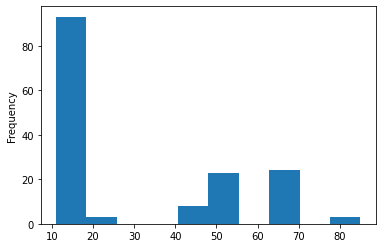

In [ ]:
df_entrada['RG'].plot.hist()

### EDAD

In [ ]:
pd.to_datetime(df_entrada['FECHA_NACIMIENTO'],errors='coerce')

0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
11218   NaT
11219   NaT
11220   NaT
11221   NaT
11222   NaT
Name: FECHA_NACIMIENTO, Length: 11223, dtype: datetime64[ns]

In [ ]:
from datetime import datetime

print(datetime.today())

2021-06-10 23:09:37.239553


In [ ]:
edad = datetime.today().year - pd.to_datetime(df_entrada['FECHA_NACIMIENTO'],errors='coerce').dt.year

In [ ]:
df_entrada['edad']= edad

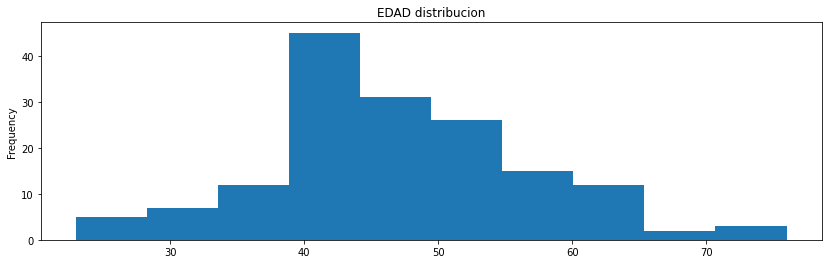

In [ ]:
df_entrada['edad'].plot.hist(title='EDAD distribucion', figsize =(14,4))

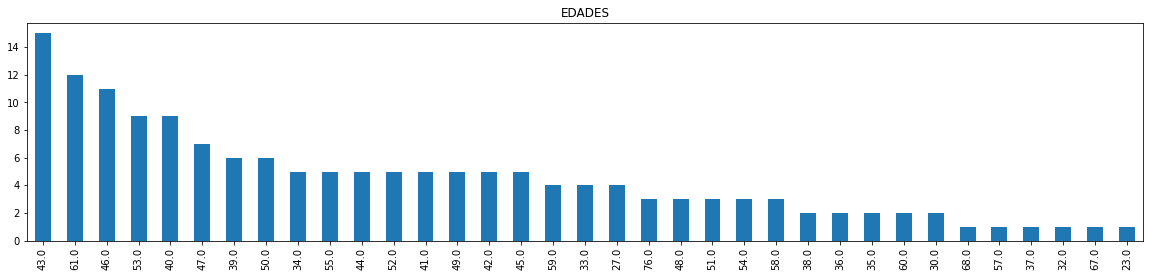

In [ ]:
df_entrada['edad'].astype('O').value_counts().plot.bar(figsize = (20,4), title='EDADES')

In [ ]:
# MIRAR LA COLA HAY AÑOS HAY EDADES PEQUEÑAS, al parece entre mas edad mayor registros hasta cierto punto , despues se da una caida.
# muchos valores no tan a la derecha,  pocos valore pero mas a la izquiera.

In [ ]:
df_entrada['edad'].describe(percentiles=[0.05,0.15,0.25,0.5,0.75,0.85,0.9,0.95,0.99])

count    158.000000
mean      46.911392
std        9.767605
min       23.000000
5%        32.850000
15%       38.550000
25%       41.000000
50%       46.000000
75%       53.000000
85%       58.000000
90%       61.000000
95%       61.000000
99%       76.000000
max       76.000000
Name: edad, dtype: float64

In [ ]:
df_entrada[df_entrada['edad']==93]

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO,edad


In [ ]:
df_entrada[df_entrada['edad']==5]

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO,edad


In [ ]:

df_entrada['POSICION'].value_counts()

ADMINISTRADORA DE CONTRATOS A               36
ADMINISTRADORA DE CONTRATOS B               29
PROFESIONAL DE OPERACIONES FINANCIERAS A    14
ADMINISTRADORA SENIOR DE CONTRATOS           7
PENSIONADOS                                  6
PROFESIONAL DE ABASTECIMIENTO B              5
PROFESIONAL INTEGRAL DE GESTIÓN              5
PROFESIONAL INTEGRAL HSE                     5
PROFESIONAL DE LOGÍSTICA E INVENTARIOS A     4
ADMINISTRADORA DE CONVENIOS B                3
PROFESIONAL DE GESTIÓN                       2
PROF INTEGRAL DE OPERACIÓN DIGITAL B         2
TRAINEE                                      2
GEÓLOGOA JUNIOR B                            2
SUPERVISOR A                                 2
ADMINISTRADOR DE CONTRATOS B                 2
ASISTENTE ADMINISTRATIVOA                    1
JEFEA DPTO COMUNICACIÓN ORGANIZACIONAL       1
INGENIEROA PLENOA CONFIABILIDAD E INTEG      1
OPERADORA DE PLANTA                          1
OPERADOR DE PLANTA SUSP CONTRATO CENIT       1
COORDINADOR D

In [ ]:
df_entrada['POSICION'].value_counts().describe(percentiles=[0.05,0.15,0.25,0.5,0.75,0.85,0.95])

count    44.000000
mean      3.500000
std       6.872595
min       1.000000
5%        1.000000
15%       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
85%       5.000000
95%      12.950000
max      36.000000
Name: POSICION, dtype: float64

In [ ]:

df_entrada['POSICION'].value_counts()[df_entrada['POSICION'].value_counts()>=1]

ADMINISTRADORA DE CONTRATOS A               36
ADMINISTRADORA DE CONTRATOS B               29
PROFESIONAL DE OPERACIONES FINANCIERAS A    14
ADMINISTRADORA SENIOR DE CONTRATOS           7
PENSIONADOS                                  6
PROFESIONAL DE ABASTECIMIENTO B              5
PROFESIONAL INTEGRAL DE GESTIÓN              5
PROFESIONAL INTEGRAL HSE                     5
PROFESIONAL DE LOGÍSTICA E INVENTARIOS A     4
ADMINISTRADORA DE CONVENIOS B                3
PROFESIONAL DE GESTIÓN                       2
PROF INTEGRAL DE OPERACIÓN DIGITAL B         2
TRAINEE                                      2
GEÓLOGOA JUNIOR B                            2
SUPERVISOR A                                 2
ADMINISTRADOR DE CONTRATOS B                 2
ASISTENTE ADMINISTRATIVOA                    1
JEFEA DPTO COMUNICACIÓN ORGANIZACIONAL       1
INGENIEROA PLENOA CONFIABILIDAD E INTEG      1
OPERADORA DE PLANTA                          1
OPERADOR DE PLANTA SUSP CONTRATO CENIT       1
COORDINADOR D

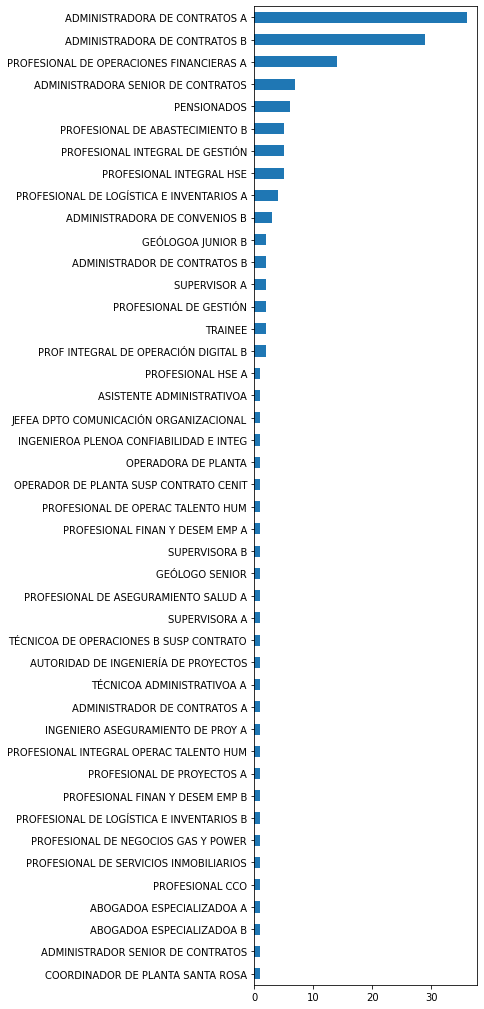

In [ ]:
df_entrada['POSICION'].value_counts()[df_entrada['POSICION'].value_counts()>=1].sort_values().plot.barh(figsize=(4,18))

In [ ]:
df_entrada['POSICION'].value_counts().index.tolist()

['ADMINISTRADORA DE CONTRATOS A',
 'ADMINISTRADORA DE CONTRATOS B',
 'PROFESIONAL DE OPERACIONES FINANCIERAS A',
 'ADMINISTRADORA SENIOR DE CONTRATOS',
 'PENSIONADOS',
 'PROFESIONAL DE ABASTECIMIENTO B',
 'PROFESIONAL INTEGRAL DE GESTIÓN',
 'PROFESIONAL INTEGRAL HSE',
 'PROFESIONAL DE LOGÍSTICA E INVENTARIOS A',
 'ADMINISTRADORA DE CONVENIOS B',
 'PROFESIONAL DE GESTIÓN',
 'PROF INTEGRAL DE OPERACIÓN DIGITAL B',
 'TRAINEE',
 'GEÓLOGOA JUNIOR B',
 'SUPERVISOR A',
 'ADMINISTRADOR DE CONTRATOS B',
 'ASISTENTE ADMINISTRATIVOA',
 'JEFEA DPTO COMUNICACIÓN ORGANIZACIONAL',
 'INGENIEROA PLENOA CONFIABILIDAD E INTEG',
 'OPERADORA DE PLANTA',
 'OPERADOR DE PLANTA SUSP CONTRATO CENIT',
 'COORDINADOR DE PLANTA SANTA ROSA',
 'PROFESIONAL FINAN Y DESEM EMP A',
 'PROFESIONAL DE PROYECTOS A',
 'ADMINISTRADOR SENIOR DE CONTRATOS',
 'ABOGADOA ESPECIALIZADOA B',
 'ABOGADOA ESPECIALIZADOA A',
 'PROFESIONAL CCO',
 'PROFESIONAL DE SERVICIOS INMOBILIARIOS',
 'PROFESIONAL DE NEGOCIOS GAS Y POWER',
 'PROFESION

#Nuevos datos

In [ ]:
contratista = pd.read_csv('Contratistas.csv')
empleados = pd.read_csv('Empleados.csv')
beneficiarios =pd.read_csv('Beneficiarios.csv')
pension =pd.read_csv('Pensionados.csv')

In [ ]:
df_entrada = info_copilada_filtrada

for i in df_entrada.columns:
  print(i)
  try:
   df_entrada[i]=df_entrada[i].map(lambda x: x.lower())
  except:
    print('{} no se puedo pponer en minuscula'.format(i))

lista ={'f':'femenino','m':'masculino'}
df_entrada['SEXO'] = df_entrada['SEXO'].replace(lista)#.map(lambda x : x.replace())


df_entrada['RG'] = df_entrada['RG'].map(lambda x : solo_num(x))

fgs_SiglasDocumentoContacto
fgs_NumeroDocumContacto
fgs_NumeroDocumContacto no se puedo pponer en minuscula
N_DOCUMENTO
N_DOCUMENTO no se puedo pponer en minuscula
fgs_NombreCompletoContacto
NOMBRE_COMPLETO
NOMBRE_COMPLETO no se puedo pponer en minuscula
CIUDAD
CIUDAD no se puedo pponer en minuscula
POSICION
POSICION no se puedo pponer en minuscula
PS
PS no se puedo pponer en minuscula
RG
RG no se puedo pponer en minuscula
FECHA_NACIMIENTO
FECHA_NACIMIENTO no se puedo pponer en minuscula
fdp_FechaCreacion
SEXO
SEXO no se puedo pponer en minuscula


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
df_entrada.columns

Index(['fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto', 'N_DOCUMENTO',
       'fgs_NombreCompletoContacto', 'NOMBRE_COMPLETO', 'CIUDAD', 'POSICION',
       'PS', 'RG', 'FECHA_NACIMIENTO', 'fdp_FechaCreacion', 'SEXO'],
      dtype='object')

In [ ]:

tablas ={}
contratista_tabla = creacion_tabla(contratista)

contratista_tabla

(10971, 18)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.009115,0.0,object,10970,99.990885
AREA,0.082034,0.0,object,1782,16.242822
AREAORGANIZATIVA_UNIDADNEGOCIO,98.833288,0.0,object,20,0.182299
CARGO,0.191414,0.0,object,3776,34.418011
DESCRIPCION,0.537781,0.0,object,116,1.057333
DIRECCION_CONTRATO,15.695926,0.0,object,5239,47.753167
DIRECCION_OFICINA,0.227873,0.0,object,4659,42.466503
DN,0.100264,0.0,object,10933,99.653632
EMPRESA,0.145839,0.0,object,1147,10.454835
FAX,99.289035,0.0,object,36,0.328138


In [ ]:
contratista['ID']

0        1020730000
1         296832439
2        1098647973
3        1130641383
4          63460941
            ...    
10966    1098670197
10967    1121935584
10968      74085533
10969    1010197867
10970      91542138
Name: ID, Length: 10971, dtype: object

In [ ]:
# df_entrada[['fgs_NumeroDocumContacto', 'N_DOCUMENTO']][df_entrada['N_DOCUMENTO'].isnull()]
x = [i in contratista['ID'] for i in df_entrada['fgs_NumeroDocumContacto'] ]
sum(x)

272

In [ ]:

mapa = contratista['ID'].map(lambda x: isnum(x))
print(contratista.shape,contratista[mapa].shape,contratista[mapa].shape[0]/contratista.shape[0]*100 )
contratista = contratista[mapa].copy()
contratista['ID'] = contratista['ID'].astype('int')
tablas['contratista_tabla']=[contratista_tabla,contratista]
#Porcentage de registros que su id cc si es totalmente numerico.

(10971, 18) (10780, 18) 98.25904657734026


In [ ]:
empleados_tabla = creacion_tabla(empleados)
tablas['empleados_tabla']=[empleados_tabla,empleados]
empleados_tabla

(9812, 13)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.0,0.0,int64,9812,100.000000
ID_EMPLEADO,100.0,0.0,float64,0,0.000000
USUARIO,0.0,0.0,object,9812,100.000000
APERS,0.0,0.0,object,10,0.101916
AREA_DE_PERSONAL,0.0,0.0,object,8,0.081533
CENTRO_COSTE,0.0,0.0,object,806,8.214431
CLASE DE FECHA,100.0,0.0,float64,0,0.000000
DTYPE,100.0,0.0,float64,0,0.000000
FECHA_LABORAL,0.0,0.0,object,1865,19.007338
GRPER,0.0,0.0,int64,3,0.030575


In [ ]:
x = [i in empleados['ID'] for i in df_entrada['fgs_NumeroDocumContacto'] ]
sum(x)

269

In [ ]:
beneficiarios_tabla = creacion_tabla(beneficiarios)
beneficiarios_tabla

(76607, 6)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.001305,0.0,object,75864,99.030115
CODIGO_FISCAL_PROVINCIA,0.039161,0.0,object,440,0.574360
HISTORIA_CLINICA,0.169697,0.0,object,98,0.127926
NO_PERS,0.001305,0.0,float64,20113,26.254781
NUMPER_HIS_FAM,64.713407,0.0,object,26476,34.560810
SUBTIPO,0.001305,0.0,object,15,0.019580


In [ ]:
mapa = beneficiarios['ID'].map(lambda x: isnum(x))
print(beneficiarios.shape,beneficiarios[mapa].shape,beneficiarios[mapa].shape[0]/beneficiarios.shape[0]*100 )
beneficiarios = beneficiarios[mapa].copy()
beneficiarios['ID'] = beneficiarios['ID'].astype('int')
tablas['beneficiarios_tabla']=[beneficiarios_tabla,beneficiarios]# valores de ID que si son numericos.

(76607, 6) (68487, 6) 89.40044643439894


In [ ]:
pension_tabla = creacion_tabla(pension)
tablas['pension_tabla']=[pension_tabla,pension]
pension_tabla

(12997, 13)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.000000,0.0,int64,12997,100.000000
ID_PENSIONADO,96.045241,0.0,object,2,0.015388
APERS,96.637686,0.0,object,6,0.046164
AREA_DE_PERSONAL,0.000000,0.0,object,9,0.069247
CENTRO_COSTE,99.992306,0.0,float64,1,0.007694
CLASE DE FECHA,96.045241,0.0,object,4,0.030776
DTYPE,96.045241,0.0,object,3,0.023082
FECHA_PENSIONADO,0.000000,0.0,object,5239,40.309302
GRPER,0.000000,0.0,object,2,0.015388
GRUPO DE PERSONAL,0.000000,0.0,object,2,0.015388


In [ ]:
try:
 variables_eliminar.remove('ID')
except Exception as e: 
  print(e)

list.remove(x): x not in list


In [ ]:
variables_eliminar

['fgs_NombreDocumentoContacto',
 'fgs_FechaNacimientoContacto',
 'fgs_HabeasContacto',
 'fgs_NombreGeneroContacto',
 'fgs_RoutingPointOrVdn',
 'fgs_Extension',
 'fgs_CallId',
 'fgs_Skill',
 'fgs_Ani',
 'fgs_OpcionesIVR',
 'fgs_Nivel5',
 'fgs_Nivel6',
 'fgs_Nivel7',
 'fgs_Nivel8',
 'fgs_Nivel9',
 'fgs_Nivel10',
 'fgs_BarrioDireccion_01',
 'fgs_LocalidadDireccion_01',
 'fgs_Telefono_02',
 'fgs_Telefono_03',
 'fgs_Telefono_04',
 'fgs_Email_02',
 'fgs_Email_03',
 'fdp_IdDetalleFlujoCreacion',
 'fdp_FechaVencimientoCreacion',
 'fdp_MotivoCreacion',
 'fdp_MotivoEscalamientoN2',
 'fdp_IdHistoricoPqrEscalamientoN3',
 'fdp_IdGrupoEscalamientoN3',
 'fdp_NombreGrupoEscalamientoN3',
 'fdp_IdDetalleFlujoEscalamientoN3',
 'fdp_IdUsuarioEscalamientoN3',
 'fdp_UsuarioEscalamientoN3',
 'fdp_NombreUsuarioEscalamientoN3',
 'fgs_ObservacionEscalamientoN3',
 'fdp_FechaEscalamientoN3',
 'fdp_FechaVencimientoEscalamientoN3',
 'CodigoGrupoRolEscalamientoN3',
 'GrupoRolEscalamientoN3',
 'fdp_MotivoEscalamiento

In [ ]:
df_filtradas={}
for i in tablas.keys():
  print(i)
  df_tablas = tablas[i][0]
  df =tablas[i][1]
  variables_eliminar = eliminacion_columnas(df_tablas)
  try:
    variables_eliminar.remove('ID')
  except Exception as e: 
    print(e)
  mapa_columnas = [i not in variables_eliminar for i in df.columns]  
  nuevas_columnas = df.columns[mapa_columnas]
  df_filtradas['{}_filtrada'.format(i)] =df[nuevas_columnas] 




contratista_tabla
numero de variables a eliminar : 0
list.remove(x): x not in list
empleados_tabla
numero de variables a eliminar : 6
beneficiarios_tabla
numero de variables a eliminar : 0
list.remove(x): x not in list
pension_tabla
numero de variables a eliminar : 4


In [ ]:
df_filtradas.keys()

dict_keys(['contratista_tabla_filtrada', 'empleados_tabla_filtrada', 'beneficiarios_tabla_filtrada', 'pension_tabla_filtrada'])

In [ ]:
mytable(df_filtradas['empleados_tabla_filtrada'])

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.0,0.0,int64,9812,100.000000
APERS,0.0,0.0,object,10,0.101916
AREA_DE_PERSONAL,0.0,0.0,object,8,0.081533
CENTRO_COSTE,0.0,0.0,object,806,8.214431
FECHA_LABORAL,0.0,0.0,object,1865,19.007338
GRPER,0.0,0.0,int64,3,0.030575
GRUPO_PERSONAL,0.0,0.0,object,3,0.030575
UNIDAD_ORGANIZATIVA,0.0,0.0,object,558,5.686914


In [ ]:
mytable(df_entrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.0,int64,2105,18.756126
N_DOCUMENTO,12.964448,0.0,float64,1715,15.281119
fgs_NombreCompletoContacto,0.000000,0.0,object,2044,18.212599
NOMBRE_COMPLETO,12.964448,0.0,object,1709,15.227657
CIUDAD,12.964448,0.0,object,90,0.801925
POSICION,98.627818,0.0,object,44,0.392052
PS,98.627818,0.0,object,2,0.017821
RG,98.627818,0.0,float64,11,0.098013
FECHA_NACIMIENTO,98.592177,0.0,object,90,0.801925


In [ ]:
mapa = beneficiarios['ID'].map(lambda x: isnum(x))
print(beneficiarios.shape,beneficiarios[mapa].shape,beneficiarios[mapa].shape[0]/beneficiarios.shape[0]*100 )
beneficiarios = beneficiarios[mapa].copy()
beneficiarios['ID'] = beneficiarios['ID'].astype('int')

(68487, 6) (68487, 6) 100.0


In [ ]:
df_entrada.columns

Index(['fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto', 'N_DOCUMENTO',
       'fgs_NombreCompletoContacto', 'NOMBRE_COMPLETO', 'CIUDAD', 'POSICION',
       'PS', 'RG', 'FECHA_NACIMIENTO', 'fdp_FechaCreacion', 'SEXO'],
      dtype='object')

In [ ]:
for i in df_filtradas.keys():
  tam = df_entrada.shape
  print(i)
  df_merge = df_filtradas[i].copy()

  # # las columnas se pueden llamar igual pero contener diferente informacion
  # diff_cols = df_merge.drop(columns = ['ID']).columns.difference(df_entrada.columns)
  # df_entrada = df_entrada.merge(how='left', right=df_merge.set_index('ID')[diff_cols],left_on='fgs_NumeroDocumContacto',right_index=True)
    
  df_entrada = df_entrada.merge(how='left', right=df_merge.set_index('ID').add_suffix(' {}'.format(i[:-14])),left_on='fgs_NumeroDocumContacto',right_index=True)
  
  # df_entrada = df_entrada.merge(how='left', right=df_merge,left_on='fgs_NumeroDocumContacto',right_on='ID')
 
  print(tam,df_entrada.shape)


contratista_tabla_filtrada
(11223, 12) (11223, 29)
empleados_tabla_filtrada
(11223, 29) (11223, 36)
beneficiarios_tabla_filtrada
(11223, 36) (11223, 41)
pension_tabla_filtrada
(11223, 41) (11223, 50)


In [ ]:
df_filtradas[i].columns


Index(['ID', 'ID_PENSIONADO', 'APERS', 'AREA_DE_PERSONAL', 'CLASE DE FECHA',
       'DTYPE', 'FECHA_PENSIONADO', 'GRPER', 'GRUPO DE PERSONAL',
       'UNIDAD_ORGANIZATIVA'],
      dtype='object')

In [ ]:
mytable(df_entrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.0,int64,2105,18.756126
N_DOCUMENTO,12.964448,0.0,float64,1715,15.281119
fgs_NombreCompletoContacto,0.000000,0.0,object,2044,18.212599
NOMBRE_COMPLETO,12.964448,0.0,object,1709,15.227657
CIUDAD,12.964448,0.0,object,90,0.801925
POSICION,98.627818,0.0,object,44,0.392052
PS,98.627818,0.0,object,2,0.017821
RG,98.627818,0.0,float64,11,0.098013
FECHA_NACIMIENTO,98.592177,0.0,object,90,0.801925


In [ ]:

df_tablas = mytable(df_entrada)
df =df_entrada
variables_eliminar = eliminacion_columnas(df_tablas)
try:
  variables_eliminar.remove('ID')
except Exception as e: 
  print(e)
mapa_columnas = [i not in variables_eliminar for i in df.columns]  
nuevas_columnas = df.columns[mapa_columnas]
df_entrada=df[nuevas_columnas] 


numero de variables a eliminar : 13
list.remove(x): x not in list


In [ ]:
variables_eliminar

['AREAORGANIZATIVA_UNIDADNEGOCIO contratista_',
 'FAX contratista_',
 'HOME contratista_',
 'NOTAS contratista_',
 'PAGER contratista_',
 'ID_PENSIONADO pension_',
 'APERS pension_',
 'CLASE DE FECHA pension_',
 'DTYPE pension_',
 'WEB contratista_',
 'GRPER pension_',
 'GRUPO DE PERSONAL pension_',
 'UNIDAD_ORGANIZATIVA pension_']

In [ ]:
df_tablas = mytable(df_entrada)
vacio90 = df_tablas[df_tablas['% de datos nulos']<90].index

In [ ]:
# print(df_entrada.shape)
# df_entrada=df_entrada[vacio90].copy()
# print(df_entrada.shape)

In [ ]:
columnas = pd.Series(df_entrada.columns)
df_entrada=df_entrada[df_entrada.columns[~columnas.duplicated(keep= 'first')]].copy()


In [ ]:
mytable(df_entrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,5,0.044551
fgs_NumeroDocumContacto,0.000000,0.0,int64,2105,18.756126
N_DOCUMENTO,12.964448,0.0,float64,1715,15.281119
fgs_NombreCompletoContacto,0.000000,0.0,object,2044,18.212599
NOMBRE_COMPLETO,12.964448,0.0,object,1709,15.227657
CIUDAD,12.964448,0.0,object,90,0.801925
POSICION,98.627818,0.0,object,44,0.392052
PS,98.627818,0.0,object,2,0.017821
RG,98.627818,0.0,float64,11,0.098013
FECHA_NACIMIENTO,98.592177,0.0,object,90,0.801925


In [ ]:
pd.Series(df_entrada.columns)#.replace({'contratista_':'','empleados_':'','beneficiarios_':'','pension_':''},regex=True).duplicated(keep=False)

0                fgs_SiglasDocumentoContacto
1                    fgs_NumeroDocumContacto
2                                N_DOCUMENTO
3                 fgs_NombreCompletoContacto
4                            NOMBRE_COMPLETO
5                                     CIUDAD
6                                   POSICION
7                                         PS
8                                         RG
9                           FECHA_NACIMIENTO
10                         fdp_FechaCreacion
11                                      SEXO
12                         AREA contratista_
13                        CARGO contratista_
14                  DESCRIPCION contratista_
15           DIRECCION_CONTRATO contratista_
16            DIRECCION_OFICINA contratista_
17                           DN contratista_
18                      EMPRESA contratista_
19             FECHA_EXPIRACION contratista_
20                        LOGIN contratista_
21                      MANAGER contratista_
22        

In [ ]:
df_entrada['UNIDAD_ORGANIZATIVA empleados_'].value_counts( dropna=False)

NaN                                         11084
Gerencia Administrativa                        18
Coordinación de Gestión de Contratación        12
Coordinación de Gestión de Cuentas Pagar       12
Coord de Gest de Contrat Reg Andina Orie       10
Gerencia Administrativa VDS                     9
Coord Gestión de Contrat Reg Orinoquía          6
Depto Regional Ambiental Andina Oriente         5
Gerencia de Soporte Tecnológico                 4
Gerencia Administrativa VAB                     4
Dep de Gestión Integral y Abastecimiento        4
Coord de Gestión de Contratación                4
Departamento de Compras                         3
Coord de Gestión de Contrat Reg Central         3
Gerencia de Seguridad Física                    3
Coordinación de Gestión de Inventarios          2
Coordinación Conectividad                       2
Gerencia de Planeación de TH                    2
Depto Regional de Abastecimiento Caribe         2
Coordinación de Logística de Bienes             2


In [ ]:
for i in df_entrada.columns:
  df = df_entrada[i].copy()
  if df.dtypes==int:
    display(df.describe())
    df.plot.hist(title=i,figsize=(14,4))
    plt.show()
  if df.dtypes==object:
    display(df.value_counts(dropna = False))
    df.value_counts(dropna = False).plot.bar(title=i,figsize=(14,4))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.